<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SCFW" data-toc-modified-id="SCFW-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SCFW</a></span></li><li><span><a href="#SCFW" data-toc-modified-id="SCFW-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SCFW</a></span></li><li><span><a href="#Code-to-run-the-experiments" data-toc-modified-id="Code-to-run-the-experiments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Code to run the experiments</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Reduced-means-that-we-estimate-number-of-measurements-online" data-toc-modified-id="Reduced-means-that-we-estimate-number-of-measurements-online-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Reduced means that we estimate number of measurements online</a></span></li></ul></li></ul></li><li><span><a href="#Alternative-approach" data-toc-modified-id="Alternative-approach-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Alternative approach</a></span><ul class="toc-item"><li><span><a href="#Experiment:-SCF-trajectory" data-toc-modified-id="Experiment:-SCF-trajectory-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Experiment: SCF trajectory</a></span><ul class="toc-item"><li><span><a href="#SFW_Adaptive:-need-to-compare-with-non-adaptive---convergence-plot-(20-realizations-E-=-20,-D-=-2,10,20)." data-toc-modified-id="SFW_Adaptive:-need-to-compare-with-non-adaptive---convergence-plot-(20-realizations-E-=-20,-D-=-2,10,20).-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>SFW_Adaptive: need to compare with non-adaptive - convergence plot (20 realizations E = 20, D = 2,10,20).</a></span></li><li><span><a href="#SCF-to-compare" data-toc-modified-id="SCF-to-compare-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>SCF to compare</a></span></li></ul></li><li><span><a href="#Comparison-of-Alternative-and-SFW-approaches-(convergence-rates)" data-toc-modified-id="Comparison-of-Alternative-and-SFW-approaches-(convergence-rates)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Comparison of Alternative and SFW approaches (convergence rates)</a></span><ul class="toc-item"><li><span><a href="#SFW_Adaptive-(-separately---trajectory-plot.)" data-toc-modified-id="SFW_Adaptive-(-separately---trajectory-plot.)-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>SFW_Adaptive ( separately - trajectory plot.)</a></span></li><li><span><a href="#Alternative-approach-experiment" data-toc-modified-id="Alternative-approach-experiment-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Alternative approach experiment</a></span></li></ul></li></ul></li><li><span><a href="#PLOTS" data-toc-modified-id="PLOTS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PLOTS</a></span></li></ul></div>

# Thesis experiments for SFW method (Section 3.5)

In [526]:
import numpy as np
from numpy import linalg
from scipy.optimize import linprog
from cvxopt import matrix, spmatrix
from cvxopt.solvers import options, qp, lp 
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt
%matplotlib inline

In [527]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [528]:
def f(x, x_0):
    return 0.5*np.linalg.norm(x - x_0)**2

In [529]:
def df(x, x_0):
    return x - x_0

In [654]:
def get_measurements(A, b, x, sigma):
    m = np.shape(A)[0]
    return A.dot(x) - b + np.random.normal(0, sigma**2, m)

In [655]:
A = np.array([[-1,0],[0,-1]])
b = np.array([1,1])
x = np.array([0,0])
sigma = 0.01
get_measurements(A, b, x, sigma)

array([-0.99995404, -0.99990864])

In [656]:
#X - list of np.arrays, Y - list of np.arrays, x - np.array
def make_and_add_measurement(A, b, X, Y, x, sigma):
    X.append(x)
    Y.append(get_measurements(A, b, x, sigma))
    return X,Y

In [657]:
def estimate_constraints(X, Y):
    N = np.shape(X)[0]
    X_ext = np.vstack((np.array(X).T,-1*np.ones(N))).T
    Ab_est = np.linalg.inv(X_ext.T.dot(X_ext)).dot(X_ext.T).dot(Y)
    A_est = Ab_est[:-1].T
    b_est =  Ab_est[-1]
    return  A_est, b_est

In [658]:
def solve_DFS(A_est, b_est, grad):
    sol = linprog(grad, 
                                  A_ub = A_est, 
                                  b_ub = b_est, 
                                  bounds=((None, None)), 
                                  options={"disp": False})
    #print "status", sol.status
    return sol.x, sol.status

In [659]:
eps = 0.1/15
sigma = 0.01
omega = 0.01
phi = np.sqrt(chi2.ppf(1 - eps, x.size+1))
C_n = sigma**2*phi**2/omega**2
print eps, np.sqrt(chi2.ppf(1 - eps, x.size+1)), C_n


0.00666666666667 3.495694848372444 12.219882472937645


In [660]:
def true_solution(x_0, A, b):
    d = np.size(x_0)
    P = np.eye(d)
    q = -1*x_0
    m = np.size(b)
    G = A
    h = b
    args = [matrix(P, tc = 'd'), matrix(q, tc = 'd'), matrix(G, tc = 'd'), matrix(h, tc = 'd')]
    sol = qp(*args)
    if 'optimal' not in sol['status']:
        return None
    plt.scatter(sol['x'][0],sol['x'][1], color = 'r')
    return sol['primal objective'] + 0.5*np.linalg.norm(x_0)**2, np.array(sol['x']).reshape((P.shape[1],))

In [661]:
def violation(x, A, b):
    m = np.shape(A)[0]
    viol = 0.
    delta = np.zeros(m)
    for i in range(m):
        delta[i] = b[i] - A[i].dot(x)
    delta_min = np.min(delta)
    if delta_min < 0:       
        return 1., -1*delta_min
    else:
        return 0., -1*delta_min

# SCFW

In [711]:
def SCFW(df, A, b, x_start, sigma, omega, gamma_init, n_0, T_max, eps, fopt, x_0, center, N = 0):
    X = []
    Y = []
    x = x_start
    e = []
    err = np.zeros(T_max)
    delta = np.zeros(T_max)
    x_vec_0 = np.zeros(T_max)
    x_vec_1 = np.zeros(T_max)
    d = np.size(x_start)
    phi = sigma*np.sqrt(chi2.ppf(1 - eps, d+1))
    omega_t = np.zeros(2*d)
    counter = 0
    viol = 0.
    nonconv = 0
    number_of_meas = 0.
    useless_steps = 0.
    gamma_seq = np.zeros(T_max)
    gamma_prev = np.zeros(T_max)
#     x_for_safety_1 = np.ones((25,2))
#     x_for_safety_1.T[1] = np.arange(-1,1,0.08)
#     x_for_safety_2 = np.ones((25,2))
#     x_for_safety_2.T[0] = -1*np.arange(-1,1,0.08)
#     x_for_safety_3 = -1*np.ones((25,2))
#     x_for_safety_3.T[1] = -1*np.arange(-1,1,0.08)
#     x_for_safety_4 = -1*np.ones((25,2))
#     x_for_safety_4.T[0] = np.arange(-1,1,0.08)
#     x_for_safety = np.vstack((x_for_safety_1,x_for_safety_2, x_for_safety_3,x_for_safety_4,(1,-1)))
#     g_safety = np.zeros((101,2))
#     gamma_s = np.zeros(101)
    for i in range(d):
        e.append(np.eye(d)[i])
        e.append(-np.eye(d)[i])
    
    for t in range(T_max):
        if t > 0:
            A_est_prev, b_est_prev, X_arr_prev = A_est, b_est, X_arr
        
        x_vec_0[t] = x[0]
        x_vec_1[t] = x[1]
        err[t] = f(x, x_0) - fopt
        n_t = d*int((t+1)*np.log(t+2)**2*phi**2*(1./omega**2+1)*np.log(np.log(T_max))) #на d уже умножено в exp
        print n_t, t+1,   d, np.log(t+2)**2,  phi**2, 2*(t+2)*d*np.log(t+3)**2*phi**2*(1./omega+1)
#       print n_t

        for i in range(n_t):
            if center == 0:
                x_measure = x + omega*e[i%(2*d)]
            elif center == 1:
                x_measure = x_start + omega*e[i%(2*d)]
            
######    Plotting trajectories ############ 
#             if i < 2*d:
#                 plt.scatter(x_measure[0], x_measure[1], color = "green")
        
            make_and_add_measurement(A, b, X, Y, x_measure, sigma)
            number_of_meas = number_of_meas + 1.
        
        A_est, b_est = estimate_constraints(X, Y)
        sol_DFS = solve_DFS(A_est, b_est, df(x, x_0))
        s =  sol_DFS[0]

######    Plotting trajectories ############ 
        #plt.scatter(s[0], s[1], marker = "v", color = "magenta")
    
        X_arr = np.array(X)
        if t > 0:
            gamma_prev[t] = bound_gamma(A_est, b_est, X_arr, sigma, x_prev, s_prev, eps, omega_case = 0)[0]
            #print  "G_{t+1} - G_t", gamma_prev - gamma_max
        sol =  bound_gamma(A_est, b_est, X_arr, sigma, x, s, eps, omega_case = 0)
        gamma_max = sol[0]
        
        if sol_DFS[1] >= 2:
            gamma_max = 0
            
#         if gamma_max > 1:
#             print "t", t, "gamma_max", gamma_max
        gamma_seq[t] = gamma_max
        delta[t] = violation(x, A, b)[1]
        #gamma = min(1./(t+2 - useless_steps), gamma_max)
        gamma = 1./(t+2 - useless_steps)
        if gamma != 0:
            counter = counter + 1
        elif gamma == 0 and counter != 0:
            nonconv = 1
        #print counter
        
        #if (gamma_max == 0) and (t - useless_steps > 0):
        s_prev = s
        x_prev = x
        #sol_prev =  bound_gamma(A_est_prev, b_est_prev, X_arr_prev, sigma, x, s, eps)
        #gamma_max_prev = sol_prev[0]
        #gamma = min(1./(t+2 - useless_steps), gamma_max_prev)
        gamma = 1./(t+2) 
        if gamma_max == 0:    
            useless_steps = useless_steps + 1.
            
######    Plotting trajectories ############  
#         if d == 2:
#             for i in range(101):
#                 gamma_s[i] =  bound_gamma(A_est, b_est, X_arr, sigma, x, x_for_safety[i], eps, omega_case = 0)[0]
#                 g_safety[i] = (1 - gamma_s[i])*x + gamma_s[i]*x_for_safety[i]
#             plt.plot(g_safety.T[0], g_safety.T[1], color = "orange")
#
        x = (1 - gamma)*x + gamma*s
        viol = viol + violation(x, A, b)[0]
    
    ######    Plotting trajectories ############ 
    #plt.plot(x_vec_0, x_vec_1, color = "red")
    
    viol_ratio = viol/T_max
    print number_of_meas, nonconv
    return x, err, delta, viol_ratio, gamma_seq, nonconv, gamma_prev

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
4 1 2 0.4804530139182014 0.0006251388631170326 0.6096446465717504
30 2 2 1.206948960812582 0.0006251388631170326 1.4560960771727807
70 3 2 1.9218120556728056 0.0006251388631170326 2.6167745663298114
128 4 2 2.5902903939802346 0.0006251388631170326 4.054033048389732
198 5 2 3.210401995568401 0.0006251388631170326 5.737922531024241
282 6 2 3.7865663081964716 0.0006251388631170326 7.6445044051570985
376 7 2 4.324077125263812 0.0006251388631170326 9.754314345148007
480 8 2 4.827795843250328 0.0006251388631170326 12.0512404177858
594 9 2 5.301898110478399 0.0006251388631170326 14.521727626838384
716 10 2 5.749901739308773 0.0006251388631170326 17.154209331586962
846 11 2 6.174761

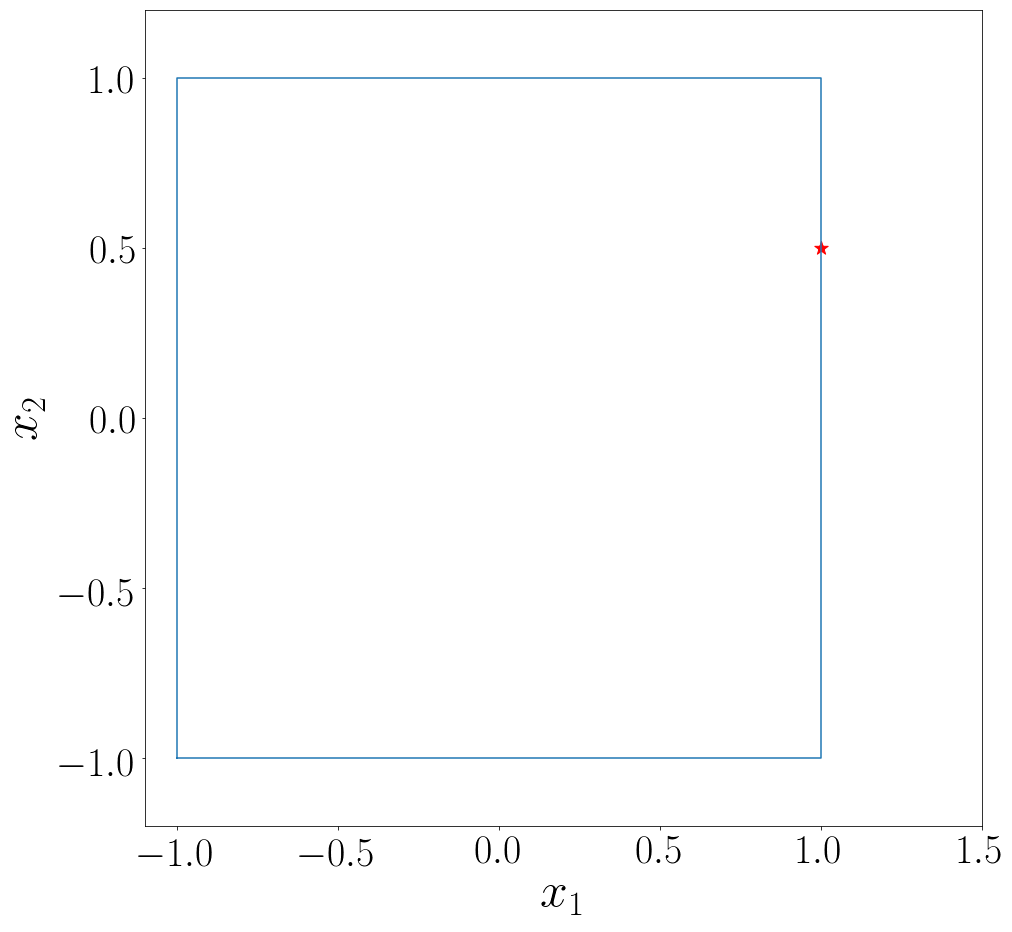

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


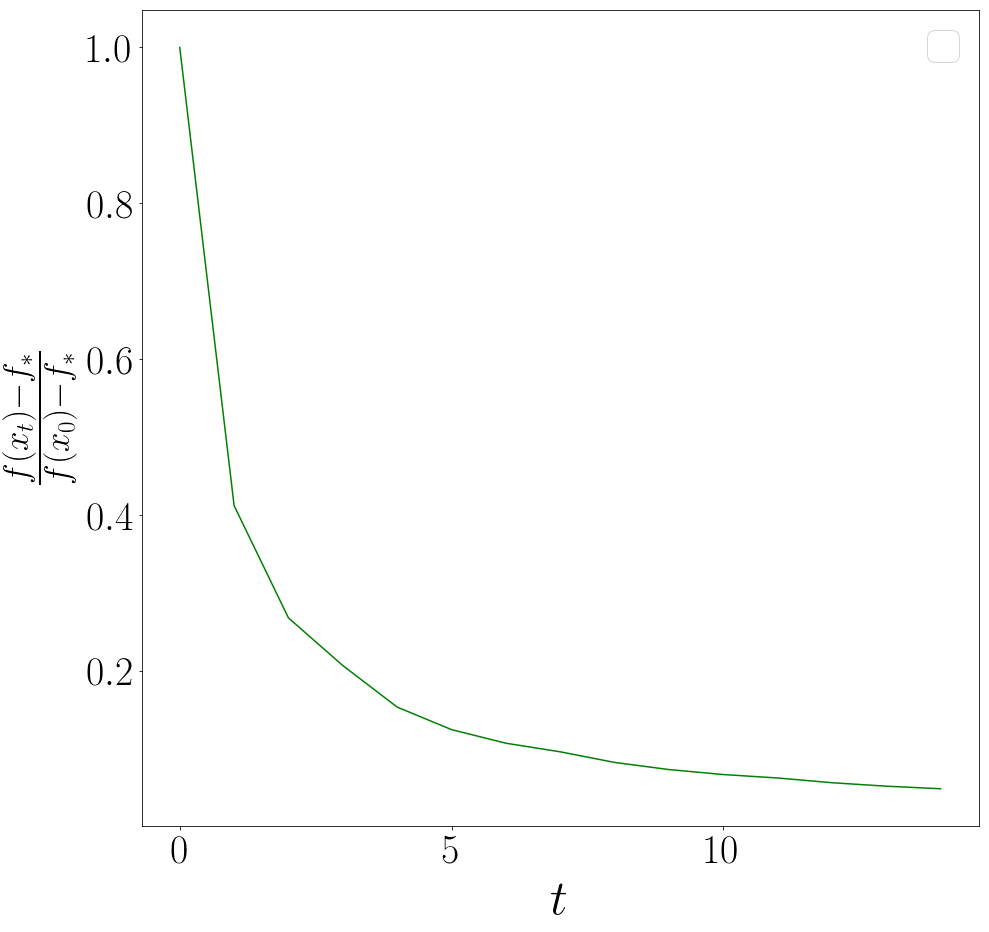

In [712]:
#max, eps, omega, E, Enum, d = 4(optional), x_start(optional)
D = 2
exp2 = Exp(15, 0.1, 0.01, 1, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW, sigma = 0.01,center = 0, n0 = 50)

# Code to run the experiments

In [713]:
def Exp(
    T_max,
    eps,
    omega,
    E, 
    Enum,
    d = 4,
    x_start=np.array([0.,0.,0.,0.]),
    bad_cond=0,
    int_cond=0,
    n0=20,
    sigma=0.1,
    rand_seed=42,
    method=SCFW,
    center=0,
    maxmin=0,
    storage=None,
    N = 0
    ):
    
    if storage is None:
        storage = []
    
    A = np.zeros((2*d, d))
    for i in range(d):
        A[i] = np.eye(d)[i]
        A[d + i] = -1.*np.eye(d)[i]
    b = np.ones(2*d)
    
    if bad_cond == 1:
        A[0] = np.ones(d)
        A[0,0] = 0.5
        A[d] = -np.ones(d)
        A[d,0] = -0.5
        b[0] = 0.5
        b[d] = 0.5
        
    if int_cond == 0:
        x_0 = 0.5*np.ones(d) + 2*np.eye(d)[0]
    elif int_cond == 1:
        x_0 = 0.5*np.ones(d) + 0.2*np.eye(d)[0]
    elif int_cond == 2:
        x_0 = -0.5*np.ones(d) + -2*np.eye(d)[0]
    elif int_cond == 3:
        x_0 = 2*np.ones(d)
        
    gamma_init = 1.
    n_0 = n0
    
    
    plt.figure(figsize=(15, 15))
    plt.xlim((-1.1, 1.5))
    plt.ylim((-1.2, 1.2))
    #viol = []
    #x_sol_0 = []
    #x_sol_1 = []
    viol = np.zeros(Enum)
    nonconvergence = np.zeros(Enum)
    #np.zeros(Enum)
    eps_v = np.zeros(Enum)
    #eps_v.append(np.zeros(Enum))
    avg_conv = np.zeros(Enum)
    #avg_conv.append(np.zeros(Enum))
    sol_f = []
    sol_v = []
    sol_g = []

    for j in range(Enum):
        #viol.append(np.zeros(E))
        #eps_v.append(np.zeros(E))
        #avg_conv.append(np.zeros(E))
        #sol_f.append(np.zeros((E, T_max)))
        
        solution = []
        np.random.seed(rand_seed)
        true = true_solution(x_0, A, b)
        fopt = true[0]
        xopt = true[1]

        for i in range(E):
            solution.append(method(df, A, b, x_start, sigma, omega, gamma_init, n_0, T_max, eps, fopt, x_0, center, N))
        
        #x_sol_0.append(xopt[0])
        #x_sol_1.append(xopt[1])
        plt.tick_params(axis='both', which='major', labelsize=40)
        plt.scatter(xopt[0],xopt[1], marker = "*", color = "red", s = 200)
        filex = 'perda_perda_plot0'+str(j)+'.eps'
        plt.xlabel(r"$x_1$", fontsize=50)
        plt.ylabel(r"$x_2$", fontsize=50)
#plot a box constraints
        if bad_cond == 0:
            plt.plot(np.array([-1.,1.,1.,-1.,-1.]),np.array([-1.,-1.,1.,1.,-1.]))
        plt.savefig(filex)
        plt.show()

        sol_f.append(np.zeros((E, T_max)))
        for i in range(E):
            sol_f[j][i] = solution[i][1]
        
        sol_v.append(np.zeros((E, T_max)))
        for i in range(E):
            sol_v[j][i] = np.array(solution[i][2])
            
        vio = 0.
        for i in range(E):
            if solution[i][3] > 0:
                vio = vio + 1.
        print "eps", eps, "vio", vio/E
        viol[j] = vio/E
        
        non_conv = 0.
        conv = np.zeros(E)      
        nconv = np.zeros(E)
        for i in range(E):
            nconv[i] = solution[i][5]
            conv[i] = (f(solution[i][0], x_0) - fopt)/(f(solution[0][0], x_0) - fopt) 
            #if conv[i] >= f(x_start, x_0) - 1.:
            #    non_conv = non_conv + 1.
        avg_conv[j] = np.mean(conv)
        print "eps", eps, "non_conv", np.mean(nconv)#non_conv/E
        nonconvergence[j] =  np.mean(nconv)#non_conv/E
        eps_v[j] = eps
        eps = eps/2.
        
        sol_g.append(np.zeros((E, T_max)))
        for i in range(E):
            sol_g[j][i] = np.array(solution[i][4])
        print "gamma"
    
    colors = ['green', 'magenta', 'blue', 'olive', 'orange', 'red' ]
        
    plt.figure(figsize=(15, 15))
    for j in range(Enum):
        mean_sol = sol_f[j].mean(axis = 0)
        std_sol = sol_f[j].std(axis = 0)
        min_sol = sol_f[j].min(axis = 0)
        max_sol = sol_f[j].max(axis = 0)
        storage.append((range(T_max), mean_sol, std_sol, min_sol, max_sol, '$\delta = $'+10*str(eps_v[j])))
        plt.plot(range(T_max), mean_sol / mean_sol.max(), color = colors[j])#, label='$\delta = $'+str(eps_v[j]))
        plt.fill_between(range(T_max), (mean_sol + std_sol) / mean_sol.max(), (mean_sol-std_sol) / mean_sol.max(), facecolor=colors[j], alpha=0.3)#, label = 'Standard deviation of convergence')
        if maxmin == 1:
            plt.fill_between(range(T_max), max_sol, min_sol, facecolor='yellow', alpha=0.5, label='Critical values')
    plt.legend(loc='best', fontsize=40)
    plt.tick_params(axis='both', which='major', labelsize=40)
    filex1 = 'perda_perda_plot1'+str(j)+'.eps'
    plt.xlabel(r"$t$", fontsize=50) 
    plt.ylabel(r"$\frac{f(x_t) - f_*}{f(x_0) - f_*}$", fontsize=50)
    plt.savefig(filex1)
    plt.show()
    storage.append([])
        
#     plt.figure(figsize=(15, 15))
#     for j in range(Enum):        
#         mean_vio = sol_v[j].mean(axis = 0)
#         std_vio = sol_v[j].std(axis = 0)
#         min_vio = sol_v[j].min(axis=0)
#         max_vio = sol_v[j].max(axis=0)
#         storage.append((range(T_max), mean_vio, std_vio, min_vio, max_vio, '$\delta = $'+str(eps_v[j])))
#         plt.plot(range(T_max), mean_vio, color = colors[j], label=r'Mean violation, $\delta = $'+str(eps_v[j]))
#         plt.fill_between(range(T_max), mean_vio+std_vio, mean_vio-std_vio, facecolor=colors[j], alpha=0.3)#, label='Standard deviation of violation')
#         if maxmin == 1:
#             plt.fill_between(range(T_max), max_vio, min_vio, facecolor='yellow', alpha=0.5, label = 'Critical values')
#     plt.tick_params(axis='both', which='major', labelsize=40)
#     plt.legend(loc='best', fontsize=40)
#     filex2 = 'perda_perda_plot2'+str(j)+'.eps'
#     plt.xlabel(r"$t$", fontsize=50)
#     plt.ylabel("violation", fontsize=50)
#     plt.savefig(filex2)
#     plt.show()
#     storage.append([])
    
        
#     plt.figure(figsize=(15, 15))
        
#     for j in range(Enum):       
#         mean_g = sol_g[j].mean(axis = 0)
#         std_g = sol_g[j].std(axis = 0)

#         #for i in range(E):
#         #    plt.plot(range(T_max), solution[i][4])
#         storage.append((range(T_max), mean_g, std_g, sol_g[j].min(axis=0), sol_g[j].max(axis=0), '$\delta = $'+str(eps_v[j])))
#         plt.plot(range(T_max), mean_g, color = colors[j], label= r"Mean $\Gamma_t$, $\delta_t = $"+str(eps_v[j]))
#         plt.fill_between(range(T_max), mean_g+std_g, mean_g-std_g, facecolor=colors[j], alpha=0.3)#, label=r'Standard deviation of  $\Gamma_t$')
#         plt.plot(range(T_max), np.zeros(T_max))
        
    #plt.legend(loc='best', fontsize=40)
    #filex3 = 'perda_perda_plot3'+str(j)+'.eps'
    #plt.xlabel(r"$t$", fontsize=50)
    #plt.ylabel(r"$\Gamma_t$" , fontsize=50)
#     plt.tick_params(axis='both', which='major', labelsize=40)
#     plt.savefig(filex3)
#     plt.show()

    return eps_v, viol, nonconvergence, avg_conv, storage

### Reduced means that we estimate number of measurements online

In [714]:
def SCFW_reduced(df, A, b, x_start, sigma, omega, gamma_init, n_0, T_max, eps, fopt, x_0, center, N = 0):
    X = []
    Y = []
    x = x_start
    e = []
    err = np.zeros(T_max)
    delta = np.zeros(T_max)
    x_vec_0 = np.zeros(T_max)
    x_vec_1 = np.zeros(T_max)
    d = np.size(x_start)
    omega_t = np.zeros(2*d)
    x_meas_0 = np.zeros(4*T_max)
    x_meas_1 = np.zeros(4*T_max)
    counter = 0
    viol = 0.
    nonconv = 0
    number_of_meas = 0.
    useless_steps = 0.
    gamma_seq = np.zeros(T_max)
    gamma_prev = np.zeros(T_max)
    x_for_safety_1 = np.ones((100,2))
    x_for_safety_1.T[1] = np.arange(-1,1,0.02)
    x_for_safety_2 = np.ones((100,2))
    x_for_safety_2.T[0] = -1*np.arange(-1,1,0.02)
    x_for_safety_3 = -1*np.ones((100,2))
    x_for_safety_3.T[1] = -1*np.arange(-1,1,0.02)
    x_for_safety_4 = -1*np.ones((100,2))
    x_for_safety_4.T[0] = np.arange(-1,1,0.02)
    x_for_safety = np.vstack((x_for_safety_1,x_for_safety_2, x_for_safety_3,x_for_safety_4,(1,-1)))
    g_safety = np.zeros((401,2))
    gamma_s = np.zeros(401)

    for i in range(d):
        e.append(np.eye(d)[i])
        e.append(-np.eye(d)[i])
    
    for t in range(T_max):
        x_vec_0[t] = x[0]
        x_vec_1[t] = x[1]
        err[t] = f(x, x_0) - fopt
        
        n_t = d*int((t+1)*np.log(t+2)**2*phi**2*(1./omega**2+1)*np.log(np.log(T_max)))

        for i in range(n_t):
            if center == 0:
                x_measure = x + omega*e[i%(2*d)]
            elif center == 1:
                x_measure = x_start + omega*e[i%(2*d)]
            
            make_and_add_measurement(A, b, X, Y, x_measure, sigma)
            number_of_meas = number_of_meas + 1.
            
            if i<4:
                x_meas_0[4*t + i] = x_measure[0]
                x_meas_1[4*t + i] = x_measure[1]
            
            #check if more measurements needed
            if i > 2*d and i%(2*d)==0:
                A_est, b_est = estimate_constraints(X, Y)
                s_new = solve_DFS(A_est, b_est, df(x, x_0))[0]
                x_new = (1 - 1./(t+2))*x + 1./(t+2)*s_new
                #x_new_1 = x+ 1./(t+2)*(s_new - x)
                #print "diff", x_new - x_new_1
                if check_safety(A_est, b_est, np.array(X), sigma, x_new, eps) == 1:
                    #print i,"safe", "x_new", x_new, "gamma_max", bound_gamma(A_est, b_est, np.array(X), sigma, x, s_new, eps, omega_case = 0)[0]
                    break
        
#         A_est, b_est = estimate_constraints(X, Y)
#         sol_DFS = solve_DFS(A_est, b_est, df(x, x_0))
#         s =  sol_DFS[0]
        plt.scatter(s_new[0], s_new[1], color = "magenta", marker = "v", s = 100)
        X_arr = np.array(X)

         
#         sol =  bound_gamma(A_est, b_est, X_arr, sigma, x, s, eps, omega_case = 0)
#         gamma_max = sol[0]
        
#         if sol_DFS[1] >= 2:
#             gamma_max = 0
            
        #gamma_seq[t] = 0#gamma_max
        #delta[t] = 0#violation(x, A, b)[1]

        #gamma = 1./(t+2)
        #if gamma != 0:
        #counter = counter + 1
        #elif gamma == 0 and counter != 0:
        #    nonconv = 1
     
        if d == 2:
            for i in range(401):
                gamma_s[i] =  bound_gamma(A_est, b_est, X_arr, sigma, x, x_for_safety[i], eps, omega_case = 0)[0]
                g_safety[i] = (1 - gamma_s[i])*x + gamma_s[i]*x_for_safety[i]

            plt.plot(g_safety.T[0], g_safety.T[1], color = "orange")
    
        #x = (1 - gamma)*x + gamma*s
        x = x_new
        viol = viol + violation(x, A, b)[0]
        
    plt.plot(x_vec_0, x_vec_1, color = "red")
        
    #if d == 2:
    for t in range(T_max):
        for j in range(4):
            plt.scatter(x_meas_0[4*t+j], x_meas_1[4*t + j], color = "green")
    
    viol_ratio = viol/T_max
    print number_of_meas, nonconv
    return x, err, delta, viol_ratio, gamma_seq, nonconv, gamma_prev

In [ ]:
D = 2
exp2_1run = Exp(15, 0.1, 0.01, 1, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW_reduced, sigma = 0.01,center = 0, n0 = 50)

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
4 1 2 0.4804530139182014 0.0006251388631170326 0.6096446465717504
30 2 2 1.206948960812582 0.0006251388631170326 1.4560960771727807
70 3 2 1.9218120556728056 0.0006251388631170326 2.6167745663298114
128 4 2 2.5902903939802346 0.0006251388631170326 4.054033048389732
198 5 2 3.210401995568401 0.0006251388631170326 5.737922531024241
282 6 2 3.7865663081964716 0.0006251388631170326 7.6445044051570985
376 7 2 4.324077125263812 0.0006251388631170326 9.754314345148007
480 8 2 4.827795843250328 0.0006251388631170326 12.0512404177858
594 9 2 5.301898110478399 0.0006251388631170326 14.521727626838384
716 10 2 5.749901739308773 0.0006251388631170326 17.154209331586962
846 11 2 6.174761

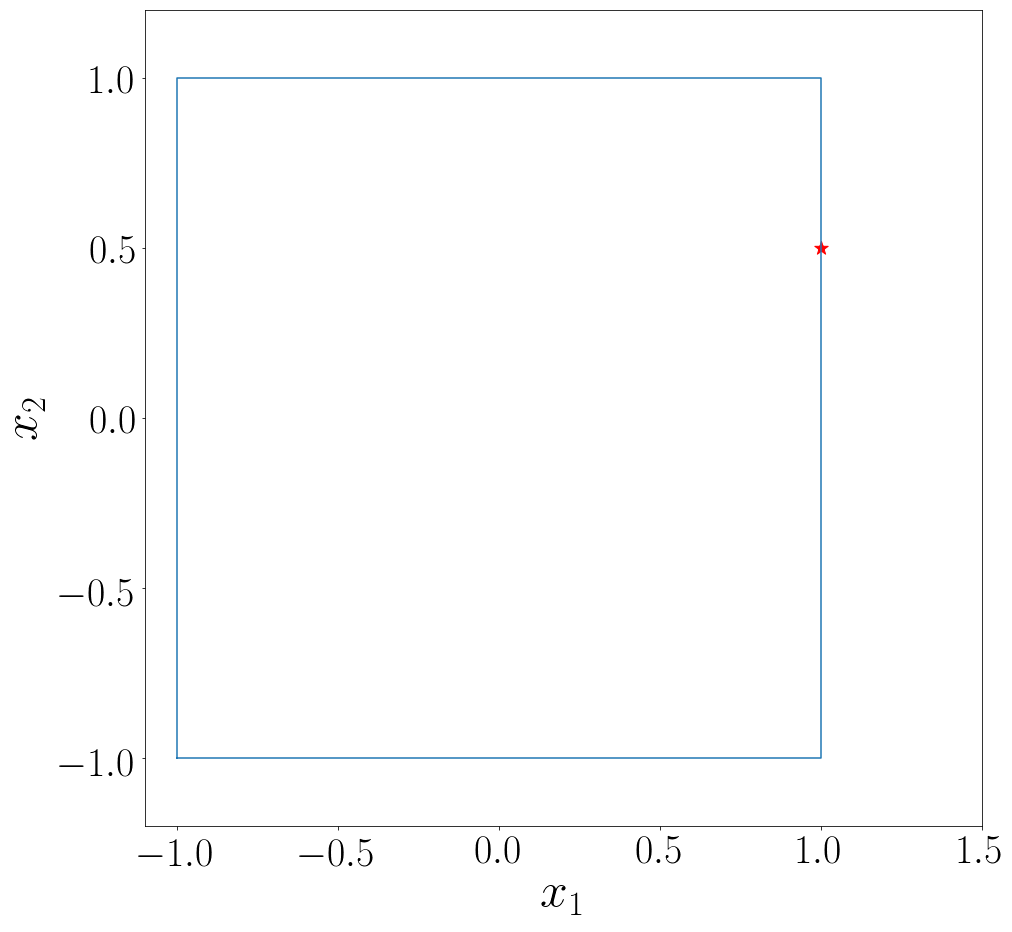

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


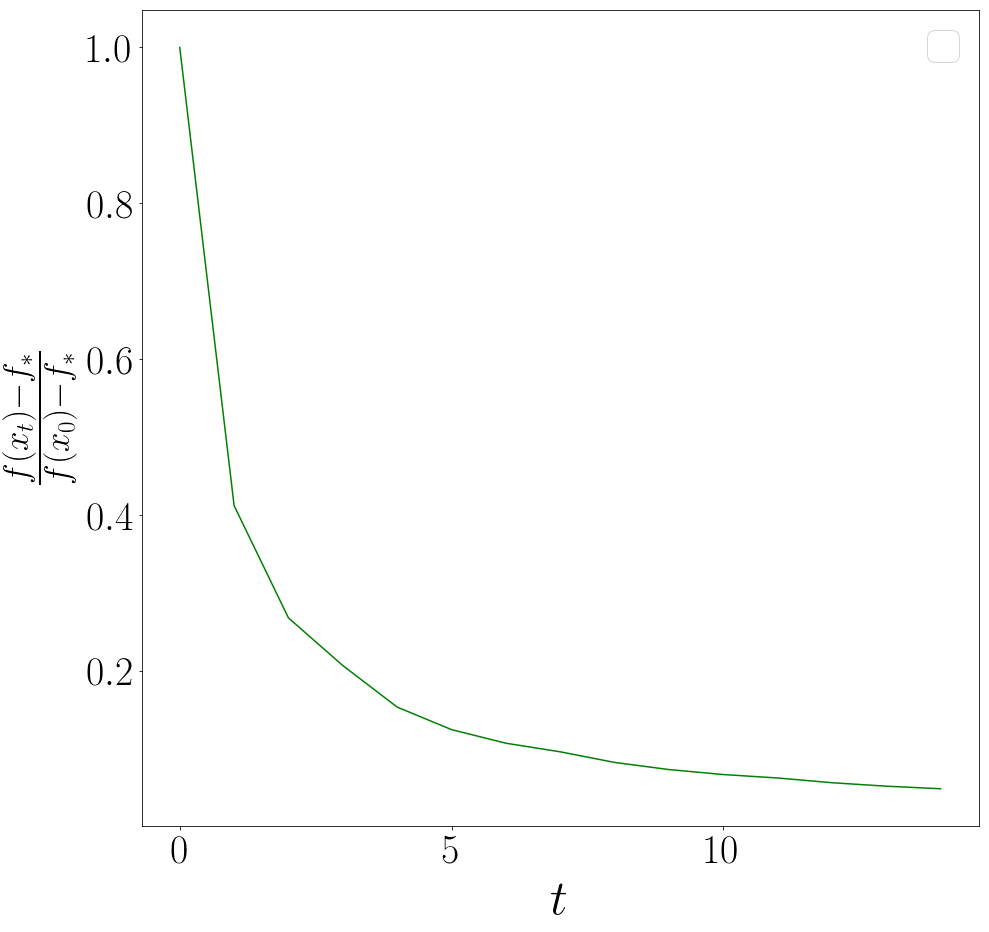

In [698]:
D = 2
exp2_1run = Exp(15, 0.1, 0.01, 1, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW, sigma = 0.01,center = 0, n0 = 50)

# Alternative approach

In [686]:
from cvxopt.solvers import conelp 

In [715]:
def solve_SOCP_DFS(A_est, b_est, sigma, eps, X_arr, grad):
    N = np.shape(X_arr)[0]
    #d = np.shape(A_est)[1]
    #d = np.shape(X_arr)[1]
    d = grad.size
    X_ext = np.vstack((X_arr.T,-1*np.ones(N))).T
    XX_inv = np.linalg.inv(X_ext.T.dot(X_ext))
    print np.shape(XX_inv), XX_inv
    phi = sigma*np.sqrt(chi2.ppf(1 - eps, d+1))
    #phi = sigma*norm.ppf(1 - eps, loc=0, scale=1)
    L = phi*np.linalg.cholesky(XX_inv)# + 1.e-12*np.eye(d+1))

    m = np.size(b_est)
    G = np.zeros((d, m*(d+2)))
    h = np.zeros(m*(d+2))
    c = grad
    for i in range(m):
        G.T[i*(d+2)] = A_est[i]
        G.T[i*(d+2)+1 : (i+1)*(d+2)] = L[0:-1].T
        h[i*(d+2)] = b_est[i]
        h[i*(d+2) + 1 : (i+1)*(d+2)] = L[-1].T
    G = G.T

    qs = []
    for i in range(m):
        qs.append(d+2)
    dims = {'l': 0, 'q': qs, 's': []}
    args = [matrix(c, tc = 'd'), matrix(G, tc = 'd'), matrix(h, tc = 'd'), dims]
    sol = conelp(*args)
    if 'optimal' not in sol['status']:
        return None
    plt.scatter(sol['x'][0],sol['x'][1], color = 'r')
    
    #print "status", sol.status
    return np.array(sol['x']).reshape((d,)), sol['status']

In [722]:
def check_safety(A_est, b_est, X_arr, sigma, x_new, eps):
    N = np.shape(X_arr)[0]
    m = np.shape(A_est)[0]
    #d = np.shape(A_est)[1]
    d = x_new.size
    phi = sigma*np.sqrt(chi2.ppf(1 - eps, d+1))
    #phi = sigma*np.sqrt(chi2.ppf(eps, d+1))
    x_avg_N = X_arr.T.dot(np.ones(N))
    x_avg = x_avg_N*1./N
    R_inv = X_arr.T.dot(X_arr) - 1./N*x_avg_N.reshape((d,1)).dot(x_avg_N.reshape((1,d)))
    def aRb(a,b):
        L = np.linalg.cholesky(R_inv)
        y = np.linalg.solve(L,a)
        z = np.linalg.solve(L,b)
        return y.dot(z)
    delta = np.zeros(m)
    for i in range(m):
        delta[i] = b_est[i] - A_est[i].dot(x_new)
    if phi*(1./N + aRb(x_new - x_avg, x_new - x_avg))**0.5 < np.min(delta):
        safety = 1
    else:
        safety = 0
    return safety  

In [723]:
def check_safety_2(A_est, b_est, X_arr, sigma, x_new, eps):
    N = np.shape(X_arr)[0]
    m = np.shape(A_est)[0]
    #d = np.shape(A_est)[1]
    d = x_new.size
    phi = sigma*np.sqrt(chi2.ppf(1 - eps, d+1))
    #phi = sigma*np.sqrt(chi2.ppf(eps, d+1))
    x_avg_N = X_arr.T.dot(np.ones(N))
    x_avg = x_avg_N*1./N
    R_inv = X_arr.T.dot(X_arr) - 1./N*x_avg_N.reshape((d,1)).dot(x_avg_N.reshape((1,d)))
#     def aRb(a,b):
#         L = np.linalg.cholesky(R_inv)
#         y = np.linalg.solve(L,a)
#         z = np.linalg.solve(L,b)
#         return y.dot(z)
    delta = np.zeros(m)
    for i in range(m):
        delta[i] = b_est[i] - A_est[i].dot(x_new)
    if phi*(1./N + (x_new - x_avg).dot(R_inv.dot(x_new - x_avg)))**0.5 < np.min(delta):
        safety = 1
    else:
        safety = 0
    return safety 

In [724]:
def bound_gamma(A_est, b_est, X_arr, sigma, x, s, eps, omega_case = 1):
    phi = sigma*np.sqrt(chi2.ppf(1 - eps, x.size+1))
    N = np.shape(X_arr)[0]
    m = np.shape(A_est)[0]
    d = np.shape(A_est)[1]
    Delta = s - x
    x_avg_N = X_arr.T.dot(np.ones(N))
    x_avg = x_avg_N*1./N
    R_inv = X_arr.T.dot(X_arr) - 1./N*x_avg_N.reshape((d,1)).dot(x_avg_N.reshape((1,d)))
    def aRb(a,b):
        L = np.linalg.cholesky(R_inv)
        y = np.linalg.solve(L,a)
        z = np.linalg.solve(L,b)
        return y.dot(z)
    delta = np.zeros(m)
    Gamma = np.zeros(m)
    case = np.zeros(m)
    
    for i in range(m):
        delta[i] = b_est[i] - A_est[i].dot(x)
        
        p = phi**2*aRb(Delta, Delta) - (A_est[i].dot(Delta))**2
        q =  2*(phi**2*aRb(Delta, x - x_avg) + delta[i]*A_est[i].dot(Delta))
        r = phi**2/N + phi**2*aRb(x - x_avg, x - x_avg) - delta[i]**2
        
        if p < 0 and q > 0 and r < 0:
            Gamma[i] = ((q**2 - 4*p*r)**0.5 - q)/(2*p)
            #print "case1", Gamma[i]
            
        elif p < 0 and q <= 0 and r < 0:
            Gamma[i] = 1.
            #print "case2", "1"
        elif p > 0 and r < 0:
             #max(
            Gamma[i] = ((q**2 - 4*p*r)**0.5 - q)/(2*p)
            case[i] = 2
            #print "case3",Gamma[i]
        else:
            Gamma[i] = 0.
            #print "case4", "0"
            
    gamma_max = np.min(Gamma)
    
    x_new  = x+gamma_max*Delta
    #print "gamma_max", gamma_max, "far",np.min(delta[i]),"safety", (phi**2/N + phi**2*aRb(x_new - x_avg, x_new - x_avg))**0.5 - np.min(b_est - A_est.dot(x_new))

    return gamma_max, np.min(delta)

In [725]:
def bound_gamma_2(A_est, b_est, X_arr, sigma, x, s, eps, omega_case = 1):
    phi = sigma*np.sqrt(chi2.ppf(1 - eps, x.size+1))
    N = np.shape(X_arr)[0]
    m = np.shape(A_est)[0]
    d = np.shape(A_est)[1]
    Delta = s - x
    x_avg_N = X_arr.T.dot(np.ones(N))
    x_avg = x_avg_N*1./N
    R_inv = X_arr.T.dot(X_arr) - 1./N*x_avg_N.reshape((d,1)).dot(x_avg_N.reshape((1,d)))
#     def aRb(a,b):
#         L = np.linalg.cholesky(R_inv)
#         y = np.linalg.solve(L,a)
#         z = np.linalg.solve(L,b)
#         return y.dot(z)
    delta = np.zeros(m)
    Gamma = np.zeros(m)
    case = np.zeros(m)
    
    for i in range(m):
        delta[i] = b_est[i] - A_est[i].dot(x)
        
        p = phi**2*Delta.dot(R_inv.dot(Delta)) - (A_est[i].dot(Delta))**2
        q =  2*(phi**2*Delta.dot(R_inv.dot(x - x_avg))+ delta[i]*A_est[i].dot(Delta))
        r = phi**2/N + phi**2*(x - x_avg).dot(R_inv.dot(x - x_avg)) - delta[i]**2
        
        if p < 0 and q > 0 and r < 0:
            Gamma[i] = ((q**2 - 4*p*r)**0.5 - q)/(2*p)
            
        elif p < 0 and q <= 0 and r < 0:
            Gamma[i] = 1.

        elif p > 0 and r < 0:
            Gamma[i] = ((q**2 - 4*p*r)**0.5 - q)/(2*p)
            case[i] = 2

        else:
            Gamma[i] = 0.
            
    gamma_max = np.min(Gamma)
    #x_new  = x+gamma_max*Delta
    return gamma_max, np.min(delta)

In [726]:
def Alternative(df, A, b, x_start, sigma, omega, gamma_init, n_0, T_max, eps, fopt, x_0, center, N = 0):
    X = []
    Y = []
    x = x_start
    #print x
    e = []
    err = np.zeros(T_max)
    delta = np.zeros(T_max)
    x_vec_0 = np.zeros(T_max)
    x_vec_1 = np.zeros(T_max)
    d = np.size(x_start)
    omega_t = np.zeros(2*d)
    counter = 0
    viol = 0.
    number_of_meas = 0.
    useless_steps = 0.
    gamma_seq = np.zeros(T_max)
    x_for_safety_1 = np.ones((100,2))
    x_for_safety_1.T[1] = np.arange(-1,1,0.02)
    x_for_safety_2 = np.ones((100,2))
    x_for_safety_2.T[0] = -1*np.arange(-1,1,0.02)
    x_for_safety_3 = -1*np.ones((100,2))
    x_for_safety_3.T[1] = -1*np.arange(-1,1,0.02)
    x_for_safety_4 = -1*np.ones((100,2))
    x_for_safety_4.T[0] = np.arange(-1,1,0.02)
    x_for_safety = np.vstack((x_for_safety_1,x_for_safety_2, x_for_safety_3,x_for_safety_4,(1,-1)))
    g_safety = np.zeros((401,2))
    gamma_s = np.zeros(401)
    #plt.figure(figsize=(15, 15))
    for i in range(d):
        e.append(np.eye(d)[i])
        e.append(-np.eye(d)[i])
    
    if N==0:
        n_t = int(n_0*T_max*(T_max+1)*np.log(T_max/2.))#n_0*(t+1)*int(np.log(t+3))
    else:
        n_t = N
    for i in range(n_t):
        x_measure = x + omega*e[i%(2*d)]
        if i < 2*d:
            plt.scatter(x_measure[0], x_measure[1], color = "green")

        make_and_add_measurement(A, b, X, Y, x_measure, sigma)
        number_of_meas = number_of_meas + 1.
        
    A_est, b_est = estimate_constraints(X, Y)
    X_arr = np.array(X)
    print np.shape(X_arr)
    for i in range(401):
        gamma_s[i] =  bound_gamma(A_est, b_est, X_arr, sigma, x, x_for_safety[i], eps, omega_case = 0)[0]
        g_safety[i] = (1 - gamma_s[i])*x + gamma_s[i]*x_for_safety[i]
    plt.plot(g_safety.T[0], g_safety.T[1], color = "orange")
    
    for t in range(T_max):
        x_vec_0[t] = x[0]
        x_vec_1[t] = x[1]
        err[t] = f(x, x_0) - fopt
        
        sol_DFS = solve_SOCP_DFS(A_est, b_est, sigma, eps, X_arr, df(x, x_0))
        s =  sol_DFS[0]
        plt.scatter(s[0], s[1], color = "magenta", marker = "v", s = 100)            
        gamma = 2./(t+2)
        
        x = (1 - gamma)*x + gamma*s
        viol = viol + violation(x, A, b)[0]
    print err[t]
    plt.plot(x_vec_0, x_vec_1, color = "red")#, marker ="*")
    viol_ratio = viol/T_max
    print number_of_meas
    non_conv = 0
    return x, err, delta, viol_ratio, gamma_seq, non_conv

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
2831.0 0


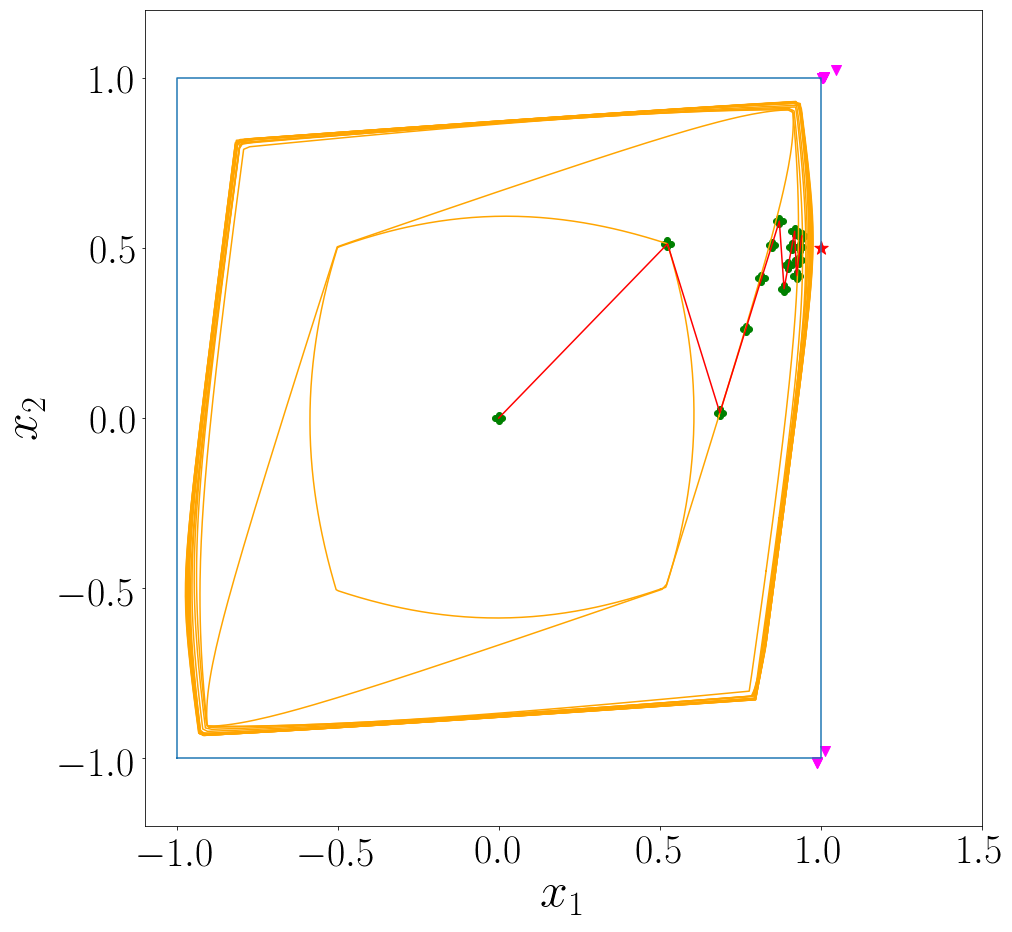

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


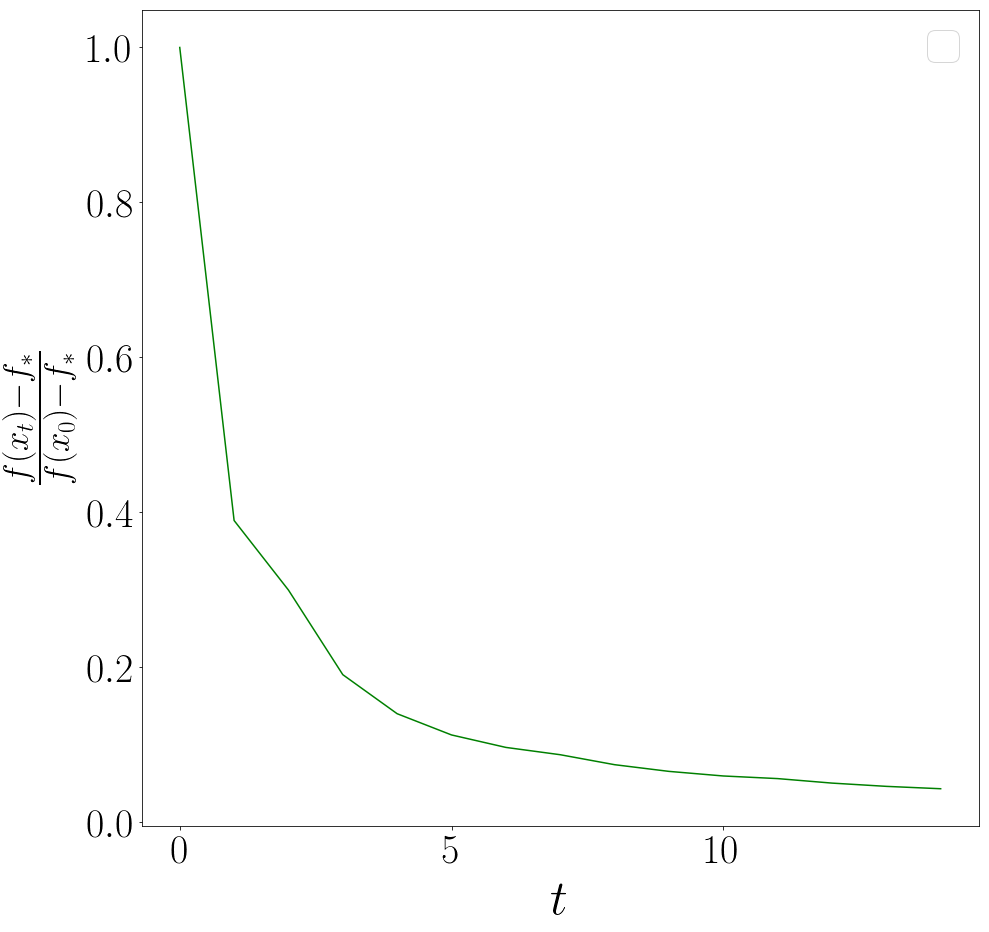

In [727]:
D = 2
exp2_1run = Exp(15, 0.1, 0.01, 1, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW_reduced, sigma = 0.1,center = 0, n0 = 50)

## Experiment: SCF trajectory

### SFW_Adaptive: need to compare with non-adaptive - convergence plot (20 realizations E = 20, D = 2,10,20). 

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
151.0 0
155.0 0
155.0 0
155.0 0
151.0 0
155.0 0
155.0 0
151.0 0
155.0 0
151.0 0
155.0 0
151.0 0
155.0 0
155.0 0
155.0 0
155.0 0
155.0 0
151.0 0
155.0 0
151.0 0


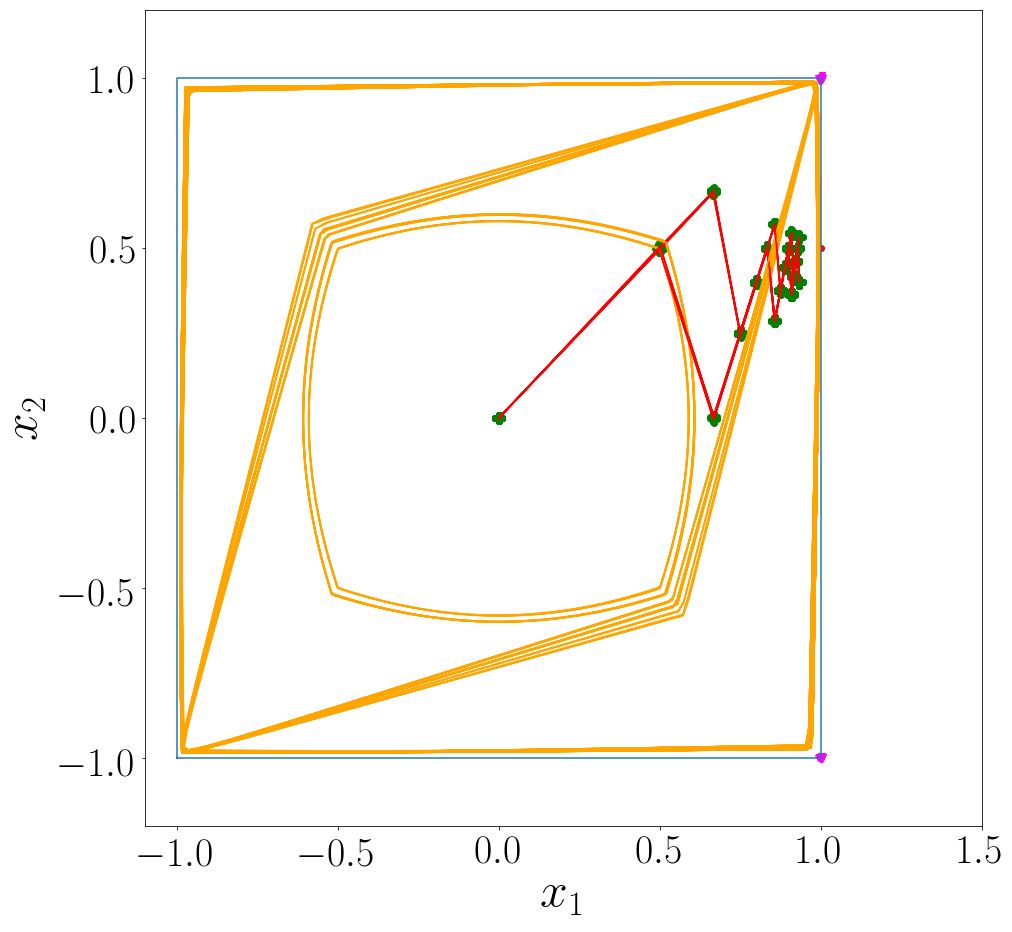

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


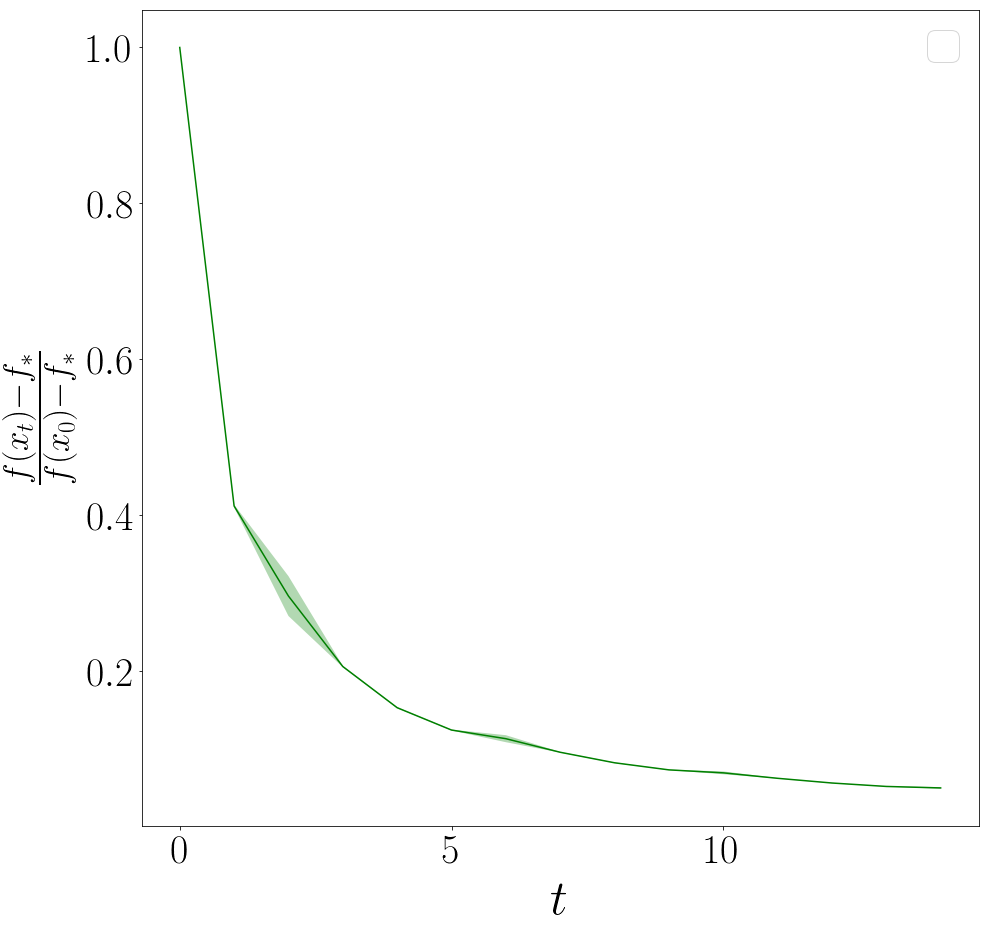

In [631]:
#max, eps, omega, E = 20, Enum, d = 4(optional), x_start(optional)
D = 2 #D = 4 D = 10
exp01 = Exp(15, 0.1, 0.01, 20, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW_reduced, sigma = 0.01, center = 0, n0 = 100)

     pcost       dcost       gap    pres   dres
 0: -1.9444e+00 -1.5056e+01  1e+01  5e-17  2e-16
 1: -2.2462e+00 -2.9357e+00  7e-01  3e-16  1e-16
 2: -2.3734e+00 -2.4136e+00  4e-02  2e-16  2e-17
 3: -2.3750e+00 -2.3755e+00  5e-04  3e-16  8e-17
 4: -2.3750e+00 -2.3750e+00  5e-06  4e-16  9e-17
 5: -2.3750e+00 -2.3750e+00  5e-08  2e-16  8e-17
Optimal solution found.
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0
391.0 0


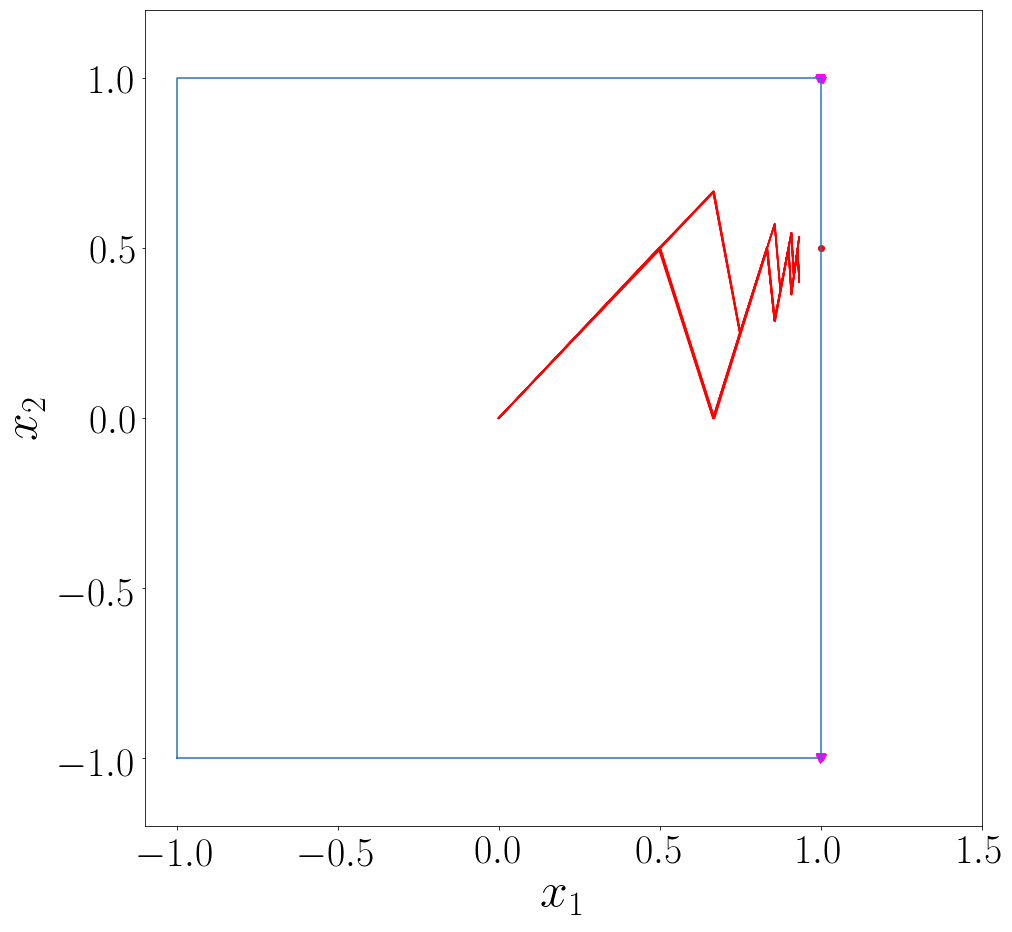

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


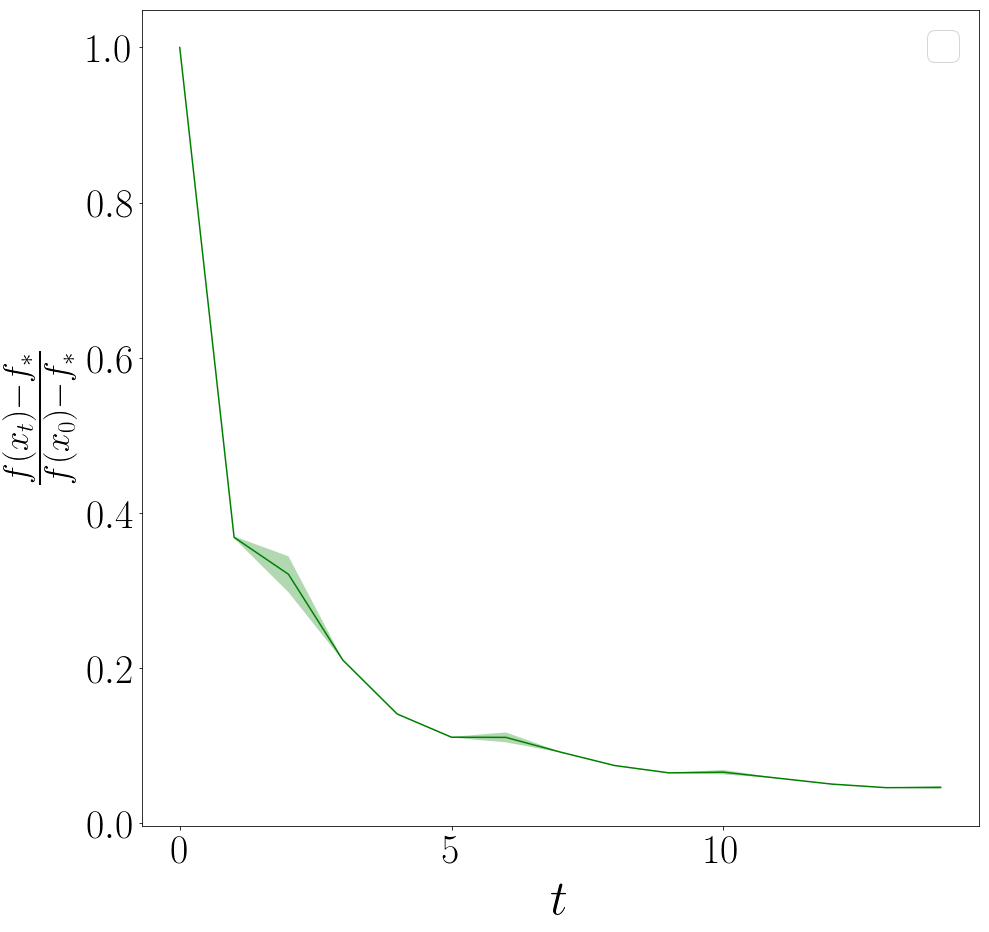

In [580]:
D = 4 #D = 4 D = 10
exp02 = Exp(15, 0.1, 0.01, 20, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW_reduced, sigma = 0.01, center = 0, n0 = 100)

     pcost       dcost       gap    pres   dres
 0: -2.3611e+00 -3.7139e+01  3e+01  5e-17  2e-16
 1: -2.8546e+00 -4.6792e+00  2e+00  3e-16  6e-16
 2: -3.1216e+00 -3.2423e+00  1e-01  1e-16  8e-17
 3: -3.1250e+00 -3.1265e+00  1e-03  9e-17  8e-17
 4: -3.1250e+00 -3.1250e+00  1e-05  1e-16  2e-17
 5: -3.1250e+00 -3.1250e+00  1e-07  1e-16  8e-17
Optimal solution found.
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0
2315.0 0


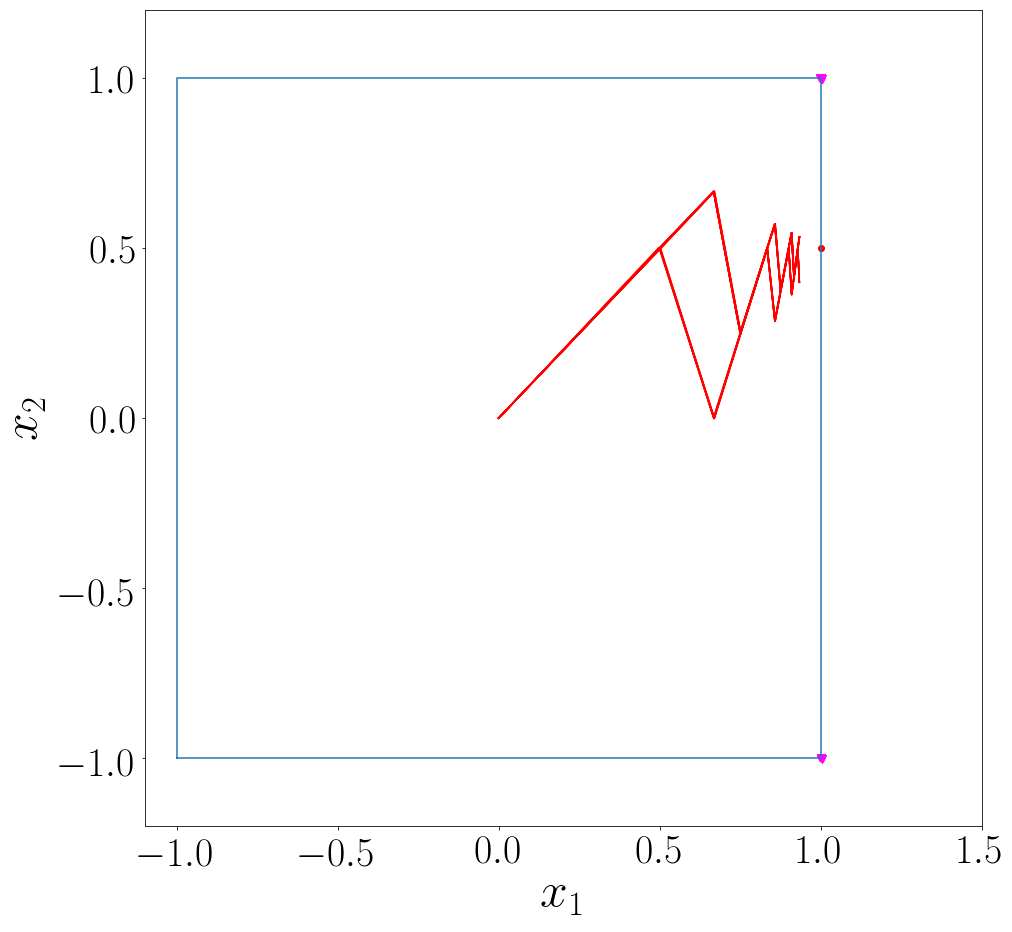

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


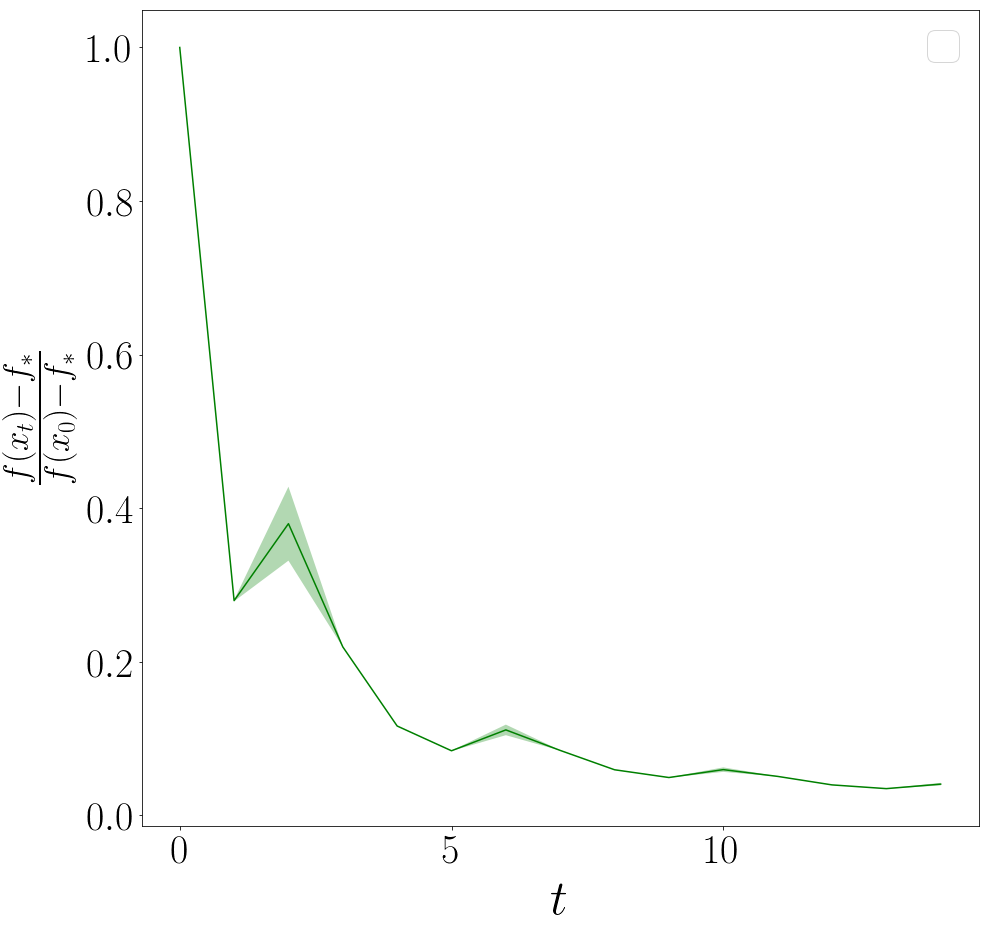

In [582]:
D = 10 #D = 4 D = 10
exp03 = Exp(15, 0.1, 0.01, 20, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW_reduced, sigma = 0.01, center = 0, n0 = 100)

### SCF to compare

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
6 1 2 0.4804530139182014 0.0006251388631170326 0.6096446465717504
30 2 2 1.206948960812582 0.0006251388631170326 1.4560960771727807
72 3 2 1.9218120556728056 0.0006251388631170326 2.6167745663298114
128 4 2 2.5902903939802346 0.0006251388631170326 4.054033048389732
200 5 2 3.210401995568401 0.0006251388631170326 5.737922531024241
284 6 2 3.7865663081964716 0.0006251388631170326 7.6445044051570985
378 7 2 4.324077125263812 0.0006251388631170326 9.754314345148007
482 8 2 4.827795843250328 0.0006251388631170326 12.0512404177858
596 9 2 5.301898110478399 0.0006251388631170326 14.521727626838384
718 10 2 5.749901739308773 0.0006251388631170326 17.154209331586962
848 11 2 6.174761

1132 13 2 6.964623588996019 0.0006251388631170326 25.92980920800735
1282 14 2 7.333535891689721 0.0006251388631170326 29.121921543455617
1440 15 2 7.687248222691222 0.0006251388631170326 32.43668053871433
8582.0 0
6 1 2 0.4804530139182014 0.0006251388631170326 0.6096446465717504
30 2 2 1.206948960812582 0.0006251388631170326 1.4560960771727807
72 3 2 1.9218120556728056 0.0006251388631170326 2.6167745663298114
128 4 2 2.5902903939802346 0.0006251388631170326 4.054033048389732
200 5 2 3.210401995568401 0.0006251388631170326 5.737922531024241
284 6 2 3.7865663081964716 0.0006251388631170326 7.6445044051570985
378 7 2 4.324077125263812 0.0006251388631170326 9.754314345148007
482 8 2 4.827795843250328 0.0006251388631170326 12.0512404177858
596 9 2 5.301898110478399 0.0006251388631170326 14.521727626838384
718 10 2 5.749901739308773 0.0006251388631170326 17.154209331586962
848 11 2 6.174761058160624 0.0006251388631170326 19.93869358980079
986 12 2 6.5789652063423505 0.0006251388631170326 22.

482 8 2 4.827795843250328 0.0006251388631170326 12.0512404177858
596 9 2 5.301898110478399 0.0006251388631170326 14.521727626838384
718 10 2 5.749901739308773 0.0006251388631170326 17.154209331586962
848 11 2 6.174761058160624 0.0006251388631170326 19.93869358980079
986 12 2 6.5789652063423505 0.0006251388631170326 22.866456294175876
1132 13 2 6.964623588996019 0.0006251388631170326 25.92980920800735
1282 14 2 7.333535891689721 0.0006251388631170326 29.121921543455617
1440 15 2 7.687248222691222 0.0006251388631170326 32.43668053871433
8582.0 0
6 1 2 0.4804530139182014 0.0006251388631170326 0.6096446465717504
30 2 2 1.206948960812582 0.0006251388631170326 1.4560960771727807
72 3 2 1.9218120556728056 0.0006251388631170326 2.6167745663298114
128 4 2 2.5902903939802346 0.0006251388631170326 4.054033048389732
200 5 2 3.210401995568401 0.0006251388631170326 5.737922531024241
284 6 2 3.7865663081964716 0.0006251388631170326 7.6445044051570985
378 7 2 4.324077125263812 0.0006251388631170326 9.

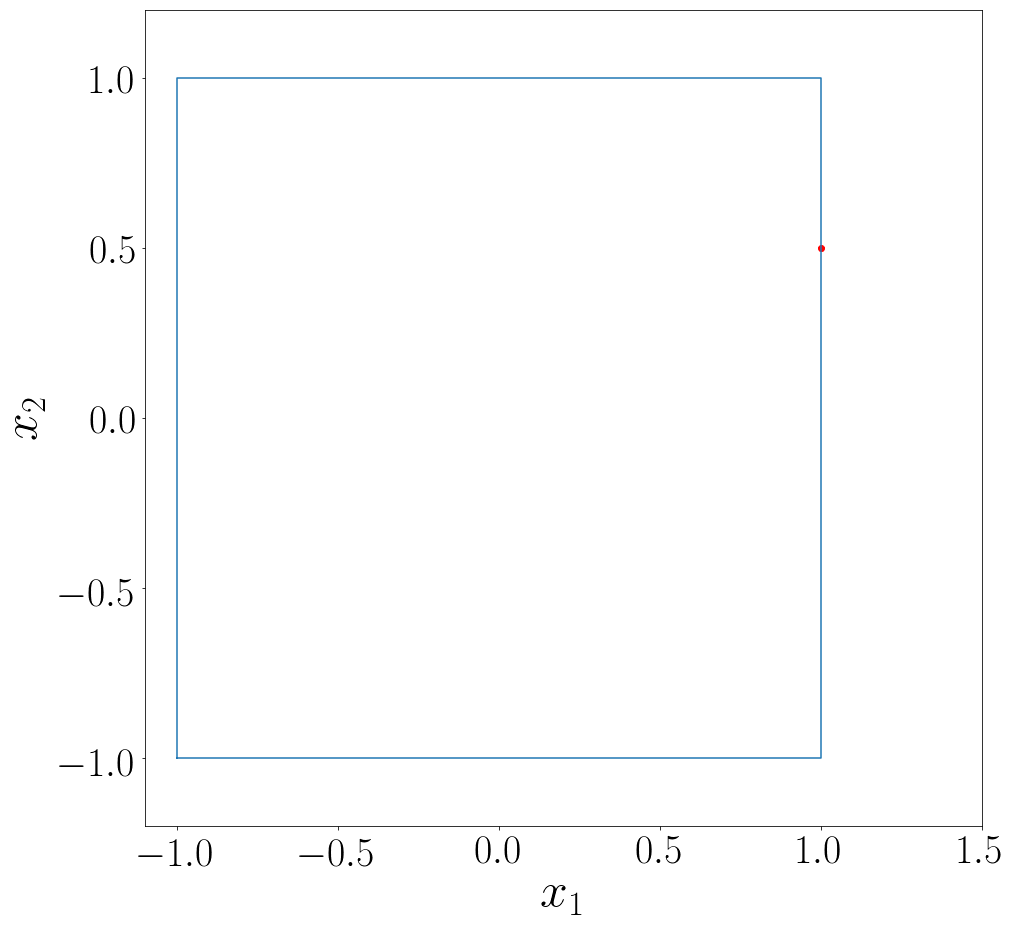

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


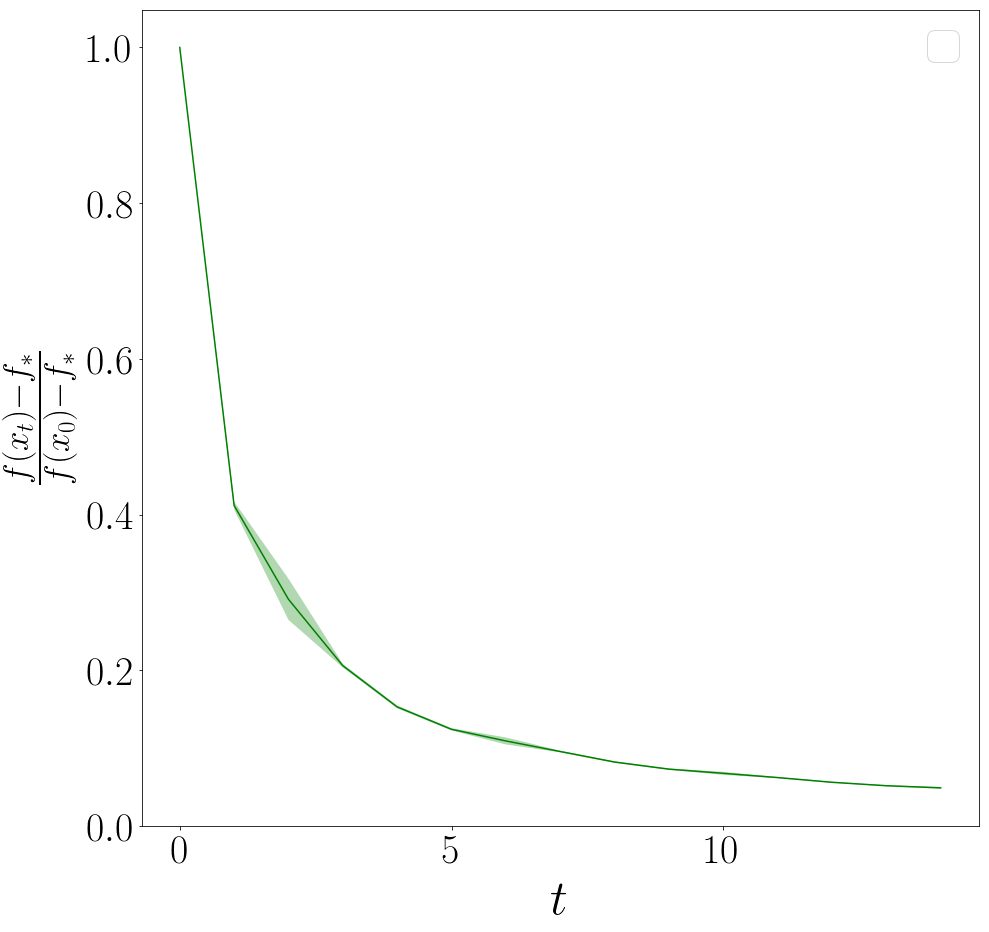

In [567]:
#max, eps, omega, E = 20, Enum, d = 4(optional), x_start(optional)

D = 2 #D = 4, D = 10
exp101 = Exp(15, 0.1, 0.01, 20, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW, sigma = 0.01, center = 0, n0 = 50)

     pcost       dcost       gap    pres   dres
 0: -1.9444e+00 -1.5056e+01  1e+01  5e-17  2e-16
 1: -2.2462e+00 -2.9357e+00  7e-01  3e-16  1e-16
 2: -2.3734e+00 -2.4136e+00  4e-02  2e-16  2e-17
 3: -2.3750e+00 -2.3755e+00  5e-04  3e-16  8e-17
 4: -2.3750e+00 -2.3750e+00  5e-06  4e-16  9e-17
 5: -2.3750e+00 -2.3750e+00  5e-08  2e-16  8e-17
Optimal solution found.
16 1 4 0.4804530139182014 0.0009236356899781118 1.8014863160806067
88 2 4 1.206948960812582 0.0009236356899781118 4.302731390616242
212 3 4 1.9218120556728056 0.0009236356899781118 7.732510405889553
380 4 4 2.5902903939802346 0.0009236356899781118 11.979577123627065
592 5 4 3.210401995568401 0.0009236356899781118 16.95543294031732
836 6 4 3.7865663081964716 0.0009236356899781118 22.58933980073527
1116 7 4 4.324077125263812 0.0009236356899781118 28.823781057289708
1424 8 4 4.827795843250328 0.0009236356899781118 35.61114630715212
1760 9 4 5.301898110478399 0.0009236356899781118 42.91138083916585
2124 10 4 5.749901739308773 0.00

4260 15 4 7.687248222691222 0.0009236356899781118 95.84966661836293
25368.0 0
16 1 4 0.4804530139182014 0.0009236356899781118 1.8014863160806067
88 2 4 1.206948960812582 0.0009236356899781118 4.302731390616242
212 3 4 1.9218120556728056 0.0009236356899781118 7.732510405889553
380 4 4 2.5902903939802346 0.0009236356899781118 11.979577123627065
592 5 4 3.210401995568401 0.0009236356899781118 16.95543294031732
836 6 4 3.7865663081964716 0.0009236356899781118 22.58933980073527
1116 7 4 4.324077125263812 0.0009236356899781118 28.823781057289708
1424 8 4 4.827795843250328 0.0009236356899781118 35.61114630715212
1760 9 4 5.301898110478399 0.0009236356899781118 42.91138083916585
2124 10 4 5.749901739308773 0.0009236356899781118 50.690305488312205
2508 11 4 6.174761058160624 0.0009236356899781118 58.91839428843866
2916 12 4 6.5789652063423505 0.0009236356899781118 67.56986769728803
3344 13 4 6.964623588996019 0.0009236356899781118 76.62200714709053
3792 14 4 7.333535891689721 0.0009236356899781

2124 10 4 5.749901739308773 0.0009236356899781118 50.690305488312205
2508 11 4 6.174761058160624 0.0009236356899781118 58.91839428843866
2916 12 4 6.5789652063423505 0.0009236356899781118 67.56986769728803
3344 13 4 6.964623588996019 0.0009236356899781118 76.62200714709053
3792 14 4 7.333535891689721 0.0009236356899781118 86.05462781232485
4260 15 4 7.687248222691222 0.0009236356899781118 95.84966661836293
25368.0 0
16 1 4 0.4804530139182014 0.0009236356899781118 1.8014863160806067
88 2 4 1.206948960812582 0.0009236356899781118 4.302731390616242
212 3 4 1.9218120556728056 0.0009236356899781118 7.732510405889553
380 4 4 2.5902903939802346 0.0009236356899781118 11.979577123627065
592 5 4 3.210401995568401 0.0009236356899781118 16.95543294031732
836 6 4 3.7865663081964716 0.0009236356899781118 22.58933980073527
1116 7 4 4.324077125263812 0.0009236356899781118 28.823781057289708
1424 8 4 4.827795843250328 0.0009236356899781118 35.61114630715212
1760 9 4 5.301898110478399 0.0009236356899781

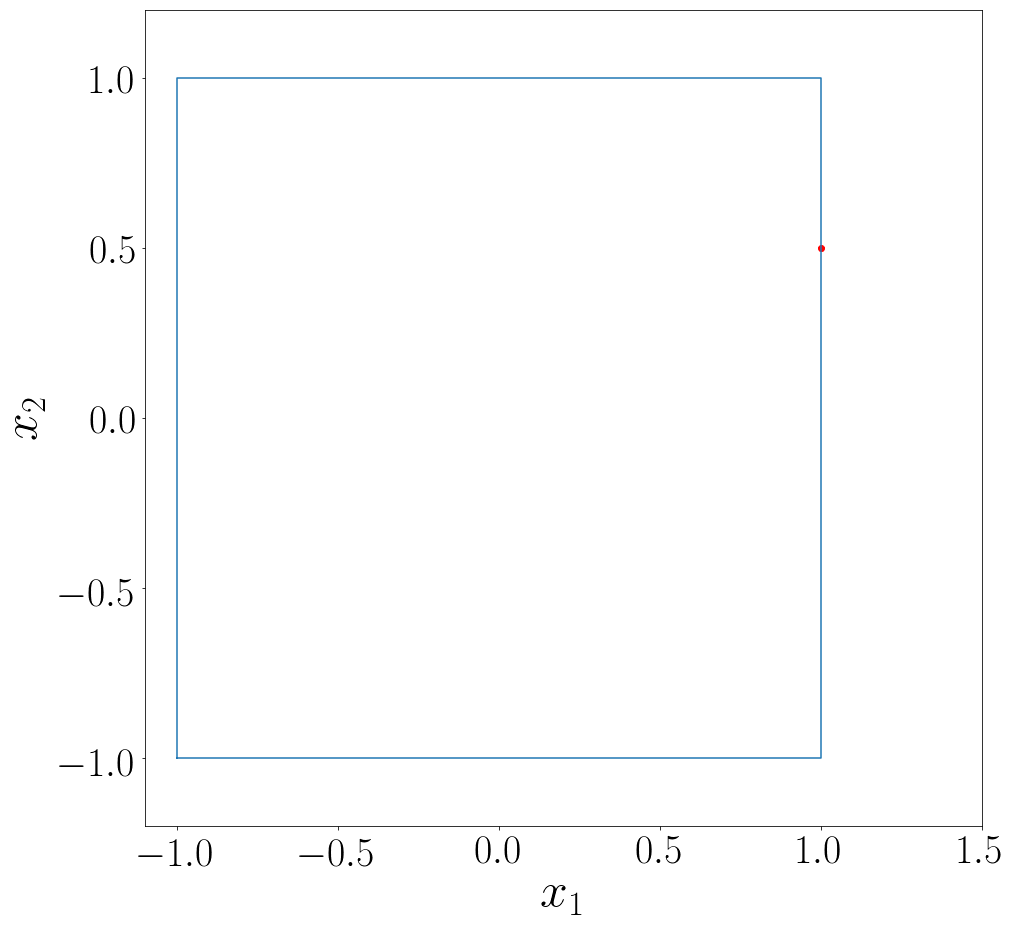

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


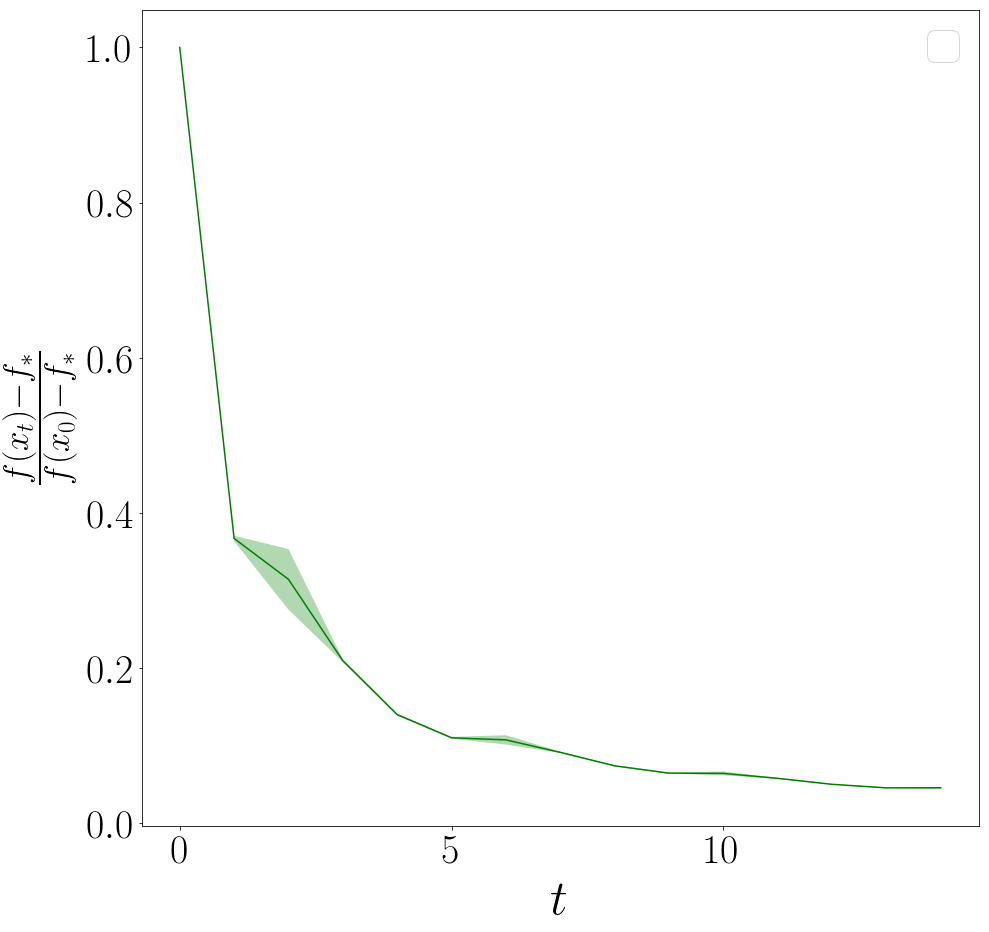

In [568]:
D = 4#D = 4, D = 10
exp102 = Exp(15, 0.1, 0.01, 20, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW, sigma = 0.01, center = 0, n0 = 50)

     pcost       dcost       gap    pres   dres
 0: -2.3611e+00 -3.7139e+01  3e+01  5e-17  2e-16
 1: -2.8546e+00 -4.6792e+00  2e+00  3e-16  6e-16
 2: -3.1216e+00 -3.2423e+00  1e-01  1e-16  8e-17
 3: -3.1250e+00 -3.1265e+00  1e-03  9e-17  8e-17
 4: -3.1250e+00 -3.1250e+00  1e-05  1e-16  2e-17
 5: -3.1250e+00 -3.1250e+00  1e-07  1e-16  8e-17
Optimal solution found.
80 1 10 0.4804530139182014 0.0017275008517500076 8.42342164560299
410 2 10 1.206948960812582 0.0017275008517500076 20.11878769625392
990 3 10 1.9218120556728056 0.0017275008517500076 36.155809203996206
1790 4 10 2.5902903939802346 0.0017275008517500076 56.0143190362238
2770 5 10 3.210401995568401 0.0017275008517500076 79.28051385412151
3920 6 10 3.7865663081964716 0.0017275008517500076 105.62363540533306
5220 7 10 4.324077125263812 0.0017275008517500076 134.77474632964783
6670 8 10 4.827795843250328 0.0017275008517500076 166.5112290616912
8240 9 10 5.301898110478399 0.0017275008517500076 200.64579507312206
9930 10 10 5.7499017

8240 9 10 5.301898110478399 0.0017275008517500076 200.64579507312206
9930 10 10 5.749901739308773 0.0017275008517500076 237.0186288183672
11730 11 10 6.174761058160624 0.0017275008517500076 275.4916722615834
13630 12 10 6.5789652063423505 0.0017275008517500076 315.94438496217754
15640 13 10 6.964623588996019 0.0017275008517500076 358.27053903831614
17730 14 10 7.333535891689721 0.0017275008517500076 402.3757539250784
19920 15 10 7.687248222691222 0.0017275008517500076 448.17556997797516
118670.0 0
80 1 10 0.4804530139182014 0.0017275008517500076 8.42342164560299
410 2 10 1.206948960812582 0.0017275008517500076 20.11878769625392
990 3 10 1.9218120556728056 0.0017275008517500076 36.155809203996206
1790 4 10 2.5902903939802346 0.0017275008517500076 56.0143190362238
2770 5 10 3.210401995568401 0.0017275008517500076 79.28051385412151
3920 6 10 3.7865663081964716 0.0017275008517500076 105.62363540533306
5220 7 10 4.324077125263812 0.0017275008517500076 134.77474632964783
6670 8 10 4.82779584

8240 9 10 5.301898110478399 0.0017275008517500076 200.64579507312206
9930 10 10 5.749901739308773 0.0017275008517500076 237.0186288183672
11730 11 10 6.174761058160624 0.0017275008517500076 275.4916722615834
13630 12 10 6.5789652063423505 0.0017275008517500076 315.94438496217754
15640 13 10 6.964623588996019 0.0017275008517500076 358.27053903831614
17730 14 10 7.333535891689721 0.0017275008517500076 402.3757539250784
19920 15 10 7.687248222691222 0.0017275008517500076 448.17556997797516
118670.0 0
80 1 10 0.4804530139182014 0.0017275008517500076 8.42342164560299
410 2 10 1.206948960812582 0.0017275008517500076 20.11878769625392
990 3 10 1.9218120556728056 0.0017275008517500076 36.155809203996206
1790 4 10 2.5902903939802346 0.0017275008517500076 56.0143190362238
2770 5 10 3.210401995568401 0.0017275008517500076 79.28051385412151
3920 6 10 3.7865663081964716 0.0017275008517500076 105.62363540533306
5220 7 10 4.324077125263812 0.0017275008517500076 134.77474632964783
6670 8 10 4.82779584

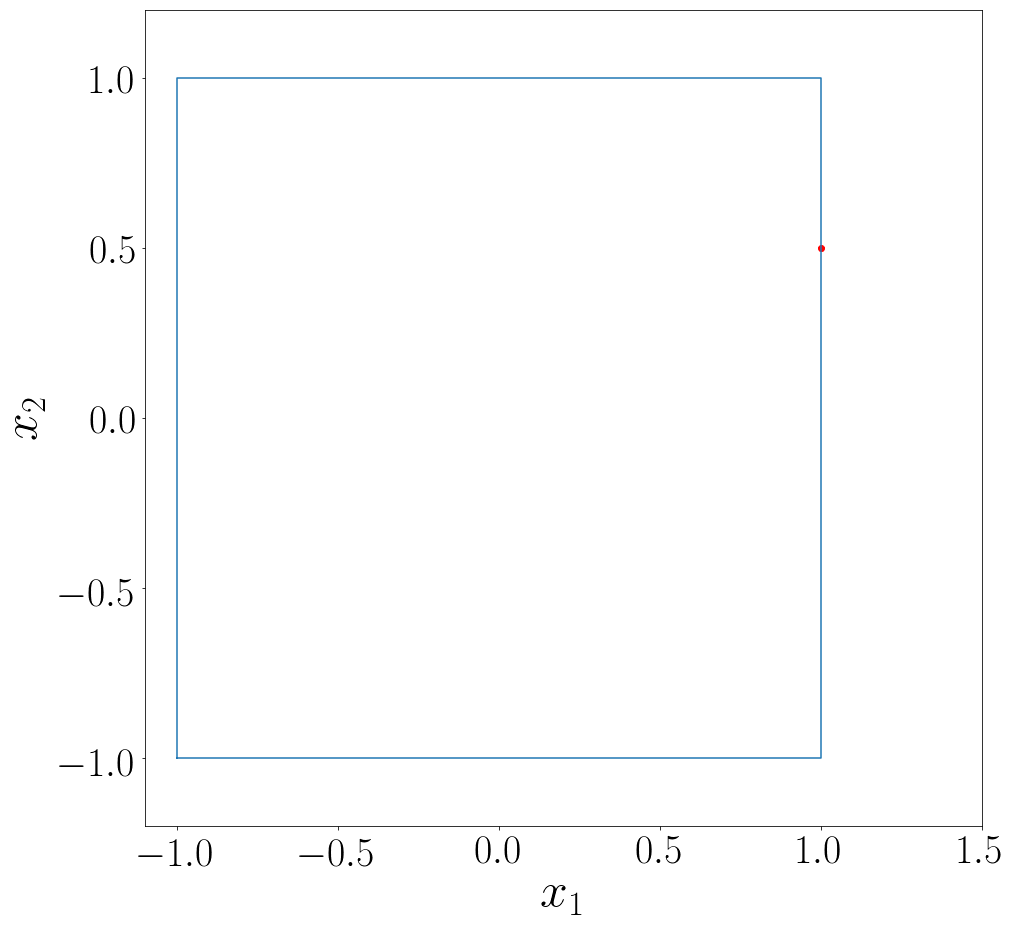

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


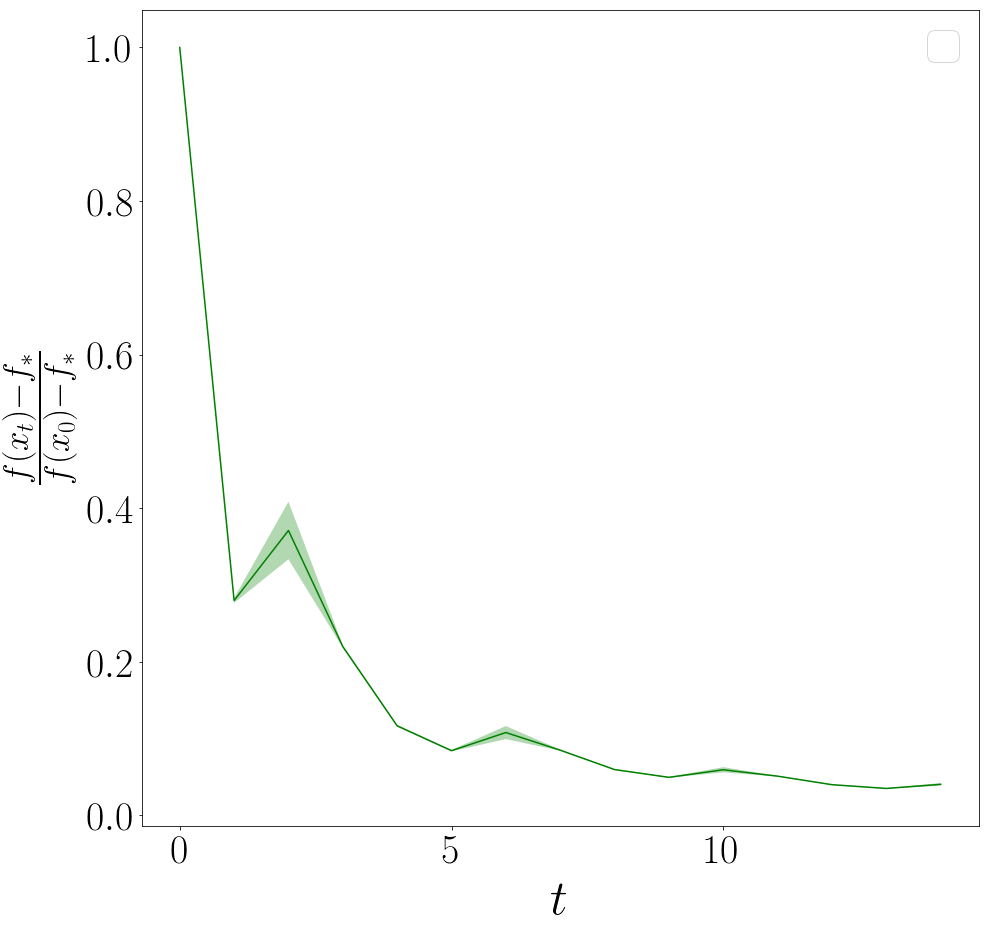

In [583]:
D = 10#D = 4, D = 10
exp103 = Exp(15, 0.1, 0.01, 20, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW, sigma = 0.01, center = 0, n0 = 50)

## Comparison of Alternative and SFW approaches (convergence rates)

### SFW_Adaptive ( separately - trajectory plot.)

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
2831.0 0
2615.0 0
2715.0 0
2559.0 0
2563.0 0
3179.0 0
3091.0 0
2979.0 0
2783.0 0
2559.0 0
2747.0 0
2875.0 0
2407.0 0
2699.0 0
2863.0 0
3011.0 0
2727.0 0
2791.0 0
2707.0 0
2475.0 0
2507.0 0
2663.0 0
2643.0 0
2603.0 0
2687.0 0
2639.0 0
2611.0 0
2559.0 0
2659.0 0
2719.0 0
2415.0 0
2595.0 0
2611.0 0
2475.0 0
2851.0 0
2587.0 0
2555.0 0
2547.0 0
2939.0 0
2415.0 0
2571.0 0
2519.0 0
2391.0 0
3115.0 0
2691.0 0
2487.0 0
2555.0 0
2635.0 0
2703.0 0
2595.0 0
2895.0 0
3051.0 0
2671.0 0
2699.0 0
3347.0 0
2851.0 0
2687.0 0
2423.0 0
2551.0 0
2687.0 0
2835.0 0
2523.0 0
2591.0 0
2499.0 0
2803.0 0
3067.0 0
2647.0 0
2643.0 0
2491.0 0
2819.0 0
2755.0 0
2527.0 0
2651.0 0
2539.0 0
2551.0 0
2651.0 0

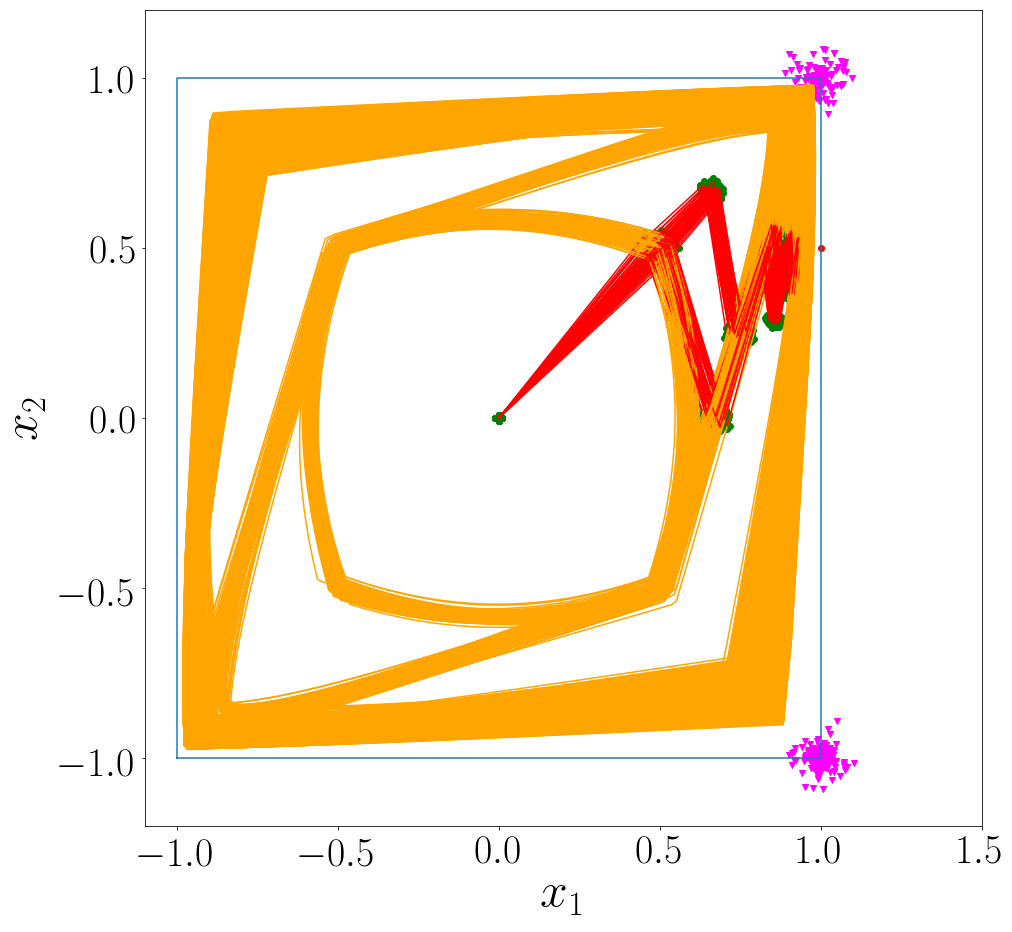

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


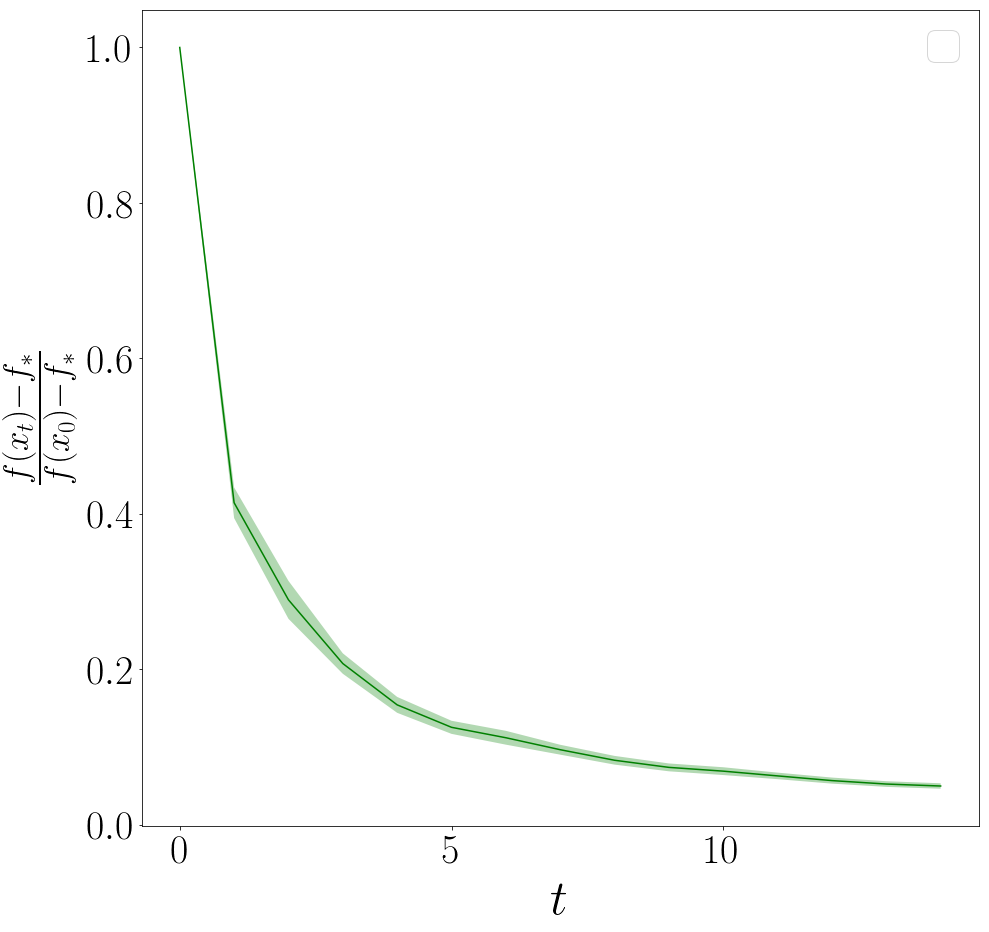

In [629]:
#max, eps, omega, E, Enum, d = 4(optional), x_start(optional)
D = 2
exp2 = Exp(15, 0.1, 0.01, 100, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW_reduced, sigma = 0.1,center = 0, n0 = 50)

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
2831.0 0
2615.0 0
2715.0 0
2559.0 0
2563.0 0
3179.0 0
3091.0 0
2979.0 0
2783.0 0
2559.0 0


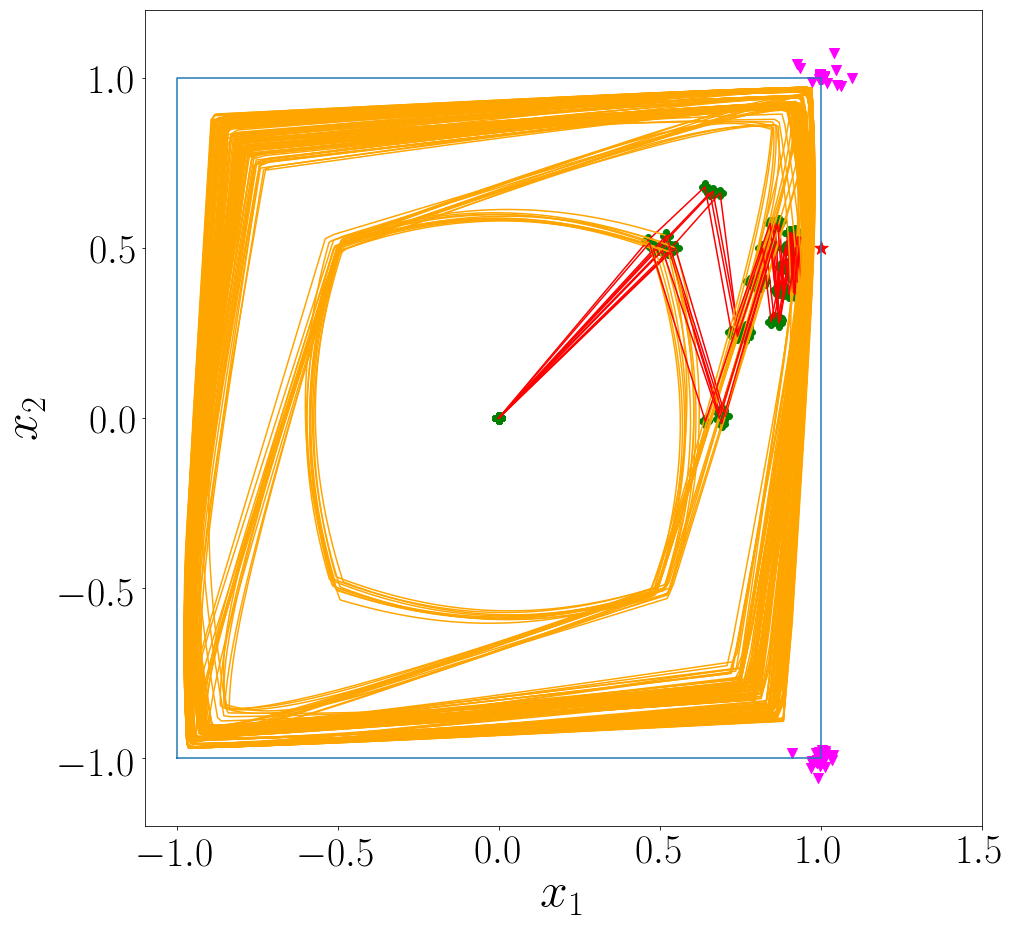

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


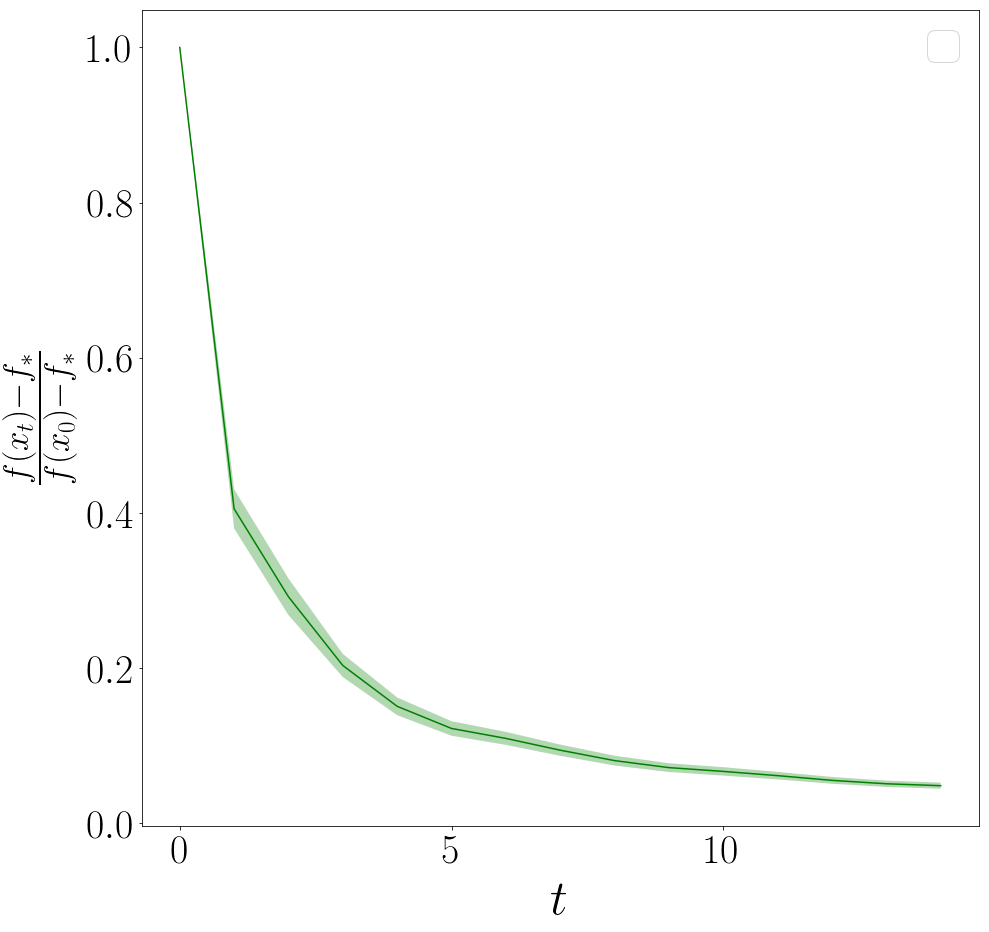

In [728]:
D = 2
exp22 = Exp(15, 0.1, 0.01, 10, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW_reduced, sigma = 0.1,center = 0, n0 = 50)

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
598 1 2 0.4804530139182014 0.06251388631170327 60.96446465717505
3006 2 2 1.206948960812582 0.06251388631170327 145.6096077172781
7180 3 2 1.9218120556728056 0.06251388631170327 261.67745663298115
12906 4 2 2.5902903939802346 0.06251388631170327 405.40330483897316
19994 5 2 3.210401995568401 0.06251388631170327 573.7922531024241
28300 6 2 3.7865663081964716 0.06251388631170327 764.4504405157098
37704 7 2 4.324077125263812 0.06251388631170327 975.4314345148008
48110 8 2 4.827795843250328 0.06251388631170327 1205.12404177858
59440 9 2 5.301898110478399 0.06251388631170327 1452.1727626838385
71624 10 2 5.749901739308773 0.06251388631170327 1715.420933158696
84610 11 2 6.1747610

112784 13 2 6.964623588996019 0.06251388631170327 2592.980920800735
127894 14 2 7.333535891689721 0.06251388631170327 2912.192154345562
143638 15 2 7.687248222691222 0.06251388631170327 3243.668053871433
856132.0 0
598 1 2 0.4804530139182014 0.06251388631170327 60.96446465717505
3006 2 2 1.206948960812582 0.06251388631170327 145.6096077172781
7180 3 2 1.9218120556728056 0.06251388631170327 261.67745663298115
12906 4 2 2.5902903939802346 0.06251388631170327 405.40330483897316
19994 5 2 3.210401995568401 0.06251388631170327 573.7922531024241
28300 6 2 3.7865663081964716 0.06251388631170327 764.4504405157098
37704 7 2 4.324077125263812 0.06251388631170327 975.4314345148008
48110 8 2 4.827795843250328 0.06251388631170327 1205.12404177858
59440 9 2 5.301898110478399 0.06251388631170327 1452.1727626838385
71624 10 2 5.749901739308773 0.06251388631170327 1715.420933158696
84610 11 2 6.174761058160624 0.06251388631170327 1993.8693589800794
98344 12 2 6.5789652063423505 0.06251388631170327 2286

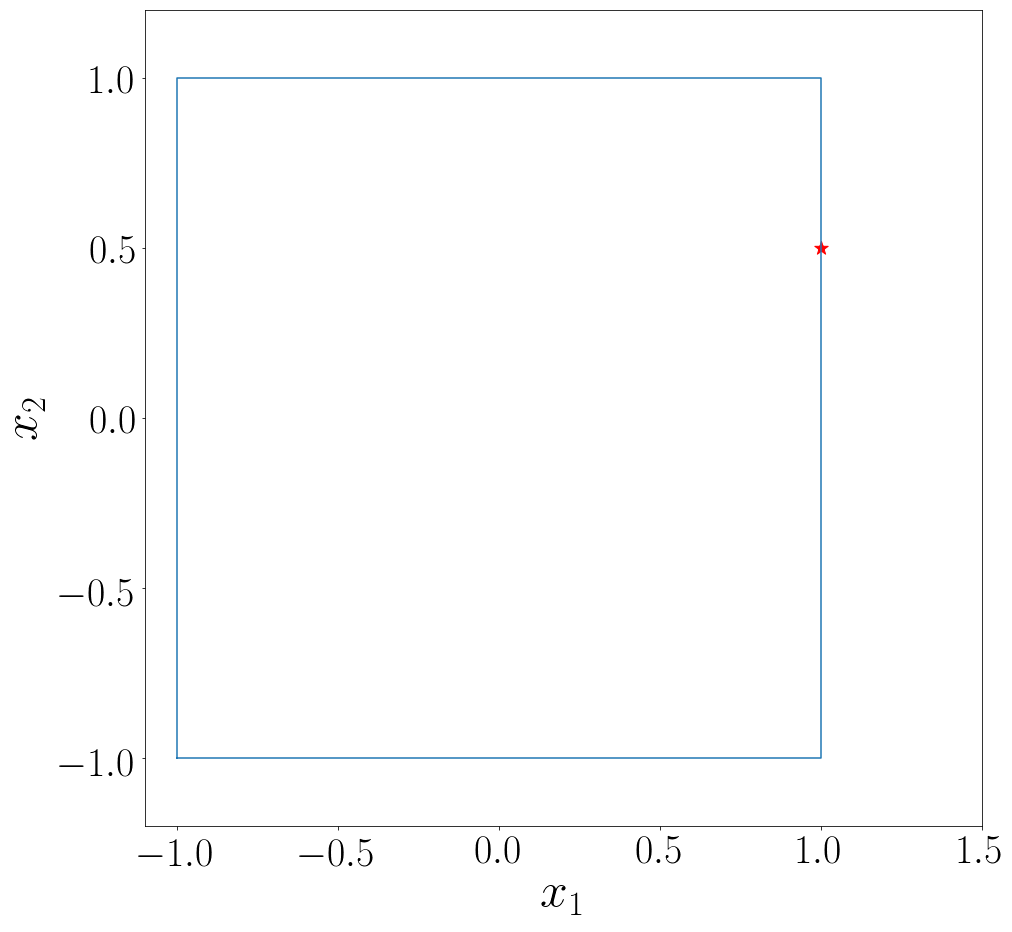

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


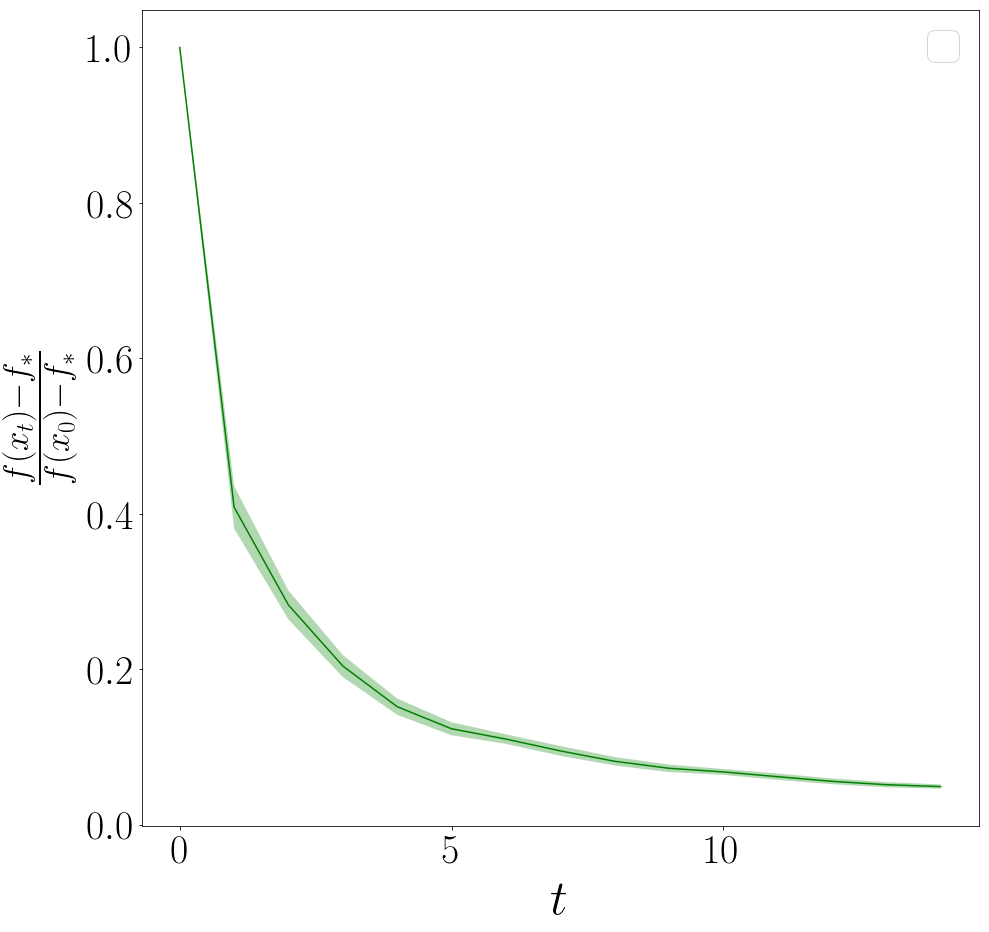

In [730]:
D = 2
exp33 = Exp(15, 0.1, 0.01, 10, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW, sigma = 0.1,center = 0, n0 = 50)

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
2831.0 0


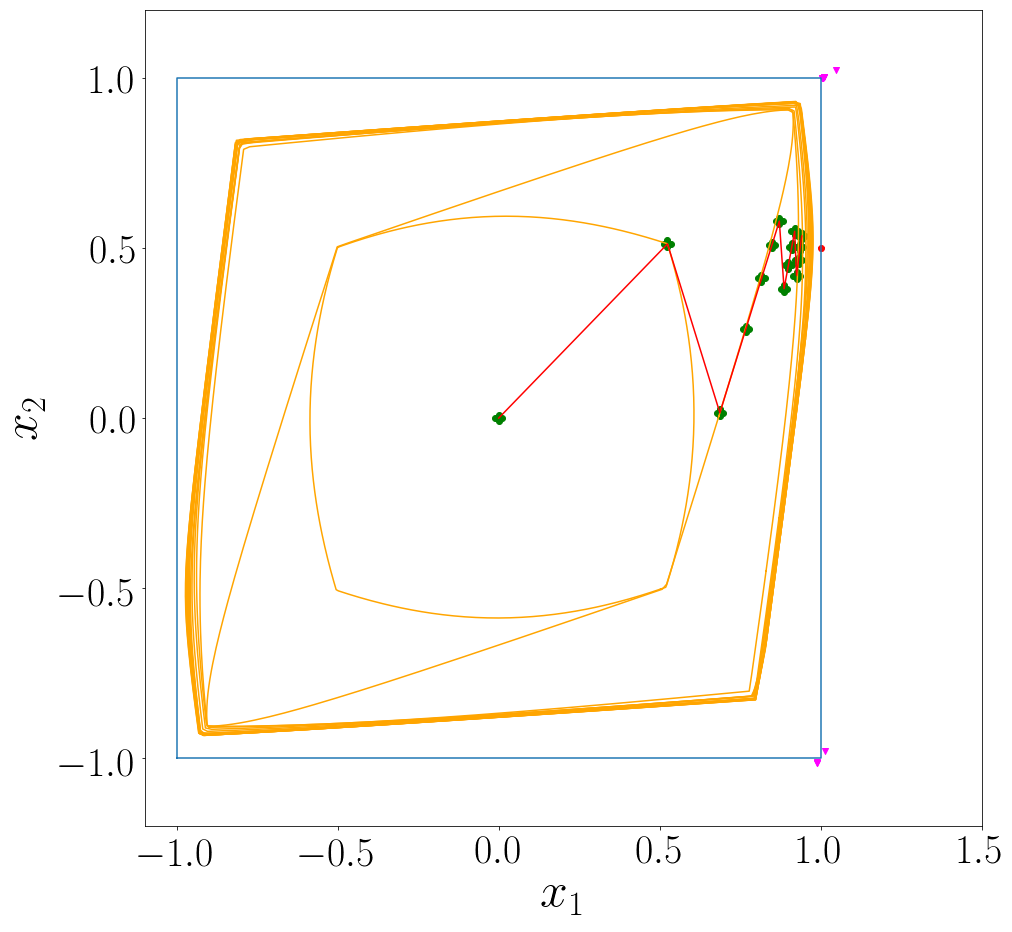

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


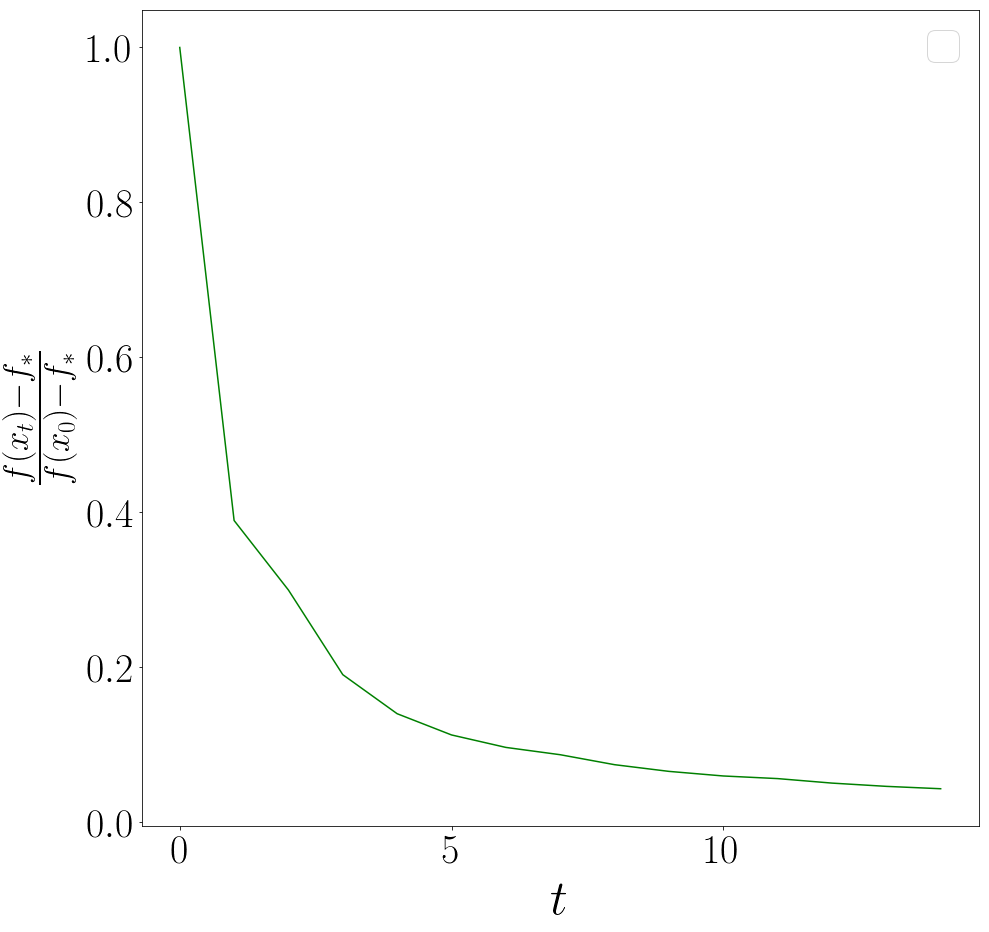

In [621]:
D = 2
exp2_1run = Exp(15, 0.1, 0.01, 1, 1, d = D,  x_start = 0.*np.ones(D), method = SCFW_reduced, sigma = 0.1,center = 0, n0 = 50)

### Alternative approach experiment

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
(2831, 2)
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.9548e-02 -8.5003e+00  9e+00  6e-17  6e-02  1e+00
 1: -1.3349e+00 -2.4574e+00  1e+00  1e-15  8e-03  1e-01
 2: -1.5925e+00 -1.6843e+00  9e-02  7e-16  7e-04  1e-02
 3: -1.6141e+00 -1.6255e+00  1e-02  7e-16  8e-05  2e-03
 4: -1.6143e+00 -1.6145e+00  2e-04  4e-16  1e-06  3e-05
 5: -1.6143e+00 -1.6143e+00  4e-06  3e-15  3e-08  6e-07
 6: -1.6143e+00 -1.6143e+00  1e-07  3e-14  7e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5613e-03 -8.4072e+00  8e+00  2e-18  3e-02  1e+00
 1: -1.3059e+00 -2.3771e+00  1e+00  8e-16  3e-03  1e-01
 2: -1.5418e+00 -1.6241e+00  8e-02  4e-16  3e-04  1e-02
 3: -1.5596e+00 -1.5690e+00  1e-02  5e-16  3e-05  1e-03
 4: -1.5597e+00 -1.5599e+00  1e-04  2e-15  4e-07  2e-05
 5: -1.5597e+00 -1.5597e+00  1e-06  5e-15  4e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.0420e-04 -7.3971e+00  7e+00  2e-18  3e-02  1e+00
 1: -8.7127e-01 -1.9108e+00  1e+00  6e-16  4e-03  1e-01
 2: -1.1498e+00 -1.2177e+00  7e-02  5e-16  3e-04  1e-02
 3: -1.1660e+00 -1.1680e+00  2e-03  4e-16  8e-06  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.9812e-02 -8.4384e+00  8e+00  6e-17  8e-02  1e+00
 1: -1.3081e+00 -2.3914e+00  1e+00  1e-15  1e-02  1e-01
 2: -1.5616e+00 -1.6497e+00  9e-02  4e-16  8e-04  1e-02
 3: -1.5830e+00 -1.6020e+00  2e-02  5e-16  2e-04  3e-03
 4: -1.5832e+00 -1.5852e+00  2e-03  2e-15  2e-05  3e-04
 5: -1.5836e+00 -1.5839e+00  3e-04  3e-15  3e-06  5e-05
 6: -1.5836e+00 -1.5836e+00  2e-05  2e-16  2e-07  4e-06
 7: -1.5836e+00 -1.5836e+00  2e-06  4e-15  2e-08  3e-07
 8: -1.5836e+00 -1.5836e+00  5e-08  1e-13  5e-10  9e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.8122e-02 -7.4189e+00  7e+00  6e-17  9e-02  1e+00
 1: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -6.3510e-02 -8.4722e+00  8e+00  4e-18  8e-02  1e+00
 1: -1.3509e+00 -2.3434e+00  1e+00  1e-15  9e-03  1e-01
 2: -1.5578e+00 -1.6299e+00  7e-02  5e-16  7e-04  9e-03
 3: -1.5724e+00 -1.5810e+00  8e-03  8e-16  8e-05  1e-03
 4: -1.5725e+00 -1.5726e+00  1e-04  1e-15  1e-06  2e-05
 5: -1.5725e+00 -1.5725e+00  1e-06  5e-15  1e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.7562e-02 -7.4403e+00  7e+00  4e-18  9e-02  1e+00
 1: -9.0671e-01 -1.9027e+00  1e+00  9e-16  1e-02  1e-01
 2: -1.1603e+00 -1.2245e+00  6e-02  4e-16  8e-04  9e-03
 3: -1.1748e+00 -1.1767e+00  2e-03  7e-16  2e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.8118e-03 -8.3161e+00  8e+00  4e-19  8e-03  1e+00
 1: -1.2714e+00 -2.3065e+00  1e+00  5e-16  1e-03  1e-01
 2: -1.4955e+00 -1.5633e+00  7e-02  8e-16  7e-05  9e-03
 3: -1.5096e+00 -1.5134e+00  4e-03  5e-16  4e-06  5e-04
 4: -1.5097e+00 -1.5098e+00  6e-05  2e-15  6e-08  8e-06
 5: -1.5097e+00 -1.5097e+00  5e-06  7e-15  5e-09  7e-07
 6: -1.5097e+00 -1.5097e+00  8e-08  5e-14  8e-11  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.6680e-03 -7.3490e+00  7e+00  4e-19  1e-02  1e+00
 1: -8.5535e-01 -1.8906e+00  1e+00  9e-16  1e-03  1e-01
 2: -1.1340e+00 -1.1940e+00  6e-02  9e-16  8e-05  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  8.0428e-03 -8.5625e+00  9e+00  8e-17  6e-02  1e+00
 1: -1.3463e+00 -2.4648e+00  1e+00  1e-15  8e-03  1e-01
 2: -1.5976e+00 -1.6924e+00  1e-01  5e-16  7e-04  1e-02
 3: -1.6196e+00 -1.6318e+00  1e-02  7e-16  9e-05  2e-03
 4: -1.6198e+00 -1.6200e+00  2e-04  5e-16  1e-06  3e-05
 5: -1.6199e+00 -1.6199e+00  3e-06  7e-15  3e-08  5e-07
 6: -1.6199e+00 -1.6199e+00  8e-08  3e-13  6e-10  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8631e-03 -7.4685e+00  7e+00  8e-17  7e-02  1e+00
 1: -8.7983e-01 -1.9538e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1760e+00 -1.2463e+00  7e-02  4e-16  7e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.8296e-02 -8.5128e+00  9e+00  6e-17  6e-02  1e+00
 1: -1.3460e+00 -2.4349e+00  1e+00  2e-15  8e-03  1e-01
 2: -1.5940e+00 -1.6798e+00  9e-02  1e-15  7e-04  1e-02
 3: -1.6139e+00 -1.6237e+00  1e-02  1e-15  8e-05  1e-03
 4: -1.6141e+00 -1.6142e+00  1e-04  8e-16  1e-06  2e-05
 5: -1.6141e+00 -1.6141e+00  1e-06  8e-15  1e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1543e-02 -7.4354e+00  7e+00  6e-17  8e-02  1e+00
 1: -8.6707e-01 -1.9577e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1778e+00 -1.2418e+00  6e-02  6e-16  6e-04  9e-03
 3: -1.1918e+00 -1.1936e+00  2e-03  4e-16  2e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  8.3704e-02 -8.4523e+00  9e+00  6e-17  1e-01  1e+00
 1: -1.3130e+00 -2.4834e+00  1e+00  2e-16  1e-02  2e-01
 2: -1.5879e+00 -1.6840e+00  1e-01  5e-16  1e-03  1e-02
 3: -1.6098e+00 -1.6203e+00  1e-02  5e-16  1e-04  1e-03
 4: -1.6100e+00 -1.6101e+00  1e-04  1e-15  2e-06  2e-05
 5: -1.6100e+00 -1.6100e+00  1e-06  2e-15  2e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  6.1588e-02 -7.3993e+00  7e+00  6e-17  1e-01  1e+00
 1: -8.4593e-01 -1.9609e+00  1e+00  9e-16  2e-02  2e-01
 2: -1.1728e+00 -1.2448e+00  7e-02  6e-16  1e-03  1e-02
 3: -1.1896e+00 -1.1918e+00  2e-03  1e-15  4e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  6.5910e-02 -8.4304e+00  8e+00  6e-17  9e-02  1e+00
 1: -1.3053e+00 -2.4585e+00  1e+00  9e-16  1e-02  2e-01
 2: -1.5730e+00 -1.6678e+00  1e-01  1e-15  1e-03  1e-02
 3: -1.5941e+00 -1.6039e+00  1e-02  5e-16  1e-04  1e-03
 4: -1.5944e+00 -1.5945e+00  1e-04  1e-15  1e-06  2e-05
 5: -1.5944e+00 -1.5944e+00  1e-06  7e-15  1e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.7886e-02 -7.3962e+00  7e+00  6e-17  1e-01  1e+00
 1: -8.5111e-01 -1.9502e+00  1e+00  6e-16  2e-02  2e-01
 2: -1.1672e+00 -1.2432e+00  8e-02  1e-15  1e-03  1e-02
 3: -1.1853e+00 -1.1878e+00  3e-03  1e-15  4e-05  4e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.9254e-02 -8.3963e+00  8e+00  2e-18  3e-02  1e+00
 1: -1.3027e+00 -2.3297e+00  1e+00  9e-16  4e-03  1e-01
 2: -1.5301e+00 -1.6045e+00  7e-02  6e-16  3e-04  1e-02
 3: -1.5457e+00 -1.5534e+00  8e-03  8e-16  3e-05  1e-03
 4: -1.5459e+00 -1.5460e+00  1e-04  2e-15  4e-07  1e-05
 5: -1.5459e+00 -1.5459e+00  4e-06  7e-15  1e-08  5e-07
 6: -1.5459e+00 -1.5459e+00  3e-07  8e-14  9e-10  4e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.3707e-02 -7.3966e+00  7e+00  2e-18  3e-02  1e+00
 1: -8.6999e-01 -1.9069e+00  1e+00  1e-15  5e-03  1e-01
 2: -1.1471e+00 -1.2119e+00  6e-02  9e-16  3e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7444e-02 -8.4151e+00  8e+00  2e-18  4e-02  1e+00
 1: -1.2916e+00 -2.4075e+00  1e+00  9e-16  6e-03  1e-01
 2: -1.5629e+00 -1.6569e+00  9e-02  8e-16  5e-04  1e-02
 3: -1.5864e+00 -1.6034e+00  2e-02  1e-15  9e-05  2e-03
 4: -1.5867e+00 -1.5885e+00  2e-03  4e-16  9e-06  3e-04
 5: -1.5870e+00 -1.5873e+00  3e-04  2e-15  1e-06  5e-05
 6: -1.5870e+00 -1.5870e+00  3e-05  5e-15  1e-07  5e-06
 7: -1.5870e+00 -1.5870e+00  2e-06  2e-15  1e-08  4e-07
 8: -1.5870e+00 -1.5870e+00  8e-08  2e-14  4e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0573e-02 -7.3995e+00  7e+00  2e-18  5e-02  1e+00
 1: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.3173e-02 -8.4978e+00  9e+00  6e-17  4e-02  1e+00
 1: -1.3343e+00 -2.3982e+00  1e+00  1e-15  5e-03  1e-01
 2: -1.5665e+00 -1.6463e+00  8e-02  4e-16  4e-04  1e-02
 3: -1.5850e+00 -1.5914e+00  6e-03  8e-16  3e-05  9e-04
 4: -1.5852e+00 -1.5853e+00  1e-04  1e-15  5e-07  1e-05
 5: -1.5852e+00 -1.5852e+00  6e-06  1e-14  3e-08  8e-07
 6: -1.5852e+00 -1.5852e+00  2e-07  3e-14  9e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.9044e-02 -7.4333e+00  7e+00  6e-17  5e-02  1e+00
 1: -8.6768e-01 -1.9468e+00  1e+00  7e-16  7e-03  2e-01
 2: -1.1694e+00 -1.2274e+00  6e-02  5e-16  4e-04  8e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.3563e-04 -8.4007e+00  8e+00  6e-19  2e-02  1e+00
 1: -1.2913e+00 -2.3529e+00  1e+00  1e-15  3e-03  1e-01
 2: -1.5249e+00 -1.6066e+00  8e-02  5e-16  2e-04  1e-02
 3: -1.5429e+00 -1.5501e+00  7e-03  1e-15  2e-05  1e-03
 4: -1.5431e+00 -1.5432e+00  1e-04  2e-15  3e-07  1e-05
 5: -1.5431e+00 -1.5431e+00  3e-06  2e-15  9e-09  4e-07
 6: -1.5431e+00 -1.5431e+00  2e-07  2e-13  7e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -7.5179e-04 -7.3971e+00  7e+00  6e-19  3e-02  1e+00
 1: -8.6367e-01 -1.9135e+00  1e+00  1e-15  4e-03  1e-01
 2: -1.1470e+00 -1.2170e+00  7e-02  7e-16  3e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.0603e-03 -8.4753e+00  8e+00  6e-17  1e-01  1e+00
 1: -1.3466e+00 -2.3479e+00  1e+00  8e-16  1e-02  1e-01
 2: -1.5544e+00 -1.6211e+00  7e-02  8e-16  8e-04  9e-03
 3: -1.5695e+00 -1.5727e+00  3e-03  1e-15  4e-05  4e-04
 4: -1.5697e+00 -1.5698e+00  5e-05  6e-16  6e-07  7e-06
 5: -1.5697e+00 -1.5697e+00  4e-06  7e-14  5e-08  6e-07
 6: -1.5697e+00 -1.5697e+00  6e-08  2e-13  7e-10  9e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.0215e-03 -7.4240e+00  7e+00  6e-17  1e-01  1e+00
 1: -8.8394e-01 -1.9337e+00  1e+00  1e-15  2e-02  1e-01
 2: -1.1701e+00 -1.2277e+00  6e-02  9e-16  9e-04  8e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.7113e-02 -8.4434e+00  8e+00  6e-17  5e-02  1e+00
 1: -1.3269e+00 -2.3499e+00  1e+00  2e-15  6e-03  1e-01
 2: -1.5523e+00 -1.6294e+00  8e-02  5e-16  5e-04  1e-02
 3: -1.5694e+00 -1.5783e+00  9e-03  6e-16  5e-05  1e-03
 4: -1.5695e+00 -1.5697e+00  1e-04  1e-15  7e-07  2e-05
 5: -1.5696e+00 -1.5696e+00  1e-06  1e-14  7e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0514e-02 -7.4175e+00  7e+00  6e-17  6e-02  1e+00
 1: -8.7867e-01 -1.9188e+00  1e+00  1e-15  8e-03  1e-01
 2: -1.1575e+00 -1.2221e+00  6e-02  7e-16  5e-04  9e-03
 3: -1.1721e+00 -1.1740e+00  2e-03  1e-15  1e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.3168e-02 -8.4611e+00  8e+00  3e-18  7e-02  1e+00
 1: -1.3289e+00 -2.4034e+00  1e+00  6e-16  9e-03  1e-01
 2: -1.5754e+00 -1.6582e+00  8e-02  1e-15  7e-04  1e-02
 3: -1.5944e+00 -1.6040e+00  1e-02  5e-16  8e-05  1e-03
 4: -1.5946e+00 -1.5947e+00  1e-04  1e-15  1e-06  2e-05
 5: -1.5946e+00 -1.5946e+00  1e-06  1e-14  1e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8457e-02 -7.4122e+00  7e+00  3e-18  8e-02  1e+00
 1: -8.6211e-01 -1.9451e+00  1e+00  4e-16  1e-02  2e-01
 2: -1.1685e+00 -1.2333e+00  7e-02  8e-16  7e-04  9e-03
 3: -1.1827e+00 -1.1846e+00  2e-03  7e-16  2e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5473e-03 -8.3981e+00  8e+00  6e-17  3e-02  1e+00
 1: -1.3086e+00 -2.3455e+00  1e+00  8e-16  4e-03  1e-01
 2: -1.5357e+00 -1.6096e+00  7e-02  7e-16  3e-04  1e-02
 3: -1.5515e+00 -1.5580e+00  6e-03  6e-16  2e-05  9e-04
 4: -1.5517e+00 -1.5518e+00  1e-04  1e-15  4e-07  1e-05
 5: -1.5517e+00 -1.5517e+00  5e-06  2e-14  2e-08  7e-07
 6: -1.5517e+00 -1.5517e+00  2e-07  1e-13  7e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.4721e-03 -7.3913e+00  7e+00  6e-17  4e-02  1e+00
 1: -8.6584e-01 -1.9153e+00  1e+00  7e-16  5e-03  1e-01
 2: -1.1507e+00 -1.2111e+00  6e-02  5e-16  3e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4084e-02 -8.4314e+00  8e+00  6e-17  6e-02  1e+00
 1: -1.3236e+00 -2.3685e+00  1e+00  8e-16  8e-03  1e-01
 2: -1.5588e+00 -1.6366e+00  8e-02  3e-16  6e-04  1e-02
 3: -1.5760e+00 -1.5838e+00  8e-03  6e-16  6e-05  1e-03
 4: -1.5762e+00 -1.5763e+00  1e-04  4e-16  8e-07  2e-05
 5: -1.5762e+00 -1.5762e+00  3e-06  2e-15  2e-08  4e-07
 6: -1.5762e+00 -1.5762e+00  3e-07  3e-13  2e-09  4e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3975e-02 -7.4047e+00  7e+00  6e-17  7e-02  1e+00
 1: -8.6455e-01 -1.9346e+00  1e+00  9e-16  1e-02  2e-01
 2: -1.1621e+00 -1.2246e+00  6e-02  5e-16  6e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.3187e-02 -8.4811e+00  8e+00  7e-19  3e-02  1e+00
 1: -1.3212e+00 -2.3874e+00  1e+00  2e-15  4e-03  1e-01
 2: -1.5573e+00 -1.6428e+00  9e-02  7e-16  3e-04  1e-02
 3: -1.5766e+00 -1.5869e+00  1e-02  6e-16  4e-05  1e-03
 4: -1.5768e+00 -1.5770e+00  1e-04  1e-15  5e-07  2e-05
 5: -1.5768e+00 -1.5768e+00  2e-06  6e-16  7e-09  3e-07
 6: -1.5768e+00 -1.5768e+00  3e-08  1e-14  1e-10  5e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.1584e-02 -7.4375e+00  7e+00  7e-19  4e-02  1e+00
 1: -8.7849e-01 -1.9259e+00  1e+00  1e-15  5e-03  1e-01
 2: -1.1593e+00 -1.2301e+00  7e-02  1e-15  4e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.9180e-02 -8.4333e+00  8e+00  6e-17  5e-02  1e+00
 1: -1.3360e+00 -2.3510e+00  1e+00  1e-15  6e-03  1e-01
 2: -1.5475e+00 -1.6193e+00  7e-02  6e-16  4e-04  9e-03
 3: -1.5619e+00 -1.5703e+00  8e-03  5e-16  5e-05  1e-03
 4: -1.5620e+00 -1.5621e+00  1e-04  6e-16  7e-07  2e-05
 5: -1.5620e+00 -1.5620e+00  2e-06  6e-16  1e-08  3e-07
 6: -1.5620e+00 -1.5620e+00  2e-07  2e-13  1e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.9876e-02 -7.4140e+00  7e+00  6e-17  5e-02  1e+00
 1: -8.9610e-01 -1.8965e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.1528e+00 -1.2132e+00  6e-02  2e-15  4e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.2448e-02 -8.5095e+00  8e+00  6e-17  3e-02  1e+00
 1: -1.3422e+00 -2.3700e+00  1e+00  9e-16  4e-03  1e-01
 2: -1.5608e+00 -1.6397e+00  8e-02  4e-16  3e-04  1e-02
 3: -1.5787e+00 -1.5864e+00  8e-03  5e-16  3e-05  1e-03
 4: -1.5789e+00 -1.5790e+00  1e-04  1e-15  4e-07  1e-05
 5: -1.5789e+00 -1.5789e+00  3e-06  9e-16  1e-08  4e-07
 6: -1.5789e+00 -1.5789e+00  2e-07  6e-13  9e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6084e-02 -7.4503e+00  7e+00  6e-17  4e-02  1e+00
 1: -8.8713e-01 -1.9292e+00  1e+00  9e-16  5e-03  1e-01
 2: -1.1649e+00 -1.2275e+00  6e-02  1e-15  3e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -5.0051e-03 -8.4828e+00  8e+00  3e-19  8e-03  1e+00
 1: -1.3235e+00 -2.3794e+00  1e+00  8e-16  1e-03  1e-01
 2: -1.5596e+00 -1.6429e+00  8e-02  9e-16  8e-05  1e-02
 3: -1.5788e+00 -1.5882e+00  9e-03  3e-16  9e-06  1e-03
 4: -1.5790e+00 -1.5791e+00  1e-04  2e-15  1e-07  2e-05
 5: -1.5790e+00 -1.5790e+00  1e-06  8e-15  1e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.4661e-03 -7.4360e+00  7e+00  3e-19  9e-03  1e+00
 1: -8.7075e-01 -1.9343e+00  1e+00  1e-15  1e-03  1e-01
 2: -1.1610e+00 -1.2262e+00  7e-02  6e-16  8e-05  9e-03
 3: -1.1753e+00 -1.1772e+00  2e-03  7e-16  2e-06  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0544e-02 -8.5215e+00  8e+00  3e-18  6e-02  1e+00
 1: -1.3559e+00 -2.4403e+00  1e+00  4e-16  7e-03  1e-01
 2: -1.5971e+00 -1.6833e+00  9e-02  6e-16  6e-04  1e-02
 3: -1.6171e+00 -1.6346e+00  2e-02  6e-16  1e-04  2e-03
 4: -1.6173e+00 -1.6185e+00  1e-03  9e-16  8e-06  2e-04
 5: -1.6175e+00 -1.6176e+00  7e-05  1e-15  5e-07  1e-05
 6: -1.6175e+00 -1.6175e+00  3e-06  2e-14  2e-08  5e-07
 7: -1.6175e+00 -1.6175e+00  5e-08  3e-13  4e-10  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.9580e-02 -7.4471e+00  7e+00  3e-18  7e-02  1e+00
 1: -8.9520e-01 -1.9189e+00  1e+00  1e-15  9e-03  1e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.3016e-02 -8.4790e+00  8e+00  1e-18  2e-02  1e+00
 1: -1.3299e+00 -2.3706e+00  1e+00  4e-16  3e-03  1e-01
 2: -1.5588e+00 -1.6391e+00  8e-02  8e-16  2e-04  1e-02
 3: -1.5772e+00 -1.5872e+00  1e-02  1e-15  3e-05  1e-03
 4: -1.5774e+00 -1.5776e+00  1e-04  8e-16  4e-07  2e-05
 5: -1.5774e+00 -1.5774e+00  2e-06  3e-15  5e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -8.6375e-03 -7.4322e+00  7e+00  1e-18  3e-02  1e+00
 1: -8.7757e-01 -1.9240e+00  1e+00  1e-15  4e-03  1e-01
 2: -1.1584e+00 -1.2208e+00  6e-02  6e-16  2e-04  9e-03
 3: -1.1726e+00 -1.1743e+00  2e-03  5e-16  7e-06  2e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.0390e-02 -8.4567e+00  8e+00  6e-17  5e-02  1e+00
 1: -1.2938e+00 -2.4252e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.5709e+00 -1.6693e+00  1e-01  7e-16  6e-04  1e-02
 3: -1.5956e+00 -1.6110e+00  2e-02  1e-15  1e-04  2e-03
 4: -1.5959e+00 -1.5970e+00  1e-03  2e-15  7e-06  2e-04
 5: -1.5960e+00 -1.5961e+00  6e-05  3e-15  4e-07  1e-05
 6: -1.5960e+00 -1.5960e+00  3e-06  4e-14  2e-08  4e-07
 7: -1.5960e+00 -1.5960e+00  5e-08  3e-14  3e-10  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.0418e-02 -7.4163e+00  7e+00  6e-17  6e-02  1e+00
 1: -8.4722e-01 -1.9478e+00  1e+00  9e-16  9e-03  2e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.8342e-02 -8.5091e+00  8e+00  2e-18  5e-02  1e+00
 1: -1.3514e+00 -2.3710e+00  1e+00  8e-16  6e-03  1e-01
 2: -1.5671e+00 -1.6435e+00  8e-02  6e-16  4e-04  1e-02
 3: -1.5837e+00 -1.5926e+00  9e-03  6e-16  5e-05  1e-03
 4: -1.5838e+00 -1.5840e+00  1e-04  5e-16  7e-07  2e-05
 5: -1.5839e+00 -1.5839e+00  2e-06  2e-15  1e-08  3e-07
 6: -1.5839e+00 -1.5839e+00  1e-07  2e-13  8e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.8385e-02 -7.4522e+00  7e+00  2e-18  5e-02  1e+00
 1: -8.9504e-01 -1.9203e+00  1e+00  9e-16  7e-03  1e-01
 2: -1.1632e+00 -1.2234e+00  6e-02  1e-15  4e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.4759e-02 -8.4407e+00  8e+00  3e-18  6e-02  1e+00
 1: -1.3161e+00 -2.4583e+00  1e+00  6e-16  9e-03  2e-01
 2: -1.5860e+00 -1.6797e+00  9e-02  1e-15  7e-04  1e-02
 3: -1.6080e+00 -1.6239e+00  2e-02  8e-16  1e-04  2e-03
 4: -1.6083e+00 -1.6096e+00  1e-03  3e-15  1e-05  2e-04
 5: -1.6085e+00 -1.6086e+00  1e-04  4e-15  9e-07  2e-05
 6: -1.6085e+00 -1.6085e+00  7e-06  2e-14  6e-08  1e-06
 7: -1.6085e+00 -1.6085e+00  3e-07  4e-15  3e-09  6e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1517e-02 -7.4004e+00  7e+00  3e-18  7e-02  1e+00
 1: -8.6473e-01 -1.9341e+00  1e+00  4e-16  1e-02  2e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  6.8084e-02 -8.4794e+00  9e+00  6e-17  1e-01  1e+00
 1: -1.3100e+00 -2.5108e+00  1e+00  1e-15  2e-02  2e-01
 2: -1.6043e+00 -1.7063e+00  1e-01  9e-16  1e-03  1e-02
 3: -1.6294e+00 -1.6484e+00  2e-02  1e-15  2e-04  3e-03
 4: -1.6297e+00 -1.6316e+00  2e-03  1e-15  2e-05  3e-04
 5: -1.6300e+00 -1.6303e+00  2e-04  2e-15  3e-06  4e-05
 6: -1.6300e+00 -1.6301e+00  2e-05  3e-15  3e-07  4e-06
 7: -1.6300e+00 -1.6300e+00  1e-06  1e-15  2e-08  3e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.4804e-02 -7.4095e+00  7e+00  6e-17  1e-01  1e+00
 1: -8.4914e-01 -1.9509e+00  1e+00  7e-16  2e-02  2e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.4030e-02 -8.3982e+00  8e+00  6e-17  3e-02  1e+00
 1: -1.3164e+00 -2.3492e+00  1e+00  9e-16  3e-03  1e-01
 2: -1.5424e+00 -1.6164e+00  7e-02  5e-16  2e-04  1e-02
 3: -1.5581e+00 -1.5686e+00  1e-02  4e-16  3e-05  1e-03
 4: -1.5583e+00 -1.5584e+00  1e-04  1e-15  5e-07  2e-05
 5: -1.5583e+00 -1.5583e+00  2e-06  4e-15  5e-09  3e-07
 6: -1.5583e+00 -1.5583e+00  3e-08  1e-13  9e-11  4e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -9.2520e-03 -7.3885e+00  7e+00  6e-17  3e-02  1e+00
 1: -8.7676e-01 -1.8979e+00  1e+00  2e-15  4e-03  1e-01
 2: -1.1462e+00 -1.2054e+00  6e-02  1e-15  2e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.5583e-02 -8.5651e+00  9e+00  6e-17  7e-02  1e+00
 1: -1.3489e+00 -2.4968e+00  1e+00  1e-15  9e-03  2e-01
 2: -1.6103e+00 -1.7125e+00  1e-01  8e-16  8e-04  1e-02
 3: -1.6350e+00 -1.6465e+00  1e-02  6e-16  1e-04  2e-03
 4: -1.6352e+00 -1.6354e+00  2e-04  5e-16  2e-06  3e-05
 5: -1.6352e+00 -1.6352e+00  4e-06  2e-14  4e-08  7e-07
 6: -1.6352e+00 -1.6352e+00  1e-07  2e-13  8e-10  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1892e-02 -7.4638e+00  7e+00  6e-17  8e-02  1e+00
 1: -8.7121e-01 -1.9741e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1877e+00 -1.2638e+00  8e-02  1e-15  8e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.6708e-02 -8.4534e+00  8e+00  2e-18  5e-02  1e+00
 1: -1.3329e+00 -2.3371e+00  1e+00  1e-15  6e-03  1e-01
 2: -1.5461e+00 -1.6210e+00  7e-02  6e-16  5e-04  1e-02
 3: -1.5625e+00 -1.5705e+00  8e-03  6e-16  5e-05  1e-03
 4: -1.5627e+00 -1.5628e+00  1e-04  2e-15  7e-07  2e-05
 5: -1.5627e+00 -1.5627e+00  2e-06  2e-15  1e-08  2e-07
 6: -1.5627e+00 -1.5627e+00  1e-07  2e-13  7e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.6312e-02 -7.4270e+00  7e+00  2e-18  6e-02  1e+00
 1: -8.8816e-01 -1.9103e+00  1e+00  9e-16  9e-03  1e-01
 2: -1.1553e+00 -1.2174e+00  6e-02  6e-16  5e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -8.9117e-02 -8.4711e+00  8e+00  2e-18  1e-01  1e+00
 1: -1.3293e+00 -2.3226e+00  1e+00  7e-16  1e-02  1e-01
 2: -1.5288e+00 -1.6046e+00  7e-02  7e-16  1e-03  1e-02
 3: -1.5447e+00 -1.5527e+00  8e-03  3e-16  1e-04  1e-03
 4: -1.5449e+00 -1.5450e+00  1e-04  2e-15  2e-06  1e-05
 5: -1.5449e+00 -1.5449e+00  2e-06  2e-15  3e-08  3e-07
 6: -1.5449e+00 -1.5449e+00  1e-07  7e-13  2e-09  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -7.1163e-02 -7.4484e+00  7e+00  2e-18  1e-01  1e+00
 1: -9.0667e-01 -1.8857e+00  1e+00  4e-16  2e-02  1e-01
 2: -1.1470e+00 -1.2124e+00  6e-02  5e-16  1e-03  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.0637e-02 -8.4210e+00  8e+00  8e-19  5e-02  1e+00
 1: -1.2922e+00 -2.4136e+00  1e+00  9e-16  6e-03  1e-01
 2: -1.5640e+00 -1.6584e+00  1e-01  2e-15  5e-04  1e-02
 3: -1.5872e+00 -1.6025e+00  2e-02  7e-16  9e-05  2e-03
 4: -1.5875e+00 -1.5884e+00  1e-03  4e-15  5e-06  1e-04
 5: -1.5876e+00 -1.5876e+00  4e-05  1e-15  3e-07  7e-06
 6: -1.5876e+00 -1.5876e+00  1e-06  2e-14  7e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.1152e-02 -7.3980e+00  7e+00  8e-19  5e-02  1e+00
 1: -8.4604e-01 -1.9362e+00  1e+00  4e-16  8e-03  2e-01
 2: -1.1530e+00 -1.2257e+00  7e-02  5e-16  5e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.3986e-02 -8.4628e+00  8e+00  6e-17  5e-02  1e+00
 1: -1.3374e+00 -2.3562e+00  1e+00  9e-16  6e-03  1e-01
 2: -1.5593e+00 -1.6352e+00  8e-02  3e-16  5e-04  1e-02
 3: -1.5760e+00 -1.5854e+00  9e-03  7e-16  6e-05  1e-03
 4: -1.5762e+00 -1.5763e+00  1e-04  2e-15  8e-07  2e-05
 5: -1.5762e+00 -1.5762e+00  1e-06  3e-15  8e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.5678e-02 -7.4263e+00  7e+00  6e-17  6e-02  1e+00
 1: -8.8446e-01 -1.9178e+00  1e+00  6e-16  8e-03  1e-01
 2: -1.1590e+00 -1.2206e+00  6e-02  7e-16  5e-04  9e-03
 3: -1.1729e+00 -1.1746e+00  2e-03  6e-16  1e-05  2e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.3783e-02 -8.4542e+00  8e+00  6e-17  5e-02  1e+00
 1: -1.3488e+00 -2.3788e+00  1e+00  1e-15  6e-03  1e-01
 2: -1.5778e+00 -1.6561e+00  8e-02  8e-16  4e-04  1e-02
 3: -1.5953e+00 -1.6086e+00  1e-02  8e-16  7e-05  2e-03
 4: -1.5955e+00 -1.5963e+00  8e-04  2e-15  4e-06  1e-04
 5: -1.5956e+00 -1.5956e+00  3e-05  5e-15  2e-07  6e-06
 6: -1.5956e+00 -1.5956e+00  7e-07  7e-15  4e-09  1e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.5505e-02 -7.4200e+00  7e+00  6e-17  5e-02  1e+00
 1: -8.9299e-01 -1.9133e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.1621e+00 -1.2279e+00  7e-02  5e-16  5e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5803e-02 -8.4569e+00  8e+00  1e-18  2e-02  1e+00
 1: -1.3265e+00 -2.4180e+00  1e+00  1e-15  3e-03  1e-01
 2: -1.5756e+00 -1.6637e+00  9e-02  6e-16  2e-04  1e-02
 3: -1.5954e+00 -1.6072e+00  1e-02  4e-16  3e-05  2e-03
 4: -1.5956e+00 -1.5959e+00  3e-04  1e-15  8e-07  5e-05
 5: -1.5956e+00 -1.5956e+00  1e-05  2e-14  3e-08  2e-06
 6: -1.5956e+00 -1.5956e+00  2e-07  2e-13  5e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1425e-02 -7.4191e+00  7e+00  1e-18  2e-02  1e+00
 1: -8.7283e-01 -1.9345e+00  1e+00  4e-16  4e-03  2e-01
 2: -1.1651e+00 -1.2380e+00  7e-02  6e-16  2e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.7341e-02 -8.4649e+00  9e+00  2e-18  7e-02  1e+00
 1: -1.3256e+00 -2.4747e+00  1e+00  6e-16  1e-02  2e-01
 2: -1.6012e+00 -1.6957e+00  1e-01  1e-15  8e-04  1e-02
 3: -1.6227e+00 -1.6367e+00  1e-02  4e-16  1e-04  2e-03
 4: -1.6229e+00 -1.6236e+00  7e-04  9e-16  6e-06  1e-04
 5: -1.6230e+00 -1.6230e+00  2e-05  9e-15  1e-07  3e-06
 6: -1.6230e+00 -1.6230e+00  2e-07  1e-14  1e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.2151e-02 -7.4118e+00  7e+00  2e-18  8e-02  1e+00
 1: -8.5820e-01 -1.9544e+00  1e+00  9e-16  1e-02  2e-01
 2: -1.1736e+00 -1.2490e+00  8e-02  8e-16  8e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -9.2037e-03 -8.3920e+00  8e+00  1e-18  3e-02  1e+00
 1: -1.2837e+00 -2.3339e+00  1e+00  3e-16  4e-03  1e-01
 2: -1.5153e+00 -1.5943e+00  8e-02  7e-16  3e-04  1e-02
 3: -1.5326e+00 -1.5393e+00  7e-03  1e-15  2e-05  9e-04
 4: -1.5328e+00 -1.5329e+00  1e-04  1e-15  3e-07  1e-05
 5: -1.5328e+00 -1.5328e+00  5e-06  6e-15  2e-08  7e-07
 6: -1.5328e+00 -1.5328e+00  1e-07  5e-15  5e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -8.3040e-03 -7.3947e+00  7e+00  1e-18  3e-02  1e+00
 1: -8.6053e-01 -1.9092e+00  1e+00  5e-16  5e-03  1e-01
 2: -1.1423e+00 -1.2100e+00  7e-02  4e-16  3e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  7.1570e-03 -8.4326e+00  8e+00  6e-17  2e-02  1e+00
 1: -1.3062e+00 -2.3994e+00  1e+00  1e-15  3e-03  1e-01
 2: -1.5635e+00 -1.6523e+00  9e-02  1e-15  3e-04  1e-02
 3: -1.5844e+00 -1.5993e+00  1e-02  6e-16  4e-05  2e-03
 4: -1.5847e+00 -1.5855e+00  8e-04  2e-15  2e-06  1e-04
 5: -1.5848e+00 -1.5848e+00  3e-05  1e-15  1e-07  5e-06
 6: -1.5848e+00 -1.5848e+00  6e-07  3e-14  2e-09  1e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.7157e-03 -7.4091e+00  7e+00  6e-17  3e-02  1e+00
 1: -8.6265e-01 -1.9239e+00  1e+00  9e-16  4e-03  2e-01
 2: -1.1528e+00 -1.2240e+00  7e-02  7e-16  3e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -8.2614e-03 -8.5000e+00  8e+00  6e-19  2e-02  1e+00
 1: -1.3313e+00 -2.4055e+00  1e+00  7e-16  3e-03  1e-01
 2: -1.5757e+00 -1.6649e+00  9e-02  4e-16  2e-04  1e-02
 3: -1.5964e+00 -1.6081e+00  1e-02  4e-16  3e-05  2e-03
 4: -1.5966e+00 -1.5968e+00  3e-04  1e-15  6e-07  4e-05
 5: -1.5966e+00 -1.5966e+00  9e-06  2e-14  2e-08  1e-06
 6: -1.5966e+00 -1.5966e+00  2e-07  1e-13  4e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -7.3049e-03 -7.4468e+00  7e+00  6e-19  2e-02  1e+00
 1: -8.7741e-01 -1.9391e+00  1e+00  1e-15  3e-03  1e-01
 2: -1.1673e+00 -1.2406e+00  7e-02  5e-16  2e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.0720e-02 -8.3882e+00  8e+00  2e-18  7e-02  1e+00
 1: -1.2932e+00 -2.2664e+00  1e+00  2e-15  8e-03  1e-01
 2: -1.4973e+00 -1.5621e+00  6e-02  7e-16  5e-04  8e-03
 3: -1.5117e+00 -1.5151e+00  3e-03  5e-16  3e-05  4e-04
 4: -1.5119e+00 -1.5120e+00  5e-05  1e-15  4e-07  7e-06
 5: -1.5119e+00 -1.5119e+00  5e-06  7e-15  4e-08  6e-07
 6: -1.5119e+00 -1.5119e+00  6e-08  1e-13  5e-10  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.9774e-02 -7.3974e+00  7e+00  2e-18  8e-02  1e+00
 1: -8.7081e-01 -1.8952e+00  1e+00  5e-16  1e-02  1e-01
 2: -1.1388e+00 -1.1969e+00  6e-02  5e-16  6e-04  8e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2017e-02 -8.4096e+00  8e+00  1e-18  3e-02  1e+00
 1: -1.3114e+00 -2.4123e+00  1e+00  2e-15  4e-03  1e-01
 2: -1.5704e+00 -1.6556e+00  9e-02  9e-16  3e-04  1e-02
 3: -1.5899e+00 -1.6069e+00  2e-02  4e-16  6e-05  2e-03
 4: -1.5901e+00 -1.5914e+00  1e-03  9e-16  5e-06  2e-04
 5: -1.5903e+00 -1.5904e+00  1e-04  2e-15  4e-07  2e-05
 6: -1.5903e+00 -1.5903e+00  7e-06  3e-14  2e-08  1e-06
 7: -1.5903e+00 -1.5903e+00  3e-07  1e-14  9e-10  5e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  7.1004e-03 -7.3912e+00  7e+00  1e-18  3e-02  1e+00
 1: -8.6949e-01 -1.9115e+00  1e+00  8e-16  5e-03  1e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.6759e-02 -8.4847e+00  8e+00  6e-17  5e-02  1e+00
 1: -1.3361e+00 -2.3672e+00  1e+00  1e-15  6e-03  1e-01
 2: -1.5509e+00 -1.6291e+00  8e-02  9e-16  5e-04  1e-02
 3: -1.5677e+00 -1.5752e+00  8e-03  9e-16  5e-05  1e-03
 4: -1.5678e+00 -1.5679e+00  1e-04  7e-16  7e-07  1e-05
 5: -1.5678e+00 -1.5678e+00  3e-06  3e-15  2e-08  4e-07
 6: -1.5678e+00 -1.5678e+00  2e-07  3e-13  2e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.9341e-02 -7.4438e+00  7e+00  6e-17  6e-02  1e+00
 1: -8.9304e-01 -1.9138e+00  1e+00  1e-15  8e-03  1e-01
 2: -1.1580e+00 -1.2220e+00  6e-02  7e-16  5e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7417e-02 -8.5368e+00  9e+00  1e-16  9e-02  1e+00
 1: -1.3529e+00 -2.3782e+00  1e+00  1e-15  1e-02  1e-01
 2: -1.5785e+00 -1.6553e+00  8e-02  4e-16  9e-04  1e-02
 3: -1.5979e+00 -1.6021e+00  4e-03  6e-16  5e-05  6e-04
 4: -1.5981e+00 -1.5981e+00  7e-05  6e-16  8e-07  1e-05
 5: -1.5981e+00 -1.5981e+00  7e-06  1e-14  8e-08  9e-07
 6: -1.5981e+00 -1.5981e+00  9e-08  6e-14  1e-09  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6771e-02 -7.4535e+00  7e+00  1e-16  1e-01  1e+00
 1: -8.6907e-01 -1.9702e+00  1e+00  7e-16  2e-02  2e-01
 2: -1.1857e+00 -1.2428e+00  6e-02  6e-16  8e-04  8e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.1716e-02 -8.4349e+00  8e+00  6e-17  3e-02  1e+00
 1: -1.3002e+00 -2.3921e+00  1e+00  7e-16  4e-03  1e-01
 2: -1.5494e+00 -1.6360e+00  9e-02  6e-16  3e-04  1e-02
 3: -1.5695e+00 -1.5801e+00  1e-02  9e-16  4e-05  1e-03
 4: -1.5697e+00 -1.5699e+00  1e-04  1e-15  6e-07  2e-05
 5: -1.5697e+00 -1.5697e+00  2e-06  5e-15  6e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5218e-02 -7.4051e+00  7e+00  6e-17  4e-02  1e+00
 1: -8.5355e-01 -1.9299e+00  1e+00  6e-16  5e-03  2e-01
 2: -1.1518e+00 -1.2155e+00  6e-02  4e-16  3e-04  9e-03
 3: -1.1662e+00 -1.1679e+00  2e-03  5e-16  8e-06  2e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.4570e-02 -8.4352e+00  8e+00  6e-17  7e-02  1e+00
 1: -1.3077e+00 -2.3782e+00  1e+00  4e-16  9e-03  1e-01
 2: -1.5460e+00 -1.6309e+00  8e-02  1e-15  7e-04  1e-02
 3: -1.5648e+00 -1.5774e+00  1e-02  4e-16  1e-04  2e-03
 4: -1.5650e+00 -1.5652e+00  3e-04  7e-16  2e-06  4e-05
 5: -1.5650e+00 -1.5650e+00  9e-06  7e-15  8e-08  1e-06
 6: -1.5650e+00 -1.5650e+00  2e-07  3e-13  2e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.2588e-02 -7.4175e+00  7e+00  6e-17  8e-02  1e+00
 1: -8.7812e-01 -1.9058e+00  1e+00  5e-16  1e-02  1e-01
 2: -1.1476e+00 -1.2177e+00  7e-02  6e-16  7e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5402e-02 -8.4246e+00  8e+00  6e-17  4e-02  1e+00
 1: -1.3075e+00 -2.4163e+00  1e+00  6e-16  6e-03  1e-01
 2: -1.5672e+00 -1.6569e+00  9e-02  6e-16  5e-04  1e-02
 3: -1.5877e+00 -1.6025e+00  1e-02  3e-16  7e-05  2e-03
 4: -1.5880e+00 -1.5887e+00  8e-04  8e-16  4e-06  1e-04
 5: -1.5880e+00 -1.5881e+00  3e-05  4e-16  1e-07  4e-06
 6: -1.5880e+00 -1.5880e+00  3e-07  3e-14  2e-09  6e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  8.9543e-03 -7.4036e+00  7e+00  6e-17  5e-02  1e+00
 1: -8.6516e-01 -1.9232e+00  1e+00  8e-16  7e-03  2e-01
 2: -1.1547e+00 -1.2280e+00  7e-02  1e-15  5e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.8885e-03 -8.4536e+00  8e+00  3e-19  9e-03  1e+00
 1: -1.3305e+00 -2.3827e+00  1e+00  2e-15  1e-03  1e-01
 2: -1.5587e+00 -1.6371e+00  8e-02  9e-16  8e-05  1e-02
 3: -1.5755e+00 -1.5845e+00  9e-03  1e-15  1e-05  1e-03
 4: -1.5756e+00 -1.5757e+00  1e-04  1e-15  1e-07  2e-05
 5: -1.5756e+00 -1.5756e+00  1e-06  6e-16  1e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3308e-03 -7.4180e+00  7e+00  3e-19  1e-02  1e+00
 1: -8.8283e-01 -1.9179e+00  1e+00  9e-16  1e-03  1e-01
 2: -1.1593e+00 -1.2243e+00  6e-02  8e-16  9e-05  9e-03
 3: -1.1746e+00 -1.1764e+00  2e-03  3e-16  3e-06  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.9813e-02 -8.3606e+00  8e+00  6e-17  5e-02  1e+00
 1: -1.2813e+00 -2.3135e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.5035e+00 -1.5797e+00  8e-02  3e-16  5e-04  1e-02
 3: -1.5195e+00 -1.5264e+00  7e-03  7e-16  5e-05  9e-04
 4: -1.5197e+00 -1.5198e+00  1e-04  6e-16  6e-07  1e-05
 5: -1.5197e+00 -1.5197e+00  4e-06  5e-15  2e-08  5e-07
 6: -1.5197e+00 -1.5197e+00  2e-07  1e-13  1e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.4836e-02 -7.3829e+00  7e+00  6e-17  6e-02  1e+00
 1: -8.6981e-01 -1.8870e+00  1e+00  8e-16  9e-03  1e-01
 2: -1.1347e+00 -1.2019e+00  7e-02  1e-15  6e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.9815e-02 -8.4242e+00  8e+00  8e-17  7e-02  1e+00
 1: -1.3078e+00 -2.3688e+00  1e+00  8e-16  8e-03  1e-01
 2: -1.5323e+00 -1.6107e+00  8e-02  4e-16  6e-04  1e-02
 3: -1.5485e+00 -1.5562e+00  8e-03  1e-15  6e-05  1e-03
 4: -1.5487e+00 -1.5488e+00  1e-04  3e-15  9e-07  1e-05
 5: -1.5487e+00 -1.5487e+00  4e-06  6e-16  3e-08  5e-07
 6: -1.5487e+00 -1.5487e+00  2e-07  5e-13  2e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8485e-02 -7.4092e+00  7e+00  8e-17  8e-02  1e+00
 1: -8.8191e-01 -1.9004e+00  1e+00  1e-15  1e-02  1e-01
 2: -1.1473e+00 -1.2132e+00  7e-02  6e-16  7e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -5.2892e-02 -8.3895e+00  8e+00  2e-18  1e-01  1e+00
 1: -1.2823e+00 -2.3347e+00  1e+00  9e-16  1e-02  1e-01
 2: -1.5250e+00 -1.6106e+00  8e-02  6e-16  1e-03  1e-02
 3: -1.5451e+00 -1.5613e+00  2e-02  5e-16  2e-04  2e-03
 4: -1.5453e+00 -1.5464e+00  1e-03  3e-15  1e-05  2e-04
 5: -1.5455e+00 -1.5455e+00  5e-05  5e-16  6e-07  8e-06
 6: -1.5455e+00 -1.5455e+00  1e-06  3e-14  2e-08  3e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.5862e-02 -7.4049e+00  7e+00  2e-18  1e-01  1e+00
 1: -8.7174e-01 -1.8872e+00  1e+00  8e-16  2e-02  1e-01
 2: -1.1328e+00 -1.2063e+00  7e-02  6e-16  1e-03  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.1878e-03 -8.3143e+00  8e+00  8e-19  2e-02  1e+00
 1: -1.2697e+00 -2.3059e+00  1e+00  6e-16  2e-03  1e-01
 2: -1.5052e+00 -1.5780e+00  7e-02  1e-15  2e-04  1e-02
 3: -1.5205e+00 -1.5292e+00  9e-03  5e-16  2e-05  1e-03
 4: -1.5206e+00 -1.5207e+00  1e-04  5e-16  3e-07  2e-05
 5: -1.5206e+00 -1.5206e+00  3e-06  4e-16  6e-09  4e-07
 6: -1.5206e+00 -1.5206e+00  2e-07  9e-14  5e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.1038e-03 -7.3498e+00  7e+00  8e-19  2e-02  1e+00
 1: -8.5239e-01 -1.8874e+00  1e+00  9e-16  3e-03  1e-01
 2: -1.1306e+00 -1.1925e+00  6e-02  1e-15  2e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.5033e-02 -8.3738e+00  8e+00  9e-19  2e-02  1e+00
 1: -1.3071e+00 -2.3540e+00  1e+00  6e-16  3e-03  1e-01
 2: -1.5370e+00 -1.6134e+00  8e-02  8e-16  2e-04  1e-02
 3: -1.5526e+00 -1.5630e+00  1e-02  5e-16  3e-05  1e-03
 4: -1.5528e+00 -1.5529e+00  1e-04  1e-15  4e-07  2e-05
 5: -1.5528e+00 -1.5528e+00  1e-06  4e-15  4e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.2419e-02 -7.3825e+00  7e+00  9e-19  3e-02  1e+00
 1: -8.7680e-01 -1.8942e+00  1e+00  5e-16  4e-03  1e-01
 2: -1.1443e+00 -1.2090e+00  6e-02  7e-16  2e-04  9e-03
 3: -1.1596e+00 -1.1614e+00  2e-03  5e-16  7e-06  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8310e-02 -8.4385e+00  8e+00  1e-18  6e-02  1e+00
 1: -1.3079e+00 -2.4333e+00  1e+00  8e-16  8e-03  1e-01
 2: -1.5682e+00 -1.6591e+00  9e-02  1e-15  6e-04  1e-02
 3: -1.5891e+00 -1.6036e+00  1e-02  8e-16  1e-04  2e-03
 4: -1.5894e+00 -1.5900e+00  6e-04  5e-16  4e-06  1e-04
 5: -1.5894e+00 -1.5894e+00  2e-05  1e-14  1e-07  3e-06
 6: -1.5894e+00 -1.5894e+00  2e-07  5e-14  1e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8027e-02 -7.4038e+00  7e+00  1e-18  7e-02  1e+00
 1: -8.6323e-01 -1.9254e+00  1e+00  2e-15  1e-02  2e-01
 2: -1.1548e+00 -1.2254e+00  7e-02  7e-16  6e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.3187e-02 -8.5644e+00  9e+00  2e-18  5e-02  1e+00
 1: -1.3664e+00 -2.4603e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.6130e+00 -1.7003e+00  9e-02  1e-15  6e-04  1e-02
 3: -1.6333e+00 -1.6436e+00  1e-02  3e-16  7e-05  1e-03
 4: -1.6335e+00 -1.6336e+00  1e-04  1e-15  9e-07  2e-05
 5: -1.6335e+00 -1.6335e+00  2e-06  3e-15  1e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.7173e-02 -7.4581e+00  7e+00  2e-18  6e-02  1e+00
 1: -8.7769e-01 -1.9651e+00  1e+00  1e-15  9e-03  2e-01
 2: -1.1867e+00 -1.2508e+00  6e-02  1e-16  5e-04  9e-03
 3: -1.2007e+00 -1.2025e+00  2e-03  1e-15  2e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7912e-02 -8.4859e+00  9e+00  8e-17  5e-02  1e+00
 1: -1.3377e+00 -2.4491e+00  1e+00  2e-15  6e-03  1e-01
 2: -1.5858e+00 -1.6748e+00  9e-02  9e-16  5e-04  1e-02
 3: -1.6055e+00 -1.6180e+00  1e-02  5e-16  7e-05  2e-03
 4: -1.6057e+00 -1.6060e+00  3e-04  8e-16  2e-06  5e-05
 5: -1.6057e+00 -1.6057e+00  1e-05  2e-14  7e-08  2e-06
 6: -1.6057e+00 -1.6057e+00  2e-07  4e-13  1e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0823e-02 -7.4281e+00  7e+00  8e-17  5e-02  1e+00
 1: -8.8203e-01 -1.9332e+00  1e+00  1e-15  8e-03  1e-01
 2: -1.1677e+00 -1.2393e+00  7e-02  5e-16  5e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.5016e-02 -8.5435e+00  9e+00  8e-19  3e-02  1e+00
 1: -1.3441e+00 -2.3840e+00  1e+00  1e-15  4e-03  1e-01
 2: -1.5675e+00 -1.6523e+00  8e-02  4e-16  3e-04  1e-02
 3: -1.5875e+00 -1.5958e+00  8e-03  6e-16  3e-05  1e-03
 4: -1.5877e+00 -1.5878e+00  1e-04  6e-16  4e-07  2e-05
 5: -1.5877e+00 -1.5877e+00  2e-06  9e-16  8e-09  3e-07
 6: -1.5877e+00 -1.5877e+00  2e-07  2e-13  7e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.9297e-02 -7.4706e+00  7e+00  8e-19  4e-02  1e+00
 1: -8.8648e-01 -1.9409e+00  1e+00  8e-16  5e-03  1e-01
 2: -1.1698e+00 -1.2365e+00  7e-02  7e-16  3e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.3908e-02 -8.3991e+00  8e+00  2e-18  7e-02  1e+00
 1: -1.3242e+00 -2.3106e+00  1e+00  1e-15  9e-03  1e-01
 2: -1.5356e+00 -1.6052e+00  7e-02  8e-16  6e-04  9e-03
 3: -1.5503e+00 -1.5597e+00  9e-03  8e-16  8e-05  1e-03
 4: -1.5505e+00 -1.5506e+00  1e-04  1e-15  1e-06  2e-05
 5: -1.5505e+00 -1.5505e+00  1e-06  6e-15  1e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.0162e-02 -7.3970e+00  7e+00  2e-18  9e-02  1e+00
 1: -8.8613e-01 -1.8903e+00  1e+00  2e-15  1e-02  1e-01
 2: -1.1453e+00 -1.2030e+00  6e-02  5e-16  7e-04  8e-03
 3: -1.1585e+00 -1.1599e+00  1e-03  7e-16  2e-05  2e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  6.1112e-03 -8.4472e+00  8e+00  6e-17  9e-02  1e+00
 1: -1.3112e+00 -2.4442e+00  1e+00  6e-16  1e-02  1e-01
 2: -1.5799e+00 -1.6760e+00  1e-01  5e-16  1e-03  1e-02
 3: -1.6023e+00 -1.6199e+00  2e-02  8e-16  2e-04  2e-03
 4: -1.6026e+00 -1.6041e+00  1e-03  6e-16  2e-05  2e-04
 5: -1.6028e+00 -1.6029e+00  1e-04  2e-15  1e-06  2e-05
 6: -1.6028e+00 -1.6028e+00  9e-06  1e-15  1e-07  2e-06
 7: -1.6028e+00 -1.6028e+00  4e-07  2e-15  5e-09  9e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.1390e-03 -7.4216e+00  7e+00  6e-17  1e-01  1e+00
 1: -8.7105e-01 -1.9259e+00  1e+00  1e-15  1e-02  1e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  9.1750e-03 -8.5727e+00  9e+00  8e-17  4e-02  1e+00
 1: -1.3895e+00 -2.4578e+00  1e+00  1e-15  5e-03  1e-01
 2: -1.6240e+00 -1.7115e+00  9e-02  8e-16  4e-04  1e-02
 3: -1.6445e+00 -1.6566e+00  1e-02  5e-16  6e-05  2e-03
 4: -1.6448e+00 -1.6452e+00  5e-04  3e-15  2e-06  7e-05
 5: -1.6448e+00 -1.6448e+00  2e-05  1e-14  8e-08  2e-06
 6: -1.6448e+00 -1.6448e+00  2e-07  3e-13  8e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  9.3888e-03 -7.4679e+00  7e+00  8e-17  5e-02  1e+00
 1: -8.9901e-01 -1.9569e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.1898e+00 -1.2583e+00  7e-02  1e-15  5e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.7340e-02 -8.4506e+00  8e+00  6e-17  6e-02  1e+00
 1: -1.3260e+00 -2.4133e+00  1e+00  8e-16  8e-03  1e-01
 2: -1.5759e+00 -1.6603e+00  9e-02  7e-16  6e-04  1e-02
 3: -1.5953e+00 -1.6060e+00  1e-02  7e-16  8e-05  1e-03
 4: -1.5954e+00 -1.5956e+00  2e-04  1e-15  1e-06  3e-05
 5: -1.5955e+00 -1.5955e+00  4e-06  2e-14  3e-08  6e-07
 6: -1.5955e+00 -1.5955e+00  9e-08  3e-13  7e-10  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.0817e-02 -7.4057e+00  7e+00  6e-17  7e-02  1e+00
 1: -8.6226e-01 -1.9404e+00  1e+00  8e-16  1e-02  2e-01
 2: -1.1659e+00 -1.2318e+00  7e-02  1e-15  6e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.3442e-02 -8.4187e+00  8e+00  9e-19  3e-02  1e+00
 1: -1.3116e+00 -2.3889e+00  1e+00  6e-16  4e-03  1e-01
 2: -1.5527e+00 -1.6335e+00  8e-02  9e-16  3e-04  1e-02
 3: -1.5706e+00 -1.5804e+00  1e-02  7e-16  4e-05  1e-03
 4: -1.5708e+00 -1.5709e+00  1e-04  2e-15  5e-07  2e-05
 5: -1.5708e+00 -1.5708e+00  1e-06  1e-14  5e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8469e-02 -7.3925e+00  7e+00  9e-19  4e-02  1e+00
 1: -8.6301e-01 -1.9210e+00  1e+00  5e-16  5e-03  2e-01
 2: -1.1535e+00 -1.2154e+00  6e-02  1e-15  3e-04  9e-03
 3: -1.1681e+00 -1.1696e+00  2e-03  4e-16  8e-06  2e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.1645e-02 -8.4617e+00  8e+00  8e-17  7e-02  1e+00
 1: -1.3257e+00 -2.3632e+00  1e+00  8e-16  8e-03  1e-01
 2: -1.5445e+00 -1.6258e+00  8e-02  6e-16  7e-04  1e-02
 3: -1.5619e+00 -1.5704e+00  8e-03  4e-16  7e-05  1e-03
 4: -1.5621e+00 -1.5622e+00  1e-04  1e-15  9e-07  2e-05
 5: -1.5621e+00 -1.5621e+00  1e-06  7e-15  1e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.4100e-02 -7.4352e+00  7e+00  8e-17  8e-02  1e+00
 1: -8.9237e-01 -1.9079e+00  1e+00  1e-15  1e-02  1e-01
 2: -1.1548e+00 -1.2249e+00  7e-02  1e-15  7e-04  1e-02
 3: -1.1713e+00 -1.1735e+00  2e-03  8e-16  2e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  9.1934e-03 -8.4790e+00  8e+00  9e-19  4e-02  1e+00
 1: -1.3342e+00 -2.3914e+00  1e+00  9e-16  5e-03  1e-01
 2: -1.5716e+00 -1.6540e+00  8e-02  5e-16  4e-04  1e-02
 3: -1.5905e+00 -1.5999e+00  9e-03  8e-16  5e-05  1e-03
 4: -1.5907e+00 -1.5908e+00  1e-04  1e-15  6e-07  2e-05
 5: -1.5907e+00 -1.5907e+00  1e-06  7e-15  6e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  9.2366e-03 -7.4285e+00  7e+00  9e-19  5e-02  1e+00
 1: -8.7272e-01 -1.9392e+00  1e+00  8e-16  7e-03  2e-01
 2: -1.1674e+00 -1.2334e+00  7e-02  8e-16  4e-04  1e-02
 3: -1.1821e+00 -1.1841e+00  2e-03  4e-16  1e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6610e-02 -8.4117e+00  8e+00  1e-18  5e-02  1e+00
 1: -1.2956e+00 -2.4037e+00  1e+00  9e-16  7e-03  1e-01
 2: -1.5505e+00 -1.6362e+00  9e-02  8e-16  5e-04  1e-02
 3: -1.5689e+00 -1.5807e+00  1e-02  3e-16  7e-05  2e-03
 4: -1.5691e+00 -1.5692e+00  2e-04  9e-16  1e-06  2e-05
 5: -1.5691e+00 -1.5691e+00  2e-06  8e-16  1e-08  4e-07
 6: -1.5691e+00 -1.5691e+00  5e-08  3e-13  3e-10  8e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  9.3811e-03 -7.3966e+00  7e+00  1e-18  6e-02  1e+00
 1: -8.6126e-01 -1.9186e+00  1e+00  7e-16  9e-03  2e-01
 2: -1.1503e+00 -1.2210e+00  7e-02  6e-16  6e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  7.3788e-03 -8.5101e+00  9e+00  6e-17  2e-02  1e+00
 1: -1.3413e+00 -2.4297e+00  1e+00  9e-16  2e-03  1e-01
 2: -1.5864e+00 -1.6742e+00  9e-02  7e-16  2e-04  1e-02
 3: -1.6065e+00 -1.6186e+00  1e-02  9e-16  2e-05  2e-03
 4: -1.6067e+00 -1.6070e+00  2e-04  1e-15  5e-07  4e-05
 5: -1.6068e+00 -1.6068e+00  7e-06  1e-14  1e-08  1e-06
 6: -1.6068e+00 -1.6068e+00  2e-07  1e-13  3e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.5545e-03 -7.4431e+00  7e+00  6e-17  2e-02  1e+00
 1: -8.7736e-01 -1.9404e+00  1e+00  9e-16  3e-03  1e-01
 2: -1.1686e+00 -1.2354e+00  7e-02  5e-16  2e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5163e-02 -8.3404e+00  8e+00  1e-16  7e-02  1e+00
 1: -1.2724e+00 -2.3935e+00  1e+00  8e-16  9e-03  1e-01
 2: -1.5313e+00 -1.6178e+00  9e-02  6e-16  7e-04  1e-02
 3: -1.5501e+00 -1.5621e+00  1e-02  4e-16  1e-04  2e-03
 4: -1.5503e+00 -1.5505e+00  2e-04  1e-15  1e-06  3e-05
 5: -1.5503e+00 -1.5503e+00  4e-06  2e-14  3e-08  6e-07
 6: -1.5503e+00 -1.5503e+00  1e-07  2e-13  8e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.3284e-02 -7.3549e+00  7e+00  1e-16  8e-02  1e+00
 1: -8.5011e-01 -1.9041e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1392e+00 -1.2094e+00  7e-02  9e-16  8e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.0541e-02 -8.4697e+00  8e+00  9e-19  3e-02  1e+00
 1: -1.3244e+00 -2.4204e+00  1e+00  4e-16  3e-03  1e-01
 2: -1.5817e+00 -1.6721e+00  9e-02  9e-16  3e-04  1e-02
 3: -1.6028e+00 -1.6156e+00  1e-02  4e-16  4e-05  2e-03
 4: -1.6030e+00 -1.6035e+00  5e-04  1e-15  2e-06  7e-05
 5: -1.6031e+00 -1.6031e+00  2e-05  3e-14  6e-08  3e-06
 6: -1.6031e+00 -1.6031e+00  2e-07  3e-13  6e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5823e-02 -7.4242e+00  7e+00  9e-19  3e-02  1e+00
 1: -8.6568e-01 -1.9442e+00  1e+00  1e-15  4e-03  2e-01
 2: -1.1679e+00 -1.2416e+00  7e-02  9e-16  3e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  7.3948e-02 -8.5047e+00  9e+00  6e-17  1e-01  1e+00
 1: -1.3204e+00 -2.5142e+00  1e+00  1e-15  2e-02  2e-01
 2: -1.6020e+00 -1.7065e+00  1e-01  9e-16  1e-03  1e-02
 3: -1.6274e+00 -1.6421e+00  2e-02  1e-15  2e-04  2e-03
 4: -1.6277e+00 -1.6284e+00  8e-04  2e-15  1e-05  1e-04
 5: -1.6278e+00 -1.6278e+00  2e-05  5e-16  3e-07  3e-06
 6: -1.6278e+00 -1.6278e+00  3e-07  6e-15  3e-09  4e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.1460e-02 -7.4244e+00  7e+00  6e-17  1e-01  1e+00
 1: -8.5553e-01 -1.9625e+00  1e+00  6e-16  2e-02  2e-01
 2: -1.1750e+00 -1.2522e+00  8e-02  6e-16  1e-03  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.8337e-03 -8.5639e+00  9e+00  6e-17  4e-03  1e+00
 1: -1.3623e+00 -2.4394e+00  1e+00  1e-15  5e-04  1e-01
 2: -1.6015e+00 -1.6911e+00  9e-02  4e-16  4e-05  1e-02
 3: -1.6226e+00 -1.6347e+00  1e-02  4e-16  5e-06  2e-03
 4: -1.6228e+00 -1.6232e+00  4e-04  9e-16  2e-07  6e-05
 5: -1.6229e+00 -1.6229e+00  1e-05  5e-15  6e-09  2e-06
 6: -1.6229e+00 -1.6229e+00  1e-07  2e-13  6e-11  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.2176e-03 -7.4700e+00  7e+00  6e-17  4e-03  1e+00
 1: -8.9107e-01 -1.9495e+00  1e+00  1e-15  6e-04  1e-01
 2: -1.1798e+00 -1.2506e+00  7e-02  3e-16  4e-05  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.9386e-02 -8.4497e+00  8e+00  6e-17  7e-02  1e+00
 1: -1.3041e+00 -2.4155e+00  1e+00  2e-15  9e-03  1e-01
 2: -1.5676e+00 -1.6608e+00  9e-02  5e-16  7e-04  1e-02
 3: -1.5905e+00 -1.6014e+00  1e-02  1e-15  9e-05  2e-03
 4: -1.5907e+00 -1.5908e+00  2e-04  9e-16  1e-06  2e-05
 5: -1.5907e+00 -1.5907e+00  3e-06  4e-14  3e-08  5e-07
 6: -1.5907e+00 -1.5907e+00  7e-08  1e-13  6e-10  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.8378e-02 -7.4072e+00  7e+00  6e-17  8e-02  1e+00
 1: -8.4495e-01 -1.9545e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1657e+00 -1.2368e+00  7e-02  7e-16  7e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.1352e-02 -8.4520e+00  8e+00  5e-19  3e-02  1e+00
 1: -1.3182e+00 -2.4013e+00  1e+00  9e-16  4e-03  1e-01
 2: -1.5559e+00 -1.6412e+00  9e-02  5e-16  3e-04  1e-02
 3: -1.5754e+00 -1.5841e+00  9e-03  3e-16  3e-05  1e-03
 4: -1.5755e+00 -1.5757e+00  1e-04  2e-15  4e-07  2e-05
 5: -1.5756e+00 -1.5756e+00  2e-06  4e-15  5e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5573e-02 -7.4135e+00  7e+00  5e-19  3e-02  1e+00
 1: -8.6785e-01 -1.9303e+00  1e+00  1e-15  5e-03  2e-01
 2: -1.1592e+00 -1.2240e+00  7e-02  4e-16  3e-04  9e-03
 3: -1.1746e+00 -1.1764e+00  2e-03  1e-15  8e-06  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -7.1919e-03 -8.4294e+00  8e+00  2e-18  4e-02  1e+00
 1: -1.3275e+00 -2.3646e+00  1e+00  6e-16  5e-03  1e-01
 2: -1.5600e+00 -1.6364e+00  8e-02  6e-16  4e-04  1e-02
 3: -1.5764e+00 -1.5864e+00  1e-02  3e-16  5e-05  1e-03
 4: -1.5765e+00 -1.5767e+00  1e-04  8e-16  7e-07  2e-05
 5: -1.5765e+00 -1.5765e+00  2e-06  4e-15  8e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.7813e-03 -7.4073e+00  7e+00  2e-18  5e-02  1e+00
 1: -8.7540e-01 -1.9190e+00  1e+00  4e-16  7e-03  1e-01
 2: -1.1575e+00 -1.2210e+00  6e-02  4e-16  4e-04  9e-03
 3: -1.1717e+00 -1.1734e+00  2e-03  1e-15  1e-05  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  6.2315e-02 -8.4471e+00  9e+00  3e-18  8e-02  1e+00
 1: -1.3254e+00 -2.4555e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.5866e+00 -1.6765e+00  9e-02  1e-15  8e-04  1e-02
 3: -1.6064e+00 -1.6166e+00  1e-02  7e-16  9e-05  1e-03
 4: -1.6066e+00 -1.6068e+00  1e-04  2e-15  1e-06  2e-05
 5: -1.6066e+00 -1.6066e+00  2e-06  1e-15  2e-08  3e-07
 6: -1.6066e+00 -1.6066e+00  4e-08  2e-13  3e-10  6e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.7516e-02 -7.4009e+00  7e+00  3e-18  9e-02  1e+00
 1: -8.5977e-01 -1.9511e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1729e+00 -1.2456e+00  7e-02  5e-16  9e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.3502e-02 -8.5252e+00  9e+00  3e-18  7e-02  1e+00
 1: -1.3494e+00 -2.4754e+00  1e+00  7e-16  9e-03  1e-01
 2: -1.6109e+00 -1.7055e+00  1e-01  6e-16  7e-04  1e-02
 3: -1.6336e+00 -1.6455e+00  1e-02  8e-16  9e-05  2e-03
 4: -1.6338e+00 -1.6340e+00  2e-04  5e-16  2e-06  3e-05
 5: -1.6338e+00 -1.6339e+00  6e-06  3e-14  5e-08  1e-06
 6: -1.6338e+00 -1.6338e+00  1e-07  7e-13  1e-09  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.0707e-02 -7.4387e+00  7e+00  3e-18  8e-02  1e+00
 1: -8.6194e-01 -1.9694e+00  1e+00  6e-16  1e-02  2e-01
 2: -1.1832e+00 -1.2496e+00  7e-02  7e-16  7e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6785e-03 -8.4222e+00  8e+00  1e-18  4e-02  1e+00
 1: -1.3122e+00 -2.4051e+00  1e+00  7e-16  6e-03  1e-01
 2: -1.5600e+00 -1.6441e+00  8e-02  5e-16  5e-04  1e-02
 3: -1.5790e+00 -1.5947e+00  2e-02  9e-16  8e-05  2e-03
 4: -1.5792e+00 -1.5798e+00  6e-04  2e-15  3e-06  1e-04
 5: -1.5793e+00 -1.5793e+00  2e-05  2e-14  1e-07  4e-06
 6: -1.5793e+00 -1.5793e+00  2e-07  4e-14  1e-09  4e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.2893e-03 -7.3964e+00  7e+00  1e-18  5e-02  1e+00
 1: -8.7119e-01 -1.9049e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.1462e+00 -1.2096e+00  6e-02  6e-16  4e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8276e-03 -8.5182e+00  9e+00  3e-19  7e-03  1e+00
 1: -1.3413e+00 -2.4083e+00  1e+00  1e-15  9e-04  1e-01
 2: -1.5723e+00 -1.6547e+00  8e-02  5e-16  7e-05  1e-02
 3: -1.5907e+00 -1.5978e+00  7e-03  6e-16  6e-06  1e-03
 4: -1.5908e+00 -1.5909e+00  1e-04  2e-15  9e-08  1e-05
 5: -1.5908e+00 -1.5908e+00  5e-06  5e-15  4e-09  6e-07
 6: -1.5908e+00 -1.5908e+00  2e-07  3e-15  1e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0154e-03 -7.4505e+00  7e+00  3e-19  8e-03  1e+00
 1: -8.8092e-01 -1.9429e+00  1e+00  6e-16  1e-03  1e-01
 2: -1.1714e+00 -1.2370e+00  7e-02  7e-16  7e-05  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  8.9147e-02 -8.4744e+00  9e+00  6e-17  1e-01  1e+00
 1: -1.3056e+00 -2.4871e+00  1e+00  7e-16  2e-02  2e-01
 2: -1.5905e+00 -1.6870e+00  1e-01  5e-16  1e-03  1e-02
 3: -1.6131e+00 -1.6251e+00  1e-02  6e-16  2e-04  2e-03
 4: -1.6133e+00 -1.6135e+00  2e-04  6e-16  2e-06  3e-05
 5: -1.6133e+00 -1.6133e+00  3e-06  4e-15  4e-08  5e-07
 6: -1.6133e+00 -1.6133e+00  7e-08  4e-13  1e-09  1e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  6.5845e-02 -7.4032e+00  7e+00  6e-17  1e-01  1e+00
 1: -8.3699e-01 -1.9660e+00  1e+00  1e-15  2e-02  2e-01
 2: -1.1724e+00 -1.2418e+00  7e-02  4e-16  1e-03  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -8.8301e-03 -8.4288e+00  8e+00  1e-18  4e-02  1e+00
 1: -1.3373e+00 -2.3611e+00  1e+00  1e-15  5e-03  1e-01
 2: -1.5551e+00 -1.6270e+00  7e-02  5e-16  4e-04  9e-03
 3: -1.5697e+00 -1.5762e+00  7e-03  5e-16  4e-05  9e-04
 4: -1.5698e+00 -1.5699e+00  9e-05  4e-15  5e-07  1e-05
 5: -1.5698e+00 -1.5698e+00  4e-06  8e-15  2e-08  5e-07
 6: -1.5698e+00 -1.5698e+00  2e-07  4e-13  1e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.4965e-03 -7.4053e+00  7e+00  1e-18  5e-02  1e+00
 1: -8.8719e-01 -1.9151e+00  1e+00  7e-16  7e-03  1e-01
 2: -1.1614e+00 -1.2246e+00  6e-02  7e-16  4e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3808e-02 -8.4278e+00  8e+00  6e-19  5e-02  1e+00
 1: -1.3272e+00 -2.3301e+00  1e+00  8e-16  5e-03  1e-01
 2: -1.5351e+00 -1.6043e+00  7e-02  6e-16  4e-04  9e-03
 3: -1.5494e+00 -1.5552e+00  6e-03  5e-16  3e-05  8e-04
 4: -1.5495e+00 -1.5496e+00  9e-05  1e-15  5e-07  1e-05
 5: -1.5495e+00 -1.5495e+00  5e-06  1e-14  3e-08  7e-07
 6: -1.5495e+00 -1.5495e+00  2e-07  6e-15  9e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.4678e-02 -7.4120e+00  7e+00  6e-19  5e-02  1e+00
 1: -8.8835e-01 -1.9007e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.1511e+00 -1.2095e+00  6e-02  4e-16  4e-04  8e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.8257e-02 -8.4634e+00  8e+00  5e-19  5e-02  1e+00
 1: -1.3195e+00 -2.3324e+00  1e+00  1e-15  6e-03  1e-01
 2: -1.5390e+00 -1.6162e+00  8e-02  4e-16  4e-04  1e-02
 3: -1.5562e+00 -1.5633e+00  7e-03  7e-16  4e-05  9e-04
 4: -1.5564e+00 -1.5565e+00  1e-04  7e-16  6e-07  1e-05
 5: -1.5564e+00 -1.5564e+00  5e-06  8e-15  3e-08  6e-07
 6: -1.5564e+00 -1.5564e+00  2e-07  4e-13  1e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.8786e-02 -7.4364e+00  7e+00  5e-19  6e-02  1e+00
 1: -8.7839e-01 -1.9199e+00  1e+00  7e-16  8e-03  1e-01
 2: -1.1546e+00 -1.2191e+00  6e-02  4e-16  5e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3866e-02 -8.4485e+00  8e+00  6e-20  2e-02  1e+00
 1: -1.3249e+00 -2.3976e+00  1e+00  1e-15  2e-03  1e-01
 2: -1.5633e+00 -1.6454e+00  8e-02  9e-16  2e-04  1e-02
 3: -1.5810e+00 -1.5898e+00  9e-03  5e-16  2e-05  1e-03
 4: -1.5812e+00 -1.5813e+00  1e-04  1e-15  3e-07  2e-05
 5: -1.5812e+00 -1.5812e+00  1e-06  9e-15  3e-09  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1003e-02 -7.4131e+00  7e+00  6e-20  2e-02  1e+00
 1: -8.7453e-01 -1.9296e+00  1e+00  9e-16  3e-03  1e-01
 2: -1.1635e+00 -1.2331e+00  7e-02  7e-16  2e-04  1e-02
 3: -1.1797e+00 -1.1819e+00  2e-03  5e-16  7e-06  3e-04
 4: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.9204e-03 -8.4050e+00  8e+00  4e-19  3e-02  1e+00
 1: -1.3105e+00 -2.3237e+00  1e+00  1e-15  4e-03  1e-01
 2: -1.5184e+00 -1.5807e+00  6e-02  5e-16  2e-04  8e-03
 3: -1.5325e+00 -1.5345e+00  2e-03  6e-16  8e-06  3e-04
 4: -1.5327e+00 -1.5327e+00  3e-05  1e-15  1e-07  5e-06
 5: -1.5327e+00 -1.5327e+00  3e-06  6e-14  1e-08  4e-07
 6: -1.5327e+00 -1.5327e+00  3e-08  1e-12  1e-10  4e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.9043e-03 -7.3923e+00  7e+00  4e-19  4e-02  1e+00
 1: -8.7119e-01 -1.9130e+00  1e+00  1e-15  5e-03  1e-01
 2: -1.1520e+00 -1.2053e+00  5e-02  5e-16  3e-04  8e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2047e-02 -8.3833e+00  8e+00  3e-18  7e-02  1e+00
 1: -1.2976e+00 -2.3583e+00  1e+00  6e-16  9e-03  1e-01
 2: -1.5384e+00 -1.6210e+00  8e-02  1e-15  7e-04  1e-02
 3: -1.5561e+00 -1.5700e+00  1e-02  7e-16  1e-04  2e-03
 4: -1.5563e+00 -1.5567e+00  4e-04  1e-15  4e-06  7e-05
 5: -1.5563e+00 -1.5563e+00  2e-05  7e-15  2e-07  3e-06
 6: -1.5563e+00 -1.5563e+00  2e-07  2e-13  2e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.8389e-02 -7.3974e+00  7e+00  3e-18  8e-02  1e+00
 1: -8.7592e-01 -1.8934e+00  1e+00  9e-16  1e-02  1e-01
 2: -1.1415e+00 -1.2131e+00  7e-02  6e-16  8e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.5720e-02 -8.5794e+00  9e+00  9e-19  4e-02  1e+00
 1: -1.3694e+00 -2.4074e+00  1e+00  6e-16  5e-03  1e-01
 2: -1.5944e+00 -1.6808e+00  9e-02  6e-16  4e-04  1e-02
 3: -1.6151e+00 -1.6269e+00  1e-02  7e-16  6e-05  2e-03
 4: -1.6153e+00 -1.6157e+00  3e-04  7e-16  2e-06  5e-05
 5: -1.6154e+00 -1.6154e+00  1e-05  5e-14  7e-08  2e-06
 6: -1.6154e+00 -1.6154e+00  1e-07  5e-13  8e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.6629e-02 -7.4860e+00  7e+00  9e-19  5e-02  1e+00
 1: -9.0009e-01 -1.9410e+00  1e+00  8e-16  7e-03  1e-01
 2: -1.1765e+00 -1.2434e+00  7e-02  7e-16  4e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.6636e-03 -8.5006e+00  9e+00  6e-17  5e-02  1e+00
 1: -1.3444e+00 -2.3791e+00  1e+00  9e-16  6e-03  1e-01
 2: -1.5687e+00 -1.6472e+00  8e-02  6e-16  5e-04  1e-02
 3: -1.5867e+00 -1.5922e+00  6e-03  5e-16  3e-05  7e-04
 4: -1.5869e+00 -1.5870e+00  8e-05  5e-16  5e-07  1e-05
 5: -1.5869e+00 -1.5869e+00  5e-06  6e-15  3e-08  7e-07
 6: -1.5869e+00 -1.5869e+00  1e-07  6e-14  9e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.2105e-03 -7.4408e+00  7e+00  6e-17  6e-02  1e+00
 1: -8.7860e-01 -1.9476e+00  1e+00  1e-15  9e-03  2e-01
 2: -1.1748e+00 -1.2400e+00  7e-02  3e-16  5e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.4422e-02 -8.4927e+00  9e+00  2e-18  5e-02  1e+00
 1: -1.3386e+00 -2.4578e+00  1e+00  6e-16  6e-03  1e-01
 2: -1.5925e+00 -1.6851e+00  9e-02  8e-16  5e-04  1e-02
 3: -1.6141e+00 -1.6285e+00  1e-02  5e-16  8e-05  2e-03
 4: -1.6144e+00 -1.6151e+00  7e-04  2e-15  4e-06  1e-04
 5: -1.6145e+00 -1.6145e+00  2e-05  8e-16  1e-07  4e-06
 6: -1.6145e+00 -1.6145e+00  3e-07  3e-14  2e-09  4e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5793e-02 -7.4303e+00  7e+00  2e-18  5e-02  1e+00
 1: -8.7677e-01 -1.9378e+00  1e+00  1e-15  8e-03  2e-01
 2: -1.1676e+00 -1.2379e+00  7e-02  8e-16  5e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.5439e-02 -8.3666e+00  8e+00  6e-17  6e-02  1e+00
 1: -1.2775e+00 -2.3729e+00  1e+00  7e-16  8e-03  1e-01
 2: -1.5316e+00 -1.6139e+00  8e-02  4e-16  6e-04  1e-02
 3: -1.5497e+00 -1.5566e+00  7e-03  9e-16  5e-05  9e-04
 4: -1.5499e+00 -1.5500e+00  1e-04  1e-15  7e-07  1e-05
 5: -1.5499e+00 -1.5499e+00  5e-06  3e-15  3e-08  7e-07
 6: -1.5499e+00 -1.5499e+00  1e-07  1e-13  9e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5159e-02 -7.3682e+00  7e+00  6e-17  7e-02  1e+00
 1: -8.4085e-01 -1.9300e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1507e+00 -1.2201e+00  7e-02  1e-15  6e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.2965e-03 -8.4721e+00  8e+00  6e-17  2e-02  1e+00
 1: -1.3221e+00 -2.3977e+00  1e+00  7e-16  2e-03  1e-01
 2: -1.5608e+00 -1.6459e+00  9e-02  5e-16  2e-04  1e-02
 3: -1.5799e+00 -1.5891e+00  9e-03  3e-16  2e-05  1e-03
 4: -1.5801e+00 -1.5802e+00  1e-04  2e-15  3e-07  2e-05
 5: -1.5801e+00 -1.5801e+00  2e-06  1e-15  4e-09  2e-07
 6: -1.5801e+00 -1.5801e+00  1e-07  4e-14  3e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  2.1895e-03 -7.4290e+00  7e+00  6e-17  2e-02  1e+00
 1: -8.7148e-01 -1.9333e+00  1e+00  1e-15  3e-03  1e-01
 2: -1.1614e+00 -1.2286e+00  7e-02  7e-16  2e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2706e-02 -8.4197e+00  8e+00  6e-17  2e-02  1e+00
 1: -1.2934e+00 -2.3769e+00  1e+00  6e-16  2e-03  1e-01
 2: -1.5474e+00 -1.6365e+00  9e-02  1e-15  2e-04  1e-02
 3: -1.5687e+00 -1.5808e+00  1e-02  4e-16  3e-05  2e-03
 4: -1.5689e+00 -1.5692e+00  3e-04  1e-15  7e-07  5e-05
 5: -1.5689e+00 -1.5690e+00  1e-05  5e-15  3e-08  2e-06
 6: -1.5689e+00 -1.5689e+00  2e-07  3e-13  4e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  9.2774e-03 -7.4029e+00  7e+00  6e-17  2e-02  1e+00
 1: -8.5406e-01 -1.9285e+00  1e+00  1e-15  3e-03  2e-01
 2: -1.1515e+00 -1.2236e+00  7e-02  5e-16  2e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.9409e-03 -8.5043e+00  9e+00  3e-19  5e-03  1e+00
 1: -1.3307e+00 -2.4059e+00  1e+00  9e-16  7e-04  1e-01
 2: -1.5835e+00 -1.6742e+00  9e-02  2e-15  6e-05  1e-02
 3: -1.6063e+00 -1.6210e+00  1e-02  6e-16  9e-06  2e-03
 4: -1.6066e+00 -1.6076e+00  1e-03  1e-15  6e-07  2e-04
 5: -1.6067e+00 -1.6068e+00  6e-05  3e-15  4e-08  1e-05
 6: -1.6067e+00 -1.6067e+00  2e-06  9e-15  1e-09  4e-07
 7: -1.6067e+00 -1.6067e+00  4e-08  3e-13  3e-11  7e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.1251e-03 -7.4430e+00  7e+00  3e-19  6e-03  1e+00
 1: -8.6881e-01 -1.9422e+00  1e+00  1e-15  9e-04  2e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.8411e-02 -8.4808e+00  9e+00  4e-19  6e-02  1e+00
 1: -1.3319e+00 -2.4667e+00  1e+00  7e-16  8e-03  2e-01
 2: -1.6049e+00 -1.6986e+00  9e-02  6e-16  7e-04  1e-02
 3: -1.6272e+00 -1.6426e+00  2e-02  5e-16  1e-04  2e-03
 4: -1.6275e+00 -1.6285e+00  1e-03  9e-16  8e-06  2e-04
 5: -1.6276e+00 -1.6277e+00  6e-05  1e-15  5e-07  1e-05
 6: -1.6276e+00 -1.6276e+00  3e-06  1e-14  2e-08  4e-07
 7: -1.6276e+00 -1.6276e+00  5e-08  9e-14  3e-10  9e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  3.6293e-02 -7.4190e+00  7e+00  4e-19  7e-02  1e+00
 1: -8.5918e-01 -1.9535e+00  1e+00  6e-16  1e-02  2e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -8.1348e-03 -8.5493e+00  9e+00  8e-17  5e-02  1e+00
 1: -1.3826e+00 -2.4081e+00  1e+00  9e-16  6e-03  1e-01
 2: -1.5891e+00 -1.6616e+00  7e-02  7e-16  4e-04  9e-03
 3: -1.6047e+00 -1.6090e+00  4e-03  1e-15  2e-05  6e-04
 4: -1.6048e+00 -1.6049e+00  6e-05  8e-16  4e-07  8e-06
 5: -1.6048e+00 -1.6048e+00  5e-06  7e-15  3e-08  6e-07
 6: -1.6048e+00 -1.6048e+00  1e-07  9e-14  6e-10  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.3327e-03 -7.4596e+00  7e+00  8e-17  6e-02  1e+00
 1: -9.0691e-01 -1.9439e+00  1e+00  1e-15  8e-03  1e-01
 2: -1.1852e+00 -1.2481e+00  6e-02  7e-16  5e-04  9e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  6.3632e-02 -8.3953e+00  8e+00  4e-19  8e-02  1e+00
 1: -1.2799e+00 -2.4180e+00  1e+00  2e-15  1e-02  2e-01
 2: -1.5488e+00 -1.6366e+00  9e-02  9e-16  9e-04  1e-02
 3: -1.5680e+00 -1.5764e+00  8e-03  8e-16  8e-05  1e-03
 4: -1.5682e+00 -1.5683e+00  1e-04  1e-15  1e-06  2e-05
 5: -1.5682e+00 -1.5682e+00  4e-06  6e-15  3e-08  5e-07
 6: -1.5682e+00 -1.5682e+00  3e-07  4e-13  3e-09  4e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.7465e-02 -7.3776e+00  7e+00  4e-19  1e-01  1e+00
 1: -8.3775e-01 -1.9416e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1568e+00 -1.2288e+00  7e-02  6e-16  9e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.6290e-02 -8.4582e+00  9e+00  6e-17  7e-02  1e+00
 1: -1.3125e+00 -2.4316e+00  1e+00  7e-16  9e-03  1e-01
 2: -1.5654e+00 -1.6527e+00  9e-02  7e-16  7e-04  1e-02
 3: -1.5852e+00 -1.5917e+00  7e-03  5e-16  5e-05  9e-04
 4: -1.5854e+00 -1.5855e+00  1e-04  2e-15  8e-07  1e-05
 5: -1.5854e+00 -1.5854e+00  5e-06  4e-15  4e-08  7e-07
 6: -1.5854e+00 -1.5854e+00  1e-07  1e-13  1e-09  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  4.2368e-02 -7.4099e+00  7e+00  6e-17  8e-02  1e+00
 1: -8.5379e-01 -1.9538e+00  1e+00  5e-16  1e-02  2e-01
 2: -1.1699e+00 -1.2392e+00  7e-02  5e-16  8e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3141e-02 -8.5084e+00  9e+00  6e-17  2e-02  1e+00
 1: -1.3299e+00 -2.4146e+00  1e+00  6e-16  2e-03  1e-01
 2: -1.5809e+00 -1.6746e+00  9e-02  7e-16  2e-04  1e-02
 3: -1.6040e+00 -1.6157e+00  1e-02  5e-16  2e-05  2e-03
 4: -1.6042e+00 -1.6045e+00  3e-04  6e-16  6e-07  5e-05
 5: -1.6043e+00 -1.6043e+00  1e-05  9e-15  2e-08  2e-06
 6: -1.6043e+00 -1.6043e+00  2e-07  2e-13  3e-10  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0159e-02 -7.4456e+00  7e+00  6e-17  2e-02  1e+00
 1: -8.6682e-01 -1.9545e+00  1e+00  1e-15  3e-03  2e-01
 2: -1.1725e+00 -1.2460e+00  7e-02  6e-16  2e-04  1e-02
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.0529e-02 -8.4780e+00  8e+00  2e-18  7e-02  1e+00
 1: -1.3347e+00 -2.3949e+00  1e+00  8e-16  9e-03  1e-01
 2: -1.5740e+00 -1.6601e+00  9e-02  1e-15  7e-04  1e-02
 3: -1.5938e+00 -1.6096e+00  2e-02  7e-16  1e-04  2e-03
 4: -1.5940e+00 -1.5951e+00  1e-03  3e-15  1e-05  2e-04
 5: -1.5941e+00 -1.5942e+00  8e-05  4e-15  7e-07  1e-05
 6: -1.5941e+00 -1.5941e+00  4e-06  7e-15  4e-08  7e-07
 7: -1.5941e+00 -1.5941e+00  1e-07  6e-14  1e-09  2e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.4037e-02 -7.4426e+00  7e+00  2e-18  8e-02  1e+00
 1: -8.9352e-01 -1.9114e+00  1e+00  3e-16  1e-02  1e-01
 2: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.8784e-02 -8.3864e+00  8e+00  4e-18  9e-02  1e+00
 1: -1.3028e+00 -2.2621e+00  1e+00  1e-15  1e-02  1e-01
 2: -1.5024e+00 -1.5626e+00  6e-02  1e-15  7e-04  8e-03
 3: -1.5162e+00 -1.5191e+00  3e-03  5e-16  3e-05  4e-04
 4: -1.5164e+00 -1.5164e+00  5e-05  6e-16  5e-07  6e-06
 5: -1.5164e+00 -1.5164e+00  4e-06  1e-14  5e-08  6e-07
 6: -1.5164e+00 -1.5164e+00  5e-08  2e-13  5e-10  7e-09
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8370e-02 -7.3902e+00  7e+00  4e-18  1e-01  1e+00
 1: -8.6876e-01 -1.8983e+00  1e+00  1e-15  1e-02  1e-01
 2: -1.1409e+00 -1.1891e+00  5e-02  4e-16  7e-04  7e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -3.6883e-02 -8.4999e+00  8e+00  2e-18  6e-02  1e+00
 1: -1.3463e+00 -2.3438e+00  1e+00  1e-15  7e-03  1e-01
 2: -1.5545e+00 -1.6275e+00  7e-02  7e-16  5e-04  9e-03
 3: -1.5708e+00 -1.5766e+00  6e-03  8e-16  4e-05  8e-04
 4: -1.5710e+00 -1.5711e+00  9e-05  1e-15  6e-07  1e-05
 5: -1.5710e+00 -1.5710e+00  5e-06  8e-15  4e-08  7e-07
 6: -1.5710e+00 -1.5710e+00  2e-07  4e-14  1e-09  3e-08
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -2.6093e-02 -7.4504e+00  7e+00  2e-18  7e-02  1e+00
 1: -8.9063e-01 -1.9254e+00  1e+00  5e-16  9e-03  1e-01
 2: -1.1639e+00 -1.2229e+00  6e-02  2e-16  5e-04  8e-03
 3: 

(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0: -4.8783e-03 -8.5469e+00  9e+00  1e-16  8e-02  1e+00
 1: -1.3662e+00 -2.3944e+00  1e+00  7e-16  1e-02  1e-01
 2: -1.5947e+00 -1.6744e+00  8e-02  7e-16  8e-04  1e-02
 3: -1.6135e+00 -1.6228e+00  9e-03  6e-16  9e-05  1e-03
 4: -1.6137e+00 -1.6138e+00  1e-04  7e-16  1e-06  2e-05
 5: -1.6137e+00 -1.6137e+00  1e-06  1e-14  1e-08  2e-07
Optimal solution found.
(3, 3) [[7.06214689e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.06713957e+00 2.49634037e-05]
 [0.00000000e+00 2.49634037e-05 3.53232162e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2888e-03 -7.4601e+00  7e+00  1e-16  9e-02  1e+00
 1: -8.8397e-01 -1.9519e+00  1e+00  1e-15  1e-02  2e-01
 2: -1.1796e+00 -1.2399e+00  6e-02  6e-16  8e-04  9e-03
 3: -1.1922e+00 -1.1939e+00  2e-03  6e-16  2e-05  2e-04
 4: 

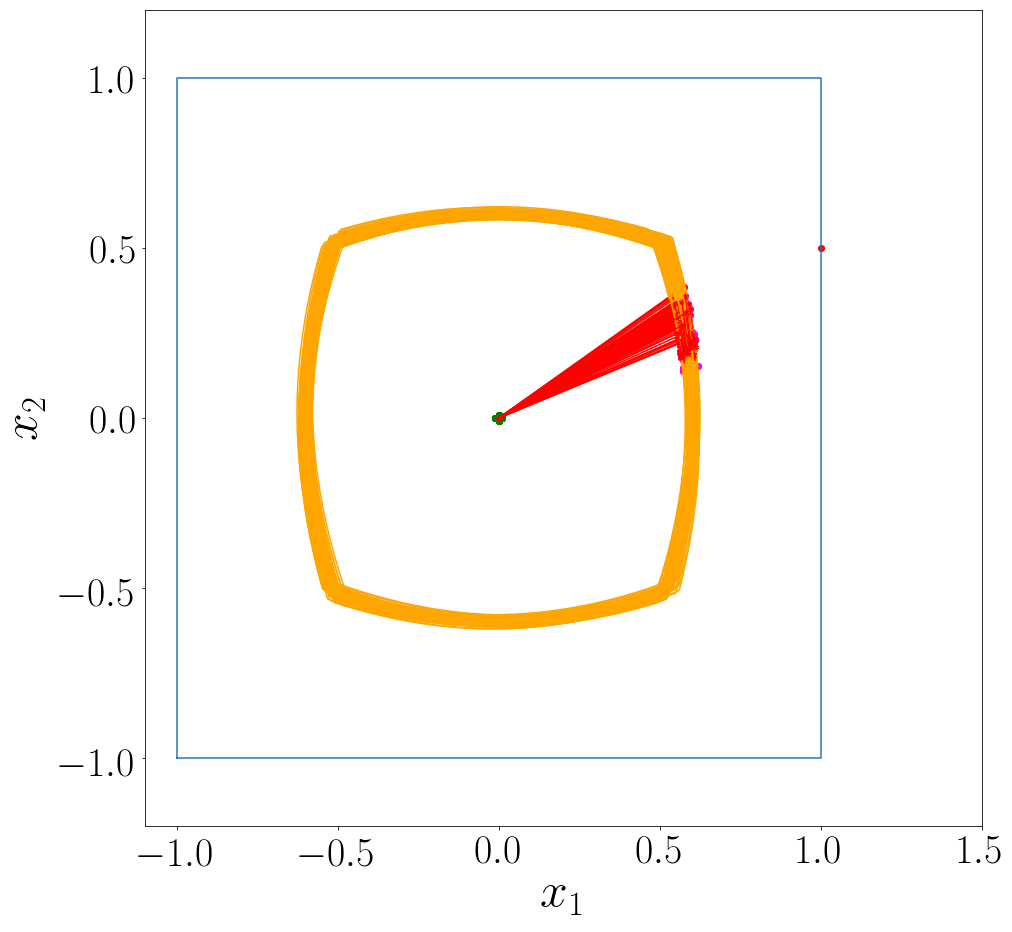

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


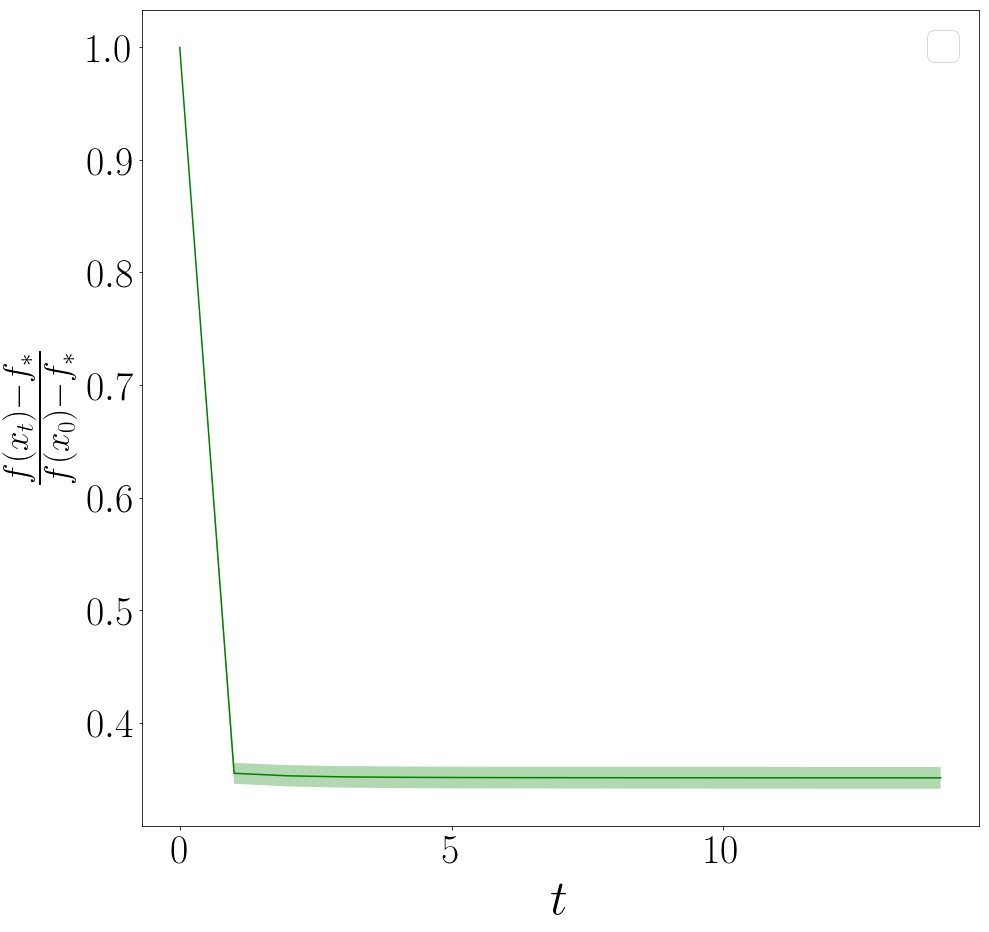

In [636]:
#T_max, eps, omega, E, Enum, d = 4(optional), x_start(optional)
D = 2
exp1 = Exp(15, 0.1, 0.01, 100, 1, d = D,  x_start = 0.*np.ones(D), method = Alternative, sigma = 0.1, N  = 2831)

     pcost       dcost       gap    pres   dres
 0: -1.8056e+00 -7.6944e+00  6e+00  4e-17  2e-16
 1: -2.0435e+00 -2.3545e+00  3e-01  2e-16  1e-16
 2: -2.1240e+00 -2.1381e+00  1e-02  3e-16  3e-17
 3: -2.1250e+00 -2.1252e+00  2e-04  7e-17  9e-17
 4: -2.1250e+00 -2.1250e+00  2e-06  3e-16  9e-17
Optimal solution found.
(3300, 2)
(3, 3) [[6.06060606e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.06060606e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.03030303e-04]]
     pcost       dcost       gap    pres   dres   k/t
 0:  5.4423e-02 -8.6629e+00  9e+00  9e-19  6e-02  1e+00
 1: -1.3904e+00 -2.5284e+00  1e+00  9e-16  9e-03  1e-01
 2: -1.6372e+00 -1.7271e+00  9e-02  4e-16  7e-04  1e-02
 3: -1.6586e+00 -1.6713e+00  1e-02  1e-15  9e-05  2e-03
 4: -1.6589e+00 -1.6593e+00  4e-04  8e-16  3e-06  6e-05
 5: -1.6589e+00 -1.6589e+00  1e-05  7e-14  1e-07  2e-06
 6: -1.6589e+00 -1.6589e+00  2e-07  3e-13  1e-09  2e-08
Optimal solution found.
(3, 3) [[6.06060606e+00 0.00000000e+00 0.00000000e+

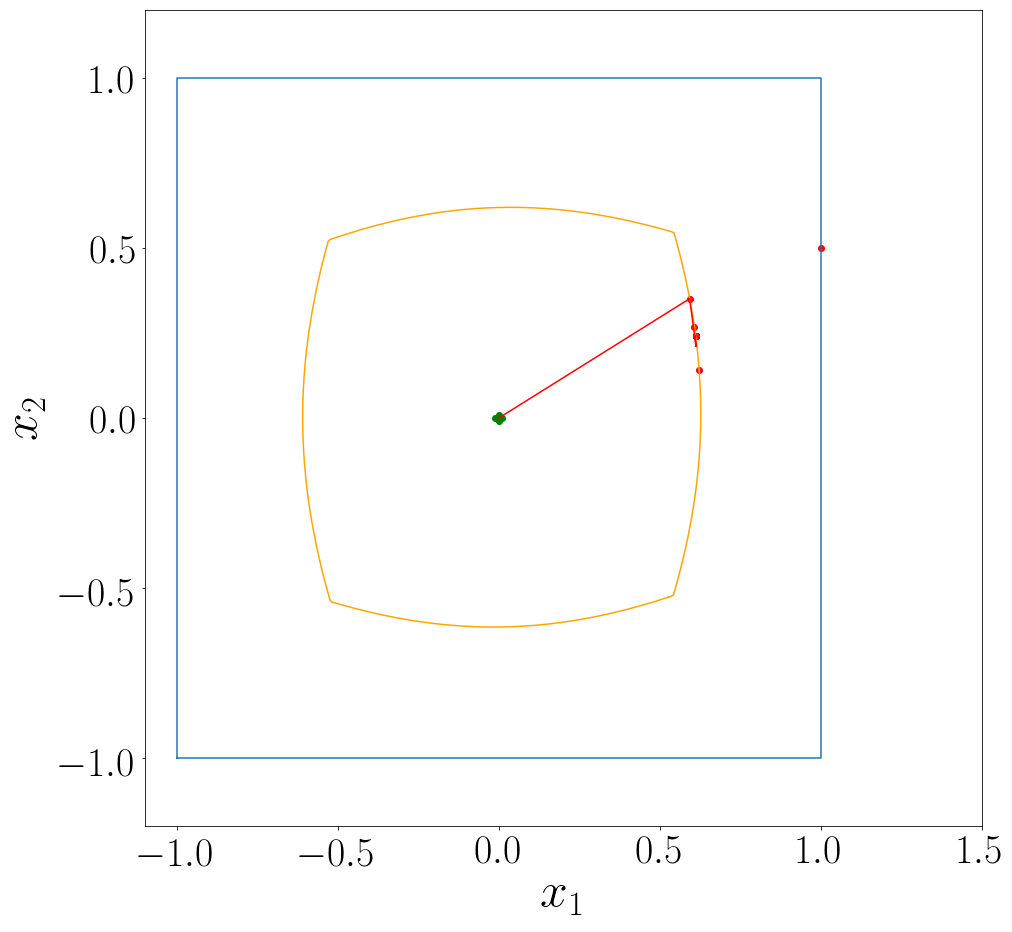

eps 0.1 vio 0.0
eps 0.1 non_conv 0.0
gamma


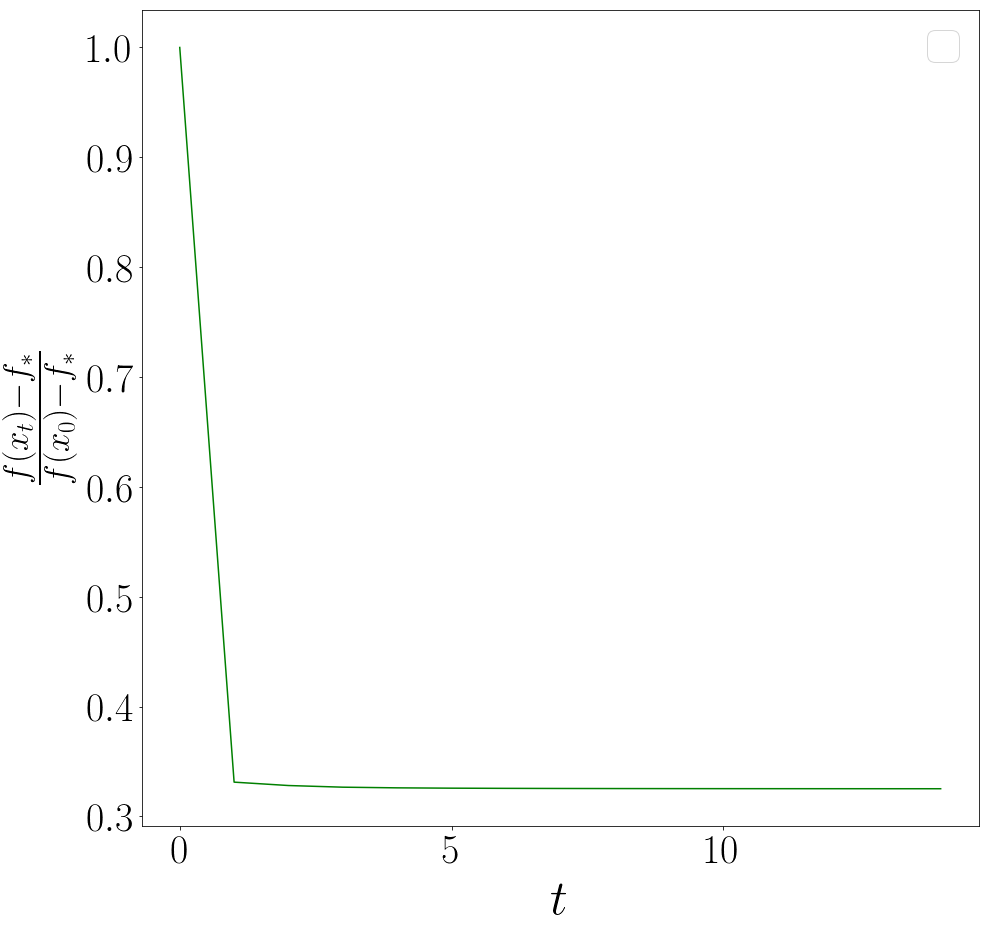

In [646]:
exp1_1run = Exp(15, 0.1, 0.01, 1, 1, d = D,  x_start = 0.*np.ones(D), method = Alternative, sigma = 0.1, N  = 3300)

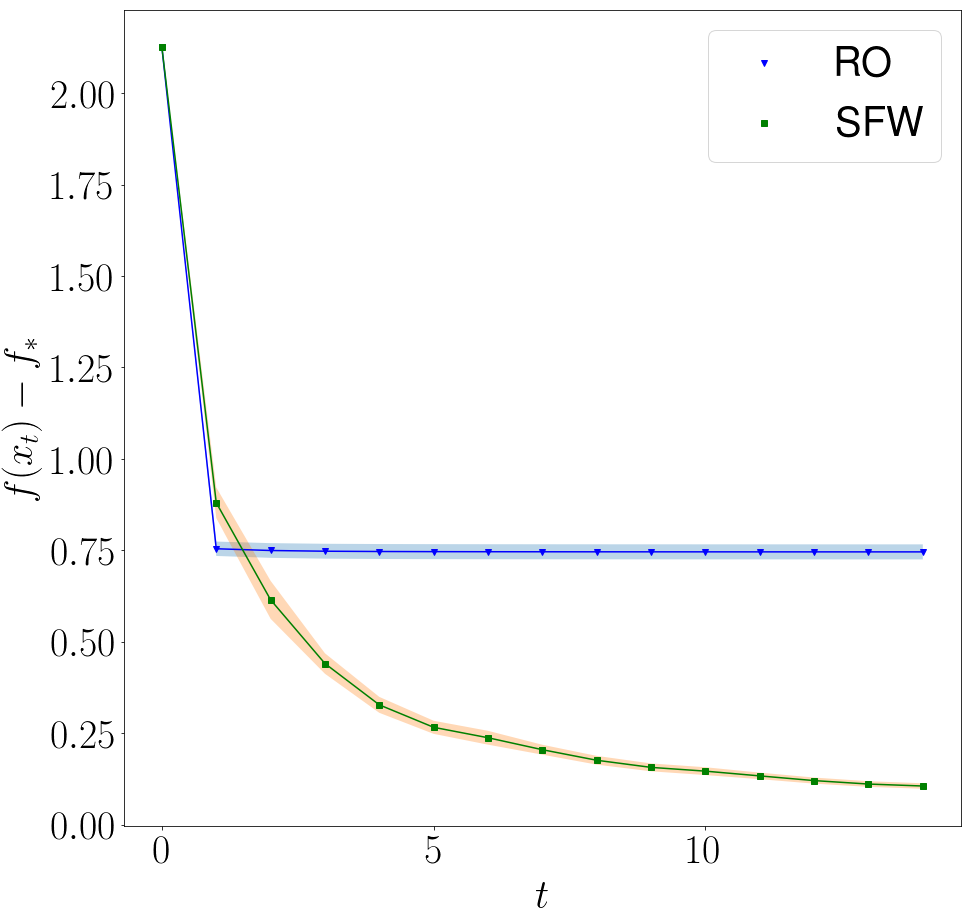

In [637]:
x, mean, std, mi, ma, name = exp1[-1][0]

plt.figure(figsize=(15, 15))
plt.plot(x, mean, 'bv-', label='RO ')# + name)
plt.fill_between(x, mean + std, mean - std, alpha=0.3)#, label='RO std of convergence')
#plt.fill_between(x, ma, mi, alpha=0.5, label='Critical values exp1')

x, mean, std, mi, ma, name = exp2[-1][0]

plt.plot(x, mean, 'gs-', label='SFW')# + name)
plt.fill_between(x, mean + std, mean - std, alpha=0.3)#, label='SCFW std of convergence')
#plt.fill_between(x, ma, mi, alpha=0.5, label='Critical values exp2')
leg = plt.legend(loc='best', fontsize=40)
for legobj in leg.legendHandles:
    legobj.set_linewidth(0.0)

plt.tick_params(axis='both', which='major', labelsize=40)
plt.xlabel(r"$t$", fontsize=40)
plt.ylabel(r"$f(x_t) - f_*$", fontsize=40)
plt.show()

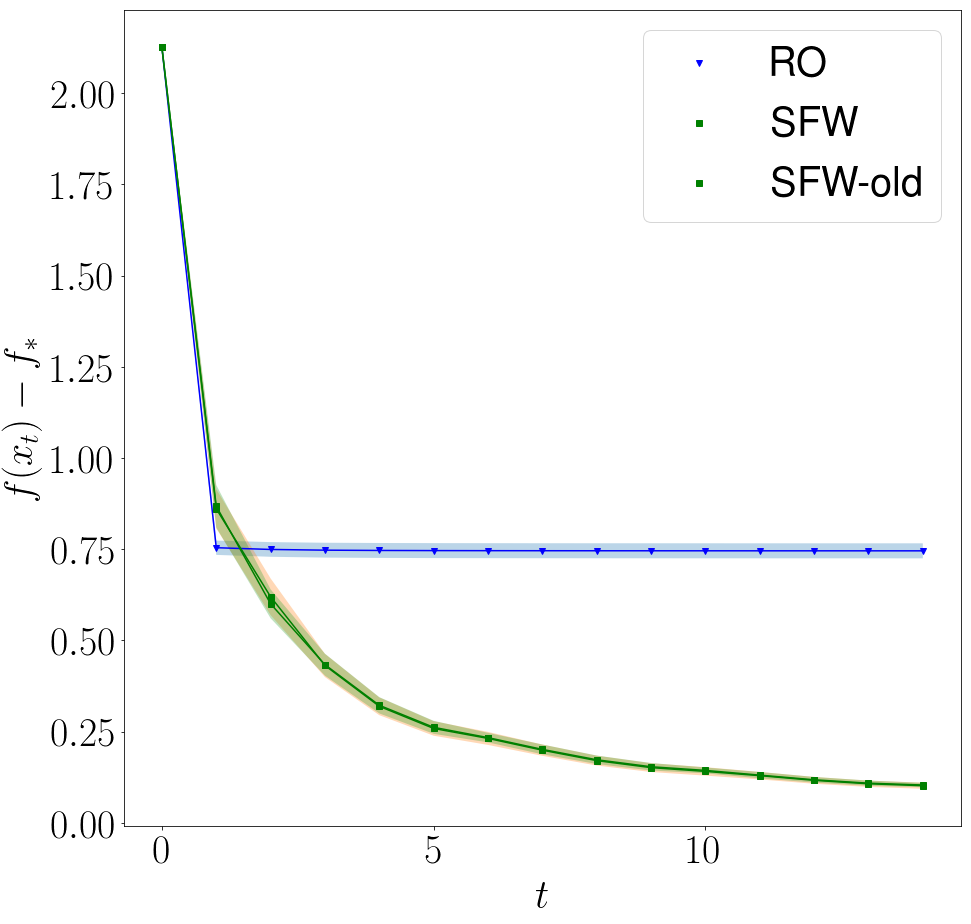

In [731]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
x, mean, std, mi, ma, name = exp1[-1][0]

plt.figure(figsize=(15, 15))
plt.plot(x, mean, 'bv-', label='RO ')# + name)
plt.fill_between(x, mean + std, mean - std, alpha=0.3)#, label='RO std of convergence')
#plt.fill_between(x, ma, mi, alpha=0.5, label='Critical values exp1')

x, mean, std, mi, ma, name = exp22[-1][0]

plt.plot(x, mean, 'gs-', label='SFW')# + name)
plt.fill_between(x, mean + std, mean - std, alpha=0.3)#, label='SCFW std of convergence')
#plt.fill_between(x, ma, mi, alpha=0.5, label='Critical values exp2')
leg = plt.legend(loc='best', fontsize=40)
for legobj in leg.legendHandles:
    legobj.set_linewidth(0.0)
    
x, mean, std, mi, ma, name = exp33[-1][0]

plt.plot(x, mean, 'gs-', label='SFW-old')# + name)
plt.fill_between(x, mean + std, mean - std, alpha=0.3)#, label='SCFW std of convergence')
#plt.fill_between(x, ma, mi, alpha=0.5, label='Critical values exp2')
leg = plt.legend(loc='best', fontsize=40)
for legobj in leg.legendHandles:
    legobj.set_linewidth(0.0)

plt.tick_params(axis='both', which='major', labelsize=40)
plt.xlabel(r"$t$", fontsize=40)
plt.ylabel(r"$f(x_t) - f_*$", fontsize=40)
plt.show()

# PLOTS

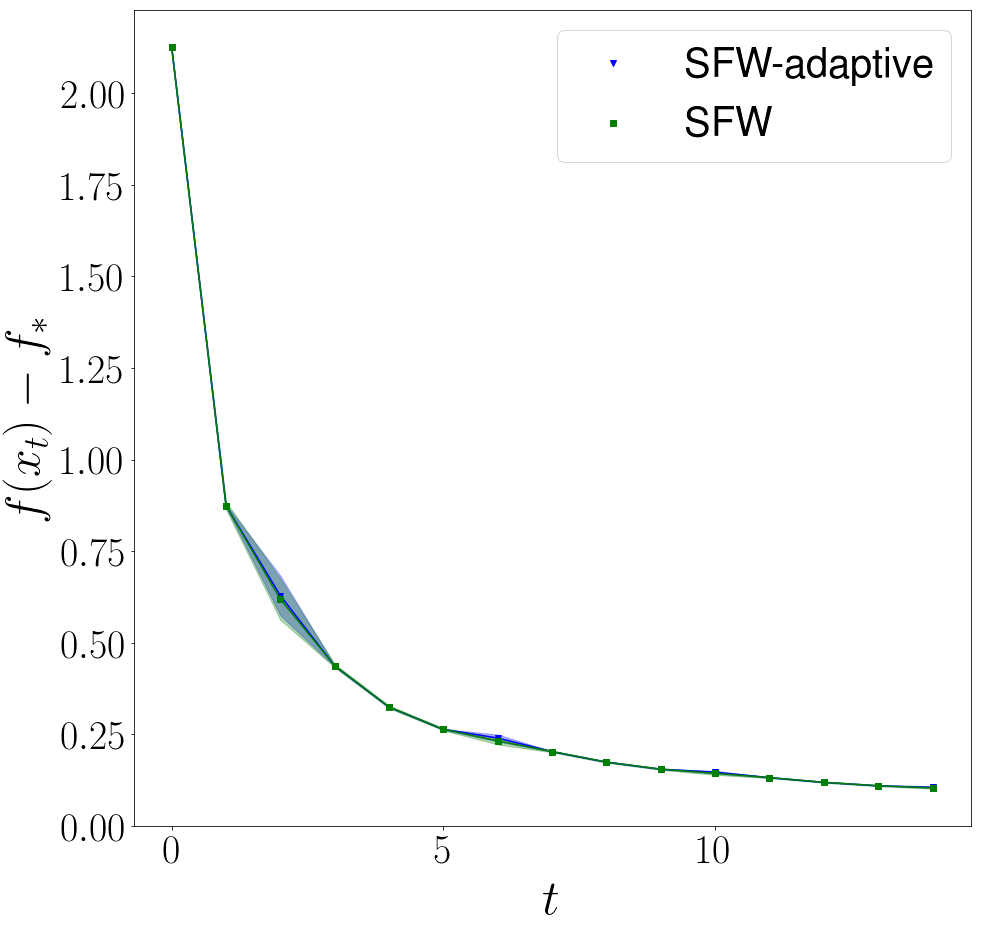

In [598]:
plt.figure(figsize=(15, 15))
x1, y1, s1, _, _, _ = exp01[-1][0]
x2, y2, s2, _, _, _ = exp101[-1][0]
plt.plot(x1, y1, 'bv-', label='SFW-adaptive')
plt.fill_between(x1, y1 + s1, y1 - s1, alpha=0.3, color='blue')
plt.plot(x2, y2, 'gs-', label='SFW')
plt.fill_between(x2, y2 + s2, y2 - s2, alpha=0.3, color='green')
plt.tick_params(axis='both', which='major', labelsize=40)
leg = plt.legend(loc='best', fontsize=40)
for legobj in leg.legendHandles:
    legobj.set_linewidth(0.0)
plt.xlabel(r"$t$", fontsize=50)
plt.ylabel(r"$f(x_t) - f_*$", fontsize=50)
plt.show()

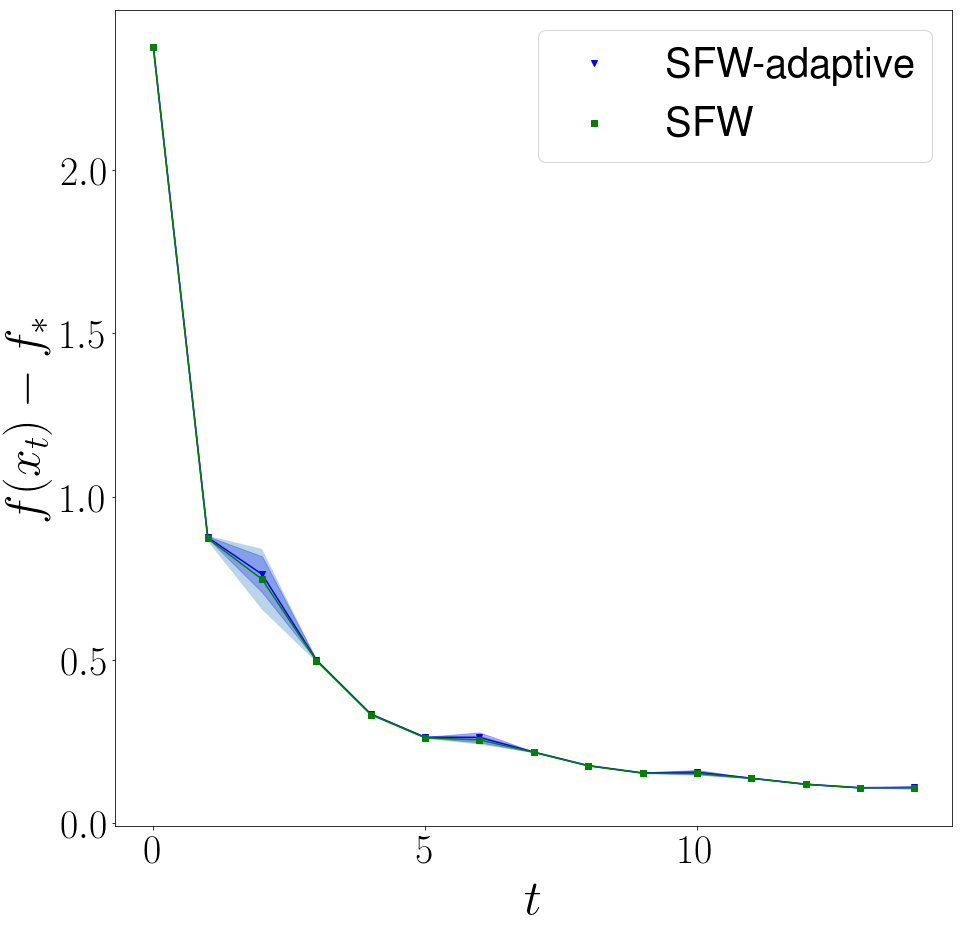

In [599]:
plt.figure(figsize=(15, 15))
x1, y1, s1, _, _, _ = exp02[-1][0]
x2, y2, s2, _, _, _ = exp102[-1][0]
plt.plot(x1, y1, 'bv-', label='SFW-adaptive')
plt.fill_between(x1, y1 + s1, y1 - s1, alpha=0.3, color='blue')
plt.plot(x2, y2, 'gs-', label='SFW')
plt.fill_between(x2, y2 + s2, y2 - s2, alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=40)
leg = plt.legend(loc='best', fontsize=40)
for legobj in leg.legendHandles:
    legobj.set_linewidth(0.0)
plt.xlabel(r"$t$", fontsize=50)
plt.ylabel(r"$f(x_t) - f_*$", fontsize=50)
plt.show()

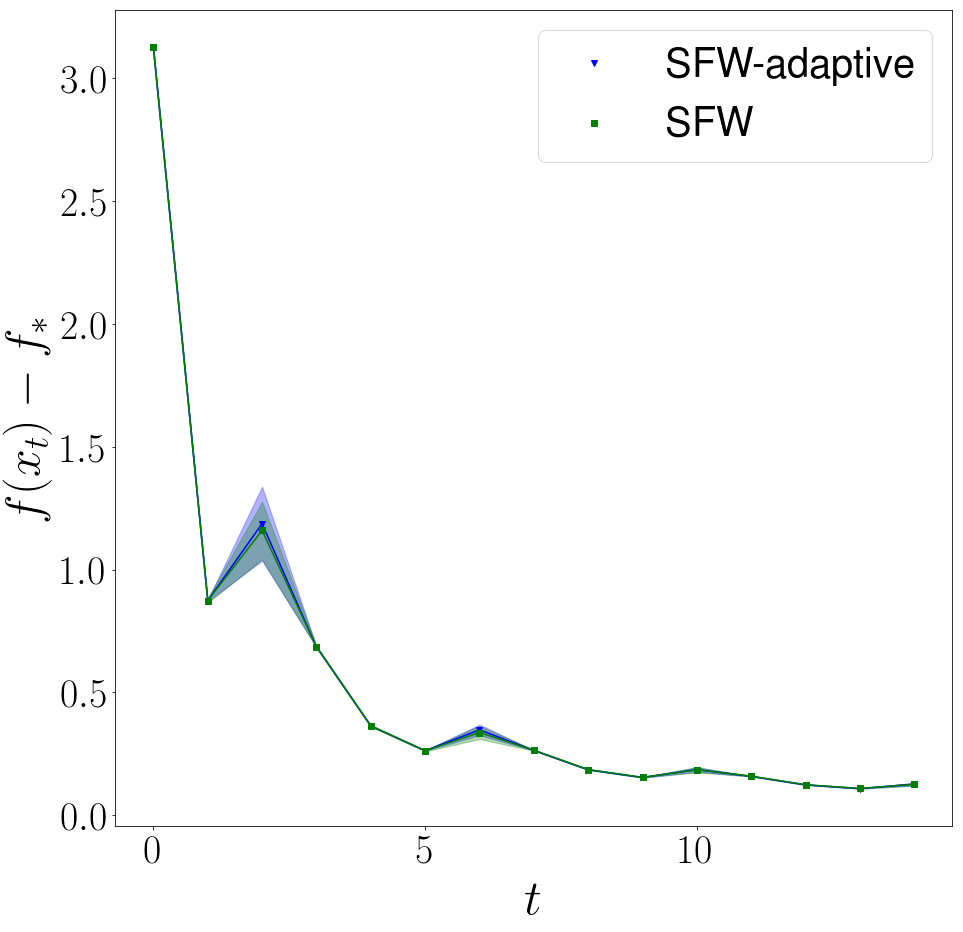

In [600]:
plt.figure(figsize=(15, 15))
x1, y1, s1, _, _, _ = exp03[-1][0]
x2, y2, s2, _, _, _ = exp103[-1][0]
plt.plot(x1, y1, 'bv-', label='SFW-adaptive')
plt.fill_between(x1, y1 + s1, y1 - s1, alpha=0.3, color='blue')
plt.plot(x2, y2, 'gs-', label='SFW')
plt.fill_between(x2, y2 + s2, y2 - s2, alpha=0.3, color='green')
plt.tick_params(axis='both', which='major', labelsize=40)
leg = plt.legend(loc='best', fontsize=40)

for legobj in leg.legendHandles:
    legobj.set_linewidth(0.0)
plt.xlabel(r"$t$", fontsize=50)
plt.ylabel(r"$f(x_t) - f_*$", fontsize=50)
plt.show()